## Project 4:  Solving N-Queens Problem using Genetic Algorithms

#### CSC 180  Intelligent Systems

#### Dr. Haiquan Chen, California State University, Sacramento


In [4]:
# Insert your name, your id, course title, assignment id, and due date here as comment 
# Project 4: Due 4/23
#
# Noah Venethongkham, 219660117
# Ashley Thor, 219334909
# Lucas Saechao, 218794239


## Part I: Position-index-based board representation

In [5]:
import random
import math
import numpy as np
# run 'pip install deap'
from deap import algorithms, base, creator, tools
board_size = 8
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/Users/lucassaechao/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/lucassaechao/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [6]:
def create_individual():
    return random.sample(range(board_size * board_size), board_size)

In [7]:
print(create_individual())

[10, 5, 18, 44, 35, 52, 53, 55]


In [8]:
def show_grid(board, board_size):
    dashes = "--------------------------------"
    dashes = dashes[:(board_size * 2)]
    n = [0]*(board_size * board_size)
    for i in board:
        n[i] = 1
    
    count = 0
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // board_size == i:
                if n[j] == 1:
                    print('X',end="|")
                else:
                    print('-',end="|")
        print()
        print(dashes)
            


In [9]:
toolbox = base.Toolbox()

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [10]:
pop = toolbox.population(n=1000)

print(pop[0])

[7, 61, 49, 48, 2, 33, 37, 20]


In [11]:
show_grid(pop[0], board_size)

-|-|X|-|-|-|-|X|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|X|-|-|-|X|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
X|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------


### 10 pts:  Write your code in the cell below to define the "eval_fitness" function, which returns the fitness of any given board.  

- Noticed that in this case, mutation may generate invalid board, e.g., the board with dupliciate positions.  Think about   [5, 32, 8, 8, 41, 3, 55, 49]

- How to exclude those invalid boards from each generation? One way is to add some penalty to the fitness value of invalid boards.  In that case, any invalid board will have a very high fitness value (remember that our goal is to find the board with least fitness value).    To do that, let's write a function ***checkDuplicate()*** to calculate the number of queen pairs in the same position for any given board.   ***Give each duplicate a high penalty (i.e., multiply by 20, 50) and add the penalty to the fitness value.*** 

-  eval_fitness() returns the total number of duplicate position pair (with penalty) plus the total number of distinct pairs of queens that attack each other.  

In [12]:
# Calculate the number of queen pairs in the same position for any given board
def check_duplicate(individual):
    dup = 0
    individual_sorted = sorted(individual)
    duplicates=[]
    for i in individual_sorted:
     if individual_sorted.count(i)>1:
         if i not in duplicates:
             duplicates.append(i)
    dup = len(duplicates)
    
    return dup



## eval_fitness()
For a 1D array representing a board with some N queens, the following is done to check for collisions: first an empty dictionary is created. The dictionary is used to keep track of pair mappings in which an integer key maps to a tuple, representing that collision. Then, we check for a vertical, horizontal, and diagonal collision. A helper method unique_tuples() is given this dictionary, and computes a list of distinct conflicts. The size of this list is the number of distinct conflicts found for this board.

In [13]:
def unique_tuples(d):
    unique = []
    for key in d:
        reverse = ()
        item = d[key]
        for i in reversed(item):
            reverse += (i,)
        if item not in unique and reverse not in unique:
            unique.append(item)
    print(unique)
    return unique

def check_diag_right(i, j, board_size):
    n_upper = board_size + 1
    right_edge = []
    left_edge = []
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    
    # directly adjacent
    if i not in right_edge:
        right = i
        if (right + n_upper) == j:
            return True
    
    if i not in left_edge:
        left = i
        if (left - n_upper) == j:
            return True
    
    if j not in right_edge:
        right = j
        if (right + n_upper) == i:
            return True
    
    if j not in left_edge:
        left = j
        if (left - n_upper) == i:
            return True
    # if i > j scan i to the left else scan j to the left
    for l in range(board_size):
        if i > j:
            if i not in left_edge:
                i -= n_upper
                if i == j:
                    return True
            if j not in right_edge:
                j += n_upper
                if j == i:
                    return True
        else:
            if j not in left_edge:
                j -= n_upper
                if j == i:
                    return True
            if i not in right_edge:
                i += n_upper
                if i == j:
                    return True
    return False

def check_diag_left(i, j, board_size):
    n_lower = board_size - 1
    right_edge = []
    left_edge = []
    
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    
    # directly adjacent
    if i not in left_edge:
        right = i
        if (right + n_lower) == j:
            return True
    
    if i not in right_edge:
        left = i
        if (left - n_lower) == j:
            return True
    
    if j not in left_edge:
        right = j
        if (right + n_lower) == i:
            return True
    
    if j not in right_edge:
        left = j
        if (left - n_lower) == i:
            return True
    
    # if i > j scan i to the right else scan j to the right
    for l in range(board_size):
        if i > j:
            if i not in right_edge:
                i -= n_lower
                if i == j:
                    return True
            if j not in left_edge:
                j += n_lower
                if j == i:
                    return True
        else:
            if j not in right_edge:
                j -= n_lower
                if j == i:
                    return True
            if i not in left_edge:
                i += n_lower
                if i == j:
                    return True
    return False

def eval_fitness(individual):
    key = 0
    pairs = {}
    n_lower = board_size - 1
    
    for i in individual: 
        for j in individual:
            if i == j:
                continue
            if (i - j) % board_size == 0:
                key += 1
                pairs[key] = (i, j)
            if (math.floor(i / board_size)) == (math.floor(j / board_size)):
                key += 1
                pairs[key] = (i, j)
            if check_diag_right(i, j, board_size): 
                key += 1
                pairs[key] = (i, j)
            if check_diag_left(i, j, board_size):
                key += 1
                pairs[key] = (i, j)
    
    unique = unique_tuples(pairs)
    return ((50*check_duplicate(individual)) + len(unique),)

In [14]:
#list1 = [0, 10, 22, 31, 39, 44, 49, 62]
#list2 = [7, 13, 18, 28, 35, 41, 51, 61]
#list3 = [3, 9, 22, 24, 37, 47, 50, 57]
#list4 = [7, 11, 17, 28, 37, 41, 51, 61]
#print(eval_fitness(list1))
#print(eval_fitness(list2))
#print(eval_fitness(list3))
#print(eval_fitness(list4))
#Should print:
# [(22, 31), (22, 62), (31, 39), (44, 62)]
# (4,)
# [(7, 28), (7, 35), (13, 41), (13, 61), (28, 35), (35, 51)]
# (6,)
# [(3, 24), (9, 57), (22, 50), (22, 57), (50, 57)]
# (5,)
# [(7, 28), (11, 51), (17, 41), (28, 37), (37, 51), (37, 61)]
# (6,)

In [15]:
show_grid(pop[0], board_size)
print(eval_fitness(pop[0]))

-|-|X|-|-|-|-|X|
----------------
-|-|-|-|-|-|-|-|
----------------
-|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
-|X|-|-|-|X|-|-|
----------------
-|-|-|-|-|-|-|-|
----------------
X|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------
[(7, 49), (7, 2), (61, 37), (49, 48), (49, 33), (48, 20), (2, 20), (33, 37)]
(8,)


In [16]:
print(check_duplicate(pop[0]))

0


### 5 pts:  Writer your code in the cell below to register "evaluate" function to toolbox

In [17]:

toolbox.register("evaluate", eval_fitness)


In [18]:
toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutUniformInt, low = 0, up = (board_size * board_size), indpb=0.1)

toolbox.register("select", tools.selTournament, tournsize=3)

In [19]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

In [20]:
stats.register("avg", np.mean)
stats.register("min", np.min)

### 10 pts:  Writer your code in the cell below to create the first generation, the hall of fame, and launch the genetic algorithm: eaSimple().   How many individuals you want to have for each generation and how many generations you want GA to go thourgh for each run?     Vary those two parameters to see the change.

#### The *simple evolutionary algorithm* takes 5 arguments, a population, a toolbox, a probability of cross-overing two individuals (`cxpb`), a probability of mutating each individual (`mutpb`) and a number of generations to accomplish (`ngen`). 

In [21]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("min", np.min)

pop = toolbox.population(n=1000)

hof = tools.HallOfFame(maxsize=10)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, 
                                   stats=stats, halloffame=hof, verbose=True)

[(44, 42), (44, 28), (44, 51), (42, 28), (42, 34), (42, 2), (42, 51), (42, 21), (59, 51), (28, 21), (34, 2)]
[(47, 42), (47, 39), (47, 2), (47, 63), (10, 42), (10, 2), (10, 17), (10, 13), (42, 2), (39, 63)]
[(61, 54), (61, 21), (11, 14), (11, 20), (54, 46), (54, 14), (54, 22), (46, 14), (46, 22), (21, 14), (21, 20), (21, 22), (14, 22), (20, 22)]
[(25, 33), (25, 11), (33, 19), (19, 20), (19, 46), (19, 11), (15, 7), (15, 11), (20, 11)]
[(31, 27), (41, 27), (41, 6), (41, 42), (27, 51), (27, 6), (51, 58), (51, 42), (58, 42)]
[(14, 62), (14, 15), (17, 1), (17, 62), (1, 55), (61, 62), (55, 62), (55, 15)]
[(33, 40), (53, 48), (53, 45), (18, 45), (48, 40), (59, 45), (45, 40)]
[(32, 35), (32, 0), (32, 56), (45, 53), (45, 0), (53, 60), (53, 35), (60, 56), (35, 56), (0, 56)]
[(12, 60), (12, 11), (60, 51), (60, 58), (51, 58), (51, 27), (51, 11), (58, 18), (18, 27), (18, 11), (27, 11)]
[(2, 16), (2, 42), (2, 18), (2, 29), (16, 8), (16, 18), (54, 30), (54, 18), (30, 29), (42, 18)]
[(41, 44), (41, 57

[(31, 59), (31, 30), (44, 17), (44, 12), (44, 30), (59, 57), (21, 17), (21, 12), (21, 30), (17, 57), (12, 30)]
[(21, 61), (62, 61), (62, 55), (62, 57), (11, 9), (11, 15), (61, 57), (9, 15), (9, 57), (55, 15), (15, 57)]
[(12, 30), (12, 20), (12, 9), (30, 54), (30, 58), (9, 54), (54, 61), (61, 58)]
[(61, 16), (50, 51), (50, 48), (50, 15), (16, 20), (16, 48), (3, 51), (51, 48), (20, 48)]
[(33, 19), (33, 39), (33, 25), (19, 43), (19, 16), (43, 25), (43, 16), (13, 4), (25, 16), (25, 4)]
[(23, 19), (23, 17), (23, 21), (1, 19), (1, 17), (19, 17), (19, 21), (13, 45), (13, 21), (17, 21), (45, 52), (45, 21)]
[(8, 1), (8, 10), (8, 44), (8, 24), (8, 16), (45, 44), (1, 10), (1, 25), (10, 24), (24, 25), (24, 16), (25, 16)]
[(37, 36), (16, 25), (16, 43), (42, 7), (42, 43), (36, 43), (36, 12), (25, 43)]
[(32, 4), (32, 35), (32, 0), (52, 4), (4, 0), (9, 57), (9, 0)]
[(44, 45), (44, 36), (44, 4), (44, 52), (48, 6), (48, 55), (48, 52), (6, 4), (45, 36), (45, 52), (36, 4), (36, 52), (55, 52), (4, 52)]
[(5

[(19, 20), (13, 20), (20, 47), (20, 60), (47, 42), (47, 63), (42, 60), (63, 60)]
[(57, 61), (23, 14), (23, 21), (23, 31), (14, 6), (14, 21), (0, 6), (21, 61)]
[(36, 9), (36, 43), (36, 22), (36, 52), (8, 9), (8, 48), (8, 11), (9, 11), (48, 52), (11, 43), (43, 22), (43, 52)]
[(25, 24), (25, 61), (25, 18), (23, 55), (23, 18), (23, 58), (61, 58), (55, 46), (18, 58)]
[(3, 19), (3, 5), (3, 30), (58, 60), (58, 30), (36, 60), (19, 5)]
[(39, 47), (39, 31), (39, 34), (45, 47), (45, 44), (45, 31), (22, 14), (22, 31), (47, 44), (47, 31)]
[(38, 52), (38, 6), (38, 31), (52, 61), (52, 31), (0, 6), (0, 1), (0, 24), (6, 1), (31, 24)]
[(24, 8), (24, 25), (24, 42), (37, 5), (5, 7), (47, 7), (47, 42), (7, 42)]
[(58, 63), (58, 2), (36, 29), (36, 63), (3, 2), (29, 2), (29, 31), (29, 25), (63, 31), (31, 25)]
[(6, 41), (6, 13), (6, 54), (41, 13), (41, 47), (13, 53), (53, 52), (53, 54), (52, 54), (47, 54), (47, 23)]
[(36, 9), (36, 34), (36, 0), (5, 13), (5, 0), (5, 14), (31, 13), (9, 13), (9, 0), (9, 14), (34,

[(61, 37), (10, 28), (10, 37), (28, 49), (28, 27), (28, 37), (28, 36), (49, 51), (27, 51), (27, 36), (37, 51), (37, 36)]
[(2, 0), (2, 29), (13, 29), (13, 61), (63, 0), (63, 61), (63, 56), (0, 56), (25, 29), (25, 61), (29, 61), (61, 56)]
[(40, 26), (25, 26), (25, 4), (53, 26), (53, 51)]
[(2, 38), (2, 50), (2, 20), (28, 20), (28, 36), (32, 38), (32, 50), (32, 36), (38, 20), (38, 36), (38, 45), (50, 36), (20, 36), (36, 45)]
[(16, 24), (16, 43), (16, 40), (24, 29), (24, 40), (24, 30), (29, 43), (29, 36), (29, 30), (43, 40), (43, 36), (58, 40), (58, 30)]
[(0, 54), (0, 56), (0, 24), (22, 31), (22, 54), (22, 23), (31, 59), (31, 23), (31, 24), (59, 56), (56, 24)]
[(29, 25), (29, 61), (29, 24), (52, 4), (52, 25), (52, 61), (52, 60), (4, 25), (4, 60), (25, 61), (25, 24), (25, 41), (61, 60), (24, 60)]
[(51, 55), (51, 58), (51, 27), (40, 5), (40, 58), (40, 41), (21, 5), (41, 27)]
[(48, 32), (48, 27), (48, 6), (48, 49), (5, 6), (32, 38), (42, 49), (38, 6), (27, 6)]
[(51, 44), (51, 42), (51, 37), (2

[(40, 56), (40, 12), (54, 55), (56, 28), (55, 28), (17, 25), (25, 28), (28, 12)]
[(49, 54), (49, 28), (49, 14), (54, 61), (54, 47), (54, 14), (44, 28), (44, 47), (44, 23), (28, 14), (61, 47), (47, 23), (23, 14)]
[(52, 38), (52, 60), (41, 42), (42, 10), (42, 60), (63, 39), (63, 60), (38, 39), (39, 60)]
[(30, 37), (30, 38), (55, 53), (55, 37), (59, 38), (53, 37), (37, 38), (37, 36), (38, 36)]
[(60, 46), (60, 51), (46, 10), (46, 19), (10, 9), (10, 34), (10, 19), (49, 9), (49, 51), (51, 19)]
[(28, 1), (28, 21), (23, 58), (23, 21), (2, 58), (2, 1), (58, 59), (53, 21)]
[(26, 28), (26, 33), (26, 18), (26, 62), (38, 33), (38, 62), (38, 45), (33, 57), (18, 45), (62, 57)]
[(42, 50), (42, 35), (42, 14), (42, 41), (50, 22), (50, 41), (35, 3), (35, 37), (35, 14), (22, 14)]
[(3, 5), (3, 39), (3, 35), (3, 10), (58, 10), (39, 35), (39, 15), (10, 15)]
[(15, 43), (41, 33), (41, 43), (41, 42), (41, 45), (0, 45), (38, 33), (38, 45), (33, 42), (43, 42), (43, 45), (42, 45)]
[(51, 58), (51, 24), (51, 52), (5

[(11, 43), (11, 35), (11, 9), (43, 35), (43, 40), (43, 42), (35, 17), (35, 42), (35, 37), (17, 9), (40, 42)]
[(14, 21), (14, 15), (14, 62), (34, 16), (34, 27), (16, 21), (16, 24), (27, 24)]
[(9, 13), (9, 16), (9, 2), (4, 13), (4, 2), (38, 37), (38, 2), (37, 13), (16, 43), (16, 2)]
[(3, 39), (3, 51), (22, 18), (22, 20), (60, 56), (60, 39), (60, 51), (60, 20), (18, 20)]
[(28, 42), (28, 1), (28, 30), (50, 32), (50, 42), (50, 58), (32, 39), (39, 30), (42, 58), (58, 30)]
[(51, 33), (33, 57), (33, 36), (33, 38), (33, 26), (57, 36), (57, 61), (36, 38), (13, 61)]
[(57, 63), (19, 11), (19, 46), (38, 11), (38, 46), (38, 31), (11, 4), (63, 31), (31, 4)]
[(28, 35), (28, 37), (28, 24), (28, 10), (28, 27), (28, 55), (35, 37), (35, 8), (35, 27), (37, 10), (37, 55), (8, 24), (8, 10), (24, 10), (24, 27), (10, 55)]
[(46, 47), (46, 45), (47, 45), (47, 2), (18, 45), (18, 50), (18, 2), (33, 49), (50, 49), (50, 2)]
[(57, 36), (36, 52), (52, 31), (52, 53), (30, 31), (30, 14), (31, 47)]
[(2, 50), (2, 5), (50,

[(20, 19), (20, 36), (19, 46), (19, 3), (19, 37), (46, 54), (46, 62), (46, 37), (54, 62), (54, 36), (36, 37)]
[(45, 41), (45, 42), (58, 50), (58, 51), (58, 62), (58, 42), (50, 51), (50, 41), (50, 42), (51, 42), (41, 42), (62, 14), (42, 14)]
[(57, 43), (57, 17), (57, 29), (4, 11), (4, 18), (11, 43), (11, 29), (11, 18), (43, 29), (17, 24), (17, 18), (24, 29)]
[(56, 35), (56, 62), (56, 21), (35, 62), (35, 33), (35, 21), (6, 62), (6, 2), (6, 13), (21, 13)]
[(30, 51), (30, 26), (51, 50), (50, 26), (50, 10), (26, 10)]
[(16, 61), (35, 27), (35, 38), (54, 61), (54, 46), (54, 55), (54, 27), (54, 38), (46, 55), (46, 38)]
[(46, 60), (46, 43), (46, 6), (46, 1), (51, 60), (51, 43), (16, 43), (6, 1)]
[(8, 0), (8, 11), (8, 24), (8, 13), (39, 55), (39, 34), (0, 24), (11, 13), (34, 13)]
[(3, 4), (3, 21), (13, 34), (13, 41), (13, 4), (13, 21), (56, 21), (34, 18), (34, 41), (18, 4), (18, 21)]
[(49, 33), (49, 40), (49, 58), (49, 50), (33, 40), (33, 19), (33, 12), (40, 43), (40, 58), (40, 19), (40, 12), (4

[(2, 3), (2, 58), (27, 3), (27, 28), (58, 49), (14, 28), (14, 49), (28, 49)]
[(32, 8), (32, 48), (32, 11), (32, 18), (12, 19), (12, 8), (12, 11), (19, 11), (19, 18), (8, 48), (8, 11), (57, 48), (11, 18)]
[(52, 31), (52, 43), (52, 51), (29, 31), (29, 2), (29, 43), (29, 5), (2, 5), (43, 51)]
[(58, 50), (58, 30), (58, 57), (58, 40), (58, 44), (50, 57), (30, 44), (16, 40), (40, 44), (40, 5)]
[(60, 46), (60, 52), (10, 46), (10, 8), (46, 38), (46, 47), (52, 38), (38, 47)]
[(34, 48), (54, 9), (54, 14), (54, 48), (54, 30), (9, 12), (9, 14), (7, 14), (12, 14), (12, 30), (14, 30)]
[(52, 25), (52, 55), (52, 28), (37, 55), (37, 28), (62, 55), (62, 22), (25, 28), (55, 28)]
[(30, 22), (52, 4), (52, 20), (35, 33), (35, 42), (4, 20), (4, 22), (20, 22), (33, 42)]
[(57, 60), (57, 41), (60, 46), (26, 5), (26, 35), (26, 18), (46, 41)]
[(21, 14), (21, 7), (14, 6), (14, 8), (14, 7), (6, 7), (6, 1), (8, 44), (8, 1), (25, 1), (7, 1)]
[(43, 19), (63, 31), (2, 4), (4, 31), (53, 49)]
[(30, 28), (30, 22), (30, 51

[(16, 25), (16, 21), (16, 20), (16, 2), (25, 31), (21, 20), (21, 37), (20, 2)]
[(37, 23), (37, 5), (37, 32), (37, 55), (37, 29), (23, 22), (23, 5), (23, 55), (22, 29), (5, 29)]
[(15, 6), (15, 50), (37, 58), (37, 45), (58, 49), (58, 50), (49, 50), (6, 27), (45, 27)]
[(11, 59), (11, 14), (31, 23), (31, 63), (31, 59), (23, 63), (23, 14), (60, 63), (60, 59), (63, 59), (59, 50)]
[(30, 22), (30, 54), (30, 28), (22, 54), (22, 50), (54, 53), (54, 50), (54, 52), (53, 50), (53, 52), (28, 52), (50, 52)]
[(9, 18), (9, 13), (43, 61), (43, 47), (31, 13), (31, 47), (13, 61), (62, 61), (61, 47)]
[(40, 47), (40, 32), (40, 48), (40, 26), (47, 54), (32, 59), (32, 48), (22, 54), (48, 54)]
[(52, 49), (52, 51), (49, 51), (49, 14), (49, 56), (5, 37), (5, 14), (37, 51), (14, 56)]
[(63, 27), (63, 60), (63, 59), (24, 27), (24, 60), (34, 27), (34, 38), (27, 59), (44, 60), (38, 59), (60, 59)]
[(20, 36), (20, 41), (20, 22), (20, 11), (36, 57), (36, 22), (41, 57), (57, 22), (57, 61)]
[(21, 16), (21, 3), (54, 51), (

[(46, 6), (46, 60), (7, 6), (7, 63), (8, 17), (60, 63)]
[(31, 29), (2, 42), (2, 29), (42, 49), (17, 49), (61, 29)]
[(46, 41), (46, 14), (46, 6), (46, 1), (26, 2), (41, 6), (41, 1), (14, 6), (2, 6), (2, 1), (6, 1)]
[(42, 33), (42, 60), (42, 43), (63, 60), (33, 60), (33, 17), (60, 52), (16, 43), (16, 52), (16, 17), (43, 52)]
[(32, 18), (32, 4), (15, 43), (2, 18), (2, 4), (18, 4), (43, 52), (4, 52)]
[(26, 12), (26, 53), (12, 20), (20, 16), (20, 23), (32, 16), (32, 37), (16, 23), (37, 53), (37, 23)]
[(9, 0), (28, 4), (34, 38), (34, 39), (4, 0), (4, 3), (38, 39), (39, 3), (0, 3)]
[(40, 47), (40, 32), (13, 22), (22, 18), (18, 32)]
[(7, 47), (46, 22), (46, 47), (18, 26), (18, 22), (18, 17), (26, 17), (22, 17)]
[(20, 38), (20, 17), (20, 6), (20, 2), (38, 6), (38, 2), (49, 17), (49, 42), (6, 2), (42, 2)]
[(23, 63), (23, 19), (23, 58), (23, 15), (63, 58), (63, 15), (63, 54), (6, 15), (6, 54)]
[(1, 5), (11, 18), (11, 47), (11, 35), (44, 47), (44, 35)]
[(62, 26), (62, 57), (27, 26), (27, 45), (27,

[(23, 44), (23, 30), (23, 17), (29, 50), (29, 30), (44, 30), (44, 17), (50, 34)]
[(47, 15), (27, 9), (27, 13), (27, 30), (9, 13), (9, 15), (21, 13), (21, 30), (13, 15), (58, 30)]
[(59, 60), (59, 63), (59, 35), (48, 54), (60, 63), (54, 63), (21, 35), (21, 29)]
[(63, 57), (17, 26), (17, 57), (17, 1), (26, 12), (26, 30), (57, 1), (1, 46), (12, 30), (30, 46)]
[(20, 13), (20, 6), (13, 8), (13, 6), (51, 3), (3, 6), (3, 39), (8, 32), (39, 32)]
[(51, 33), (1, 7), (1, 28), (1, 33), (7, 14), (7, 31), (7, 28), (14, 28), (31, 28)]
[(12, 8), (12, 21), (63, 0), (63, 61), (63, 55), (0, 8), (61, 21)]
[(55, 31), (55, 63), (59, 31), (59, 63), (59, 3), (31, 26), (31, 63), (26, 42), (63, 36)]
[(2, 47), (47, 40), (24, 40), (24, 56), (40, 49), (40, 56), (49, 56)]
[(35, 3), (35, 33), (35, 21), (3, 2), (3, 10), (3, 21), (41, 33), (2, 10), (15, 10)]
[(48, 56), (48, 40), (38, 35), (38, 2), (35, 21), (35, 56), (21, 23), (21, 56), (56, 40)]
[(36, 34), (36, 32), (36, 57), (36, 33), (34, 16), (34, 32), (34, 33), (1

[(14, 62), (14, 56), (14, 15), (62, 56), (62, 17), (62, 61), (62, 58), (51, 58), (56, 61), (56, 58), (61, 58)]
[(56, 63), (56, 16), (4, 5), (63, 47), (53, 46), (53, 5), (46, 47)]
[(16, 20), (16, 43), (16, 56), (16, 34), (15, 29), (15, 43), (29, 20), (29, 43), (29, 30), (20, 34), (43, 34)]
[(35, 3), (35, 56), (35, 34), (3, 6), (20, 6), (20, 34), (20, 29), (6, 34)]
[(51, 23), (51, 54), (51, 19), (23, 63), (23, 19), (63, 54), (63, 57)]
[(60, 46), (46, 10), (46, 22), (10, 9), (10, 13), (49, 9), (49, 25), (9, 13), (9, 25), (13, 22)]
[(58, 44), (36, 44), (36, 27), (25, 1), (25, 11), (25, 27), (1, 5), (11, 27)]
[(23, 47), (23, 30), (23, 14), (61, 47), (61, 43), (46, 47), (46, 30), (46, 14), (46, 43), (46, 41), (47, 43), (47, 41), (30, 14), (43, 41)]
[(58, 63), (58, 50), (28, 12), (28, 25), (63, 9), (12, 9), (9, 25)]
[(58, 63), (11, 27), (11, 32), (24, 27), (24, 17), (24, 32), (27, 63)]
[(52, 34), (52, 25), (24, 25), (24, 56), (34, 25), (9, 25)]
[(58, 44), (58, 50), (28, 46), (28, 27), (28, 44

[(10, 1), (10, 17), (25, 1), (25, 17), (48, 54), (48, 40), (1, 17)]
[(13, 27), (13, 12), (27, 54), (42, 60), (42, 44), (60, 12), (60, 44), (12, 44)]
[(7, 63), (57, 59), (57, 25), (57, 22), (57, 63), (26, 25), (59, 63)]
[(10, 11), (10, 13), (10, 34), (44, 62), (44, 30), (11, 13), (62, 30), (13, 31), (13, 34), (31, 30)]
[(0, 2), (2, 20), (49, 57), (49, 14), (57, 61)]
[(33, 24), (33, 40), (24, 40), (62, 58), (62, 59), (18, 58), (18, 45), (58, 59), (58, 40), (59, 45), (45, 40)]
[(42, 18), (42, 14), (42, 28), (42, 56), (53, 48), (48, 56), (14, 28), (14, 56), (28, 56)]
[(11, 47), (11, 8), (49, 54), (44, 47), (44, 8), (54, 47), (47, 31)]
[(37, 45), (37, 33), (37, 19), (45, 27), (27, 20), (27, 19), (33, 19), (20, 19)]
[(59, 63), (59, 3), (59, 56), (17, 24), (17, 3), (17, 53), (63, 56), (24, 3), (24, 56)]
[(62, 53), (62, 17), (11, 47), (11, 20), (47, 20), (53, 17), (53, 50), (17, 20)]
[(10, 1), (25, 1), (48, 54), (48, 40), (1, 7), (7, 39)]
[(48, 57), (48, 51), (48, 55), (48, 27), (57, 33), (57,

[(34, 6), (6, 62), (6, 22), (6, 7), (6, 0), (62, 44), (62, 22), (44, 51), (7, 0)]
[(23, 7), (61, 45), (36, 9), (36, 45), (9, 2), (9, 45), (7, 2)]
[(55, 31), (55, 37), (55, 23), (31, 23), (8, 56), (56, 60), (37, 23)]
[(10, 1), (10, 17), (25, 1), (25, 17), (1, 7), (1, 17), (7, 63), (60, 63)]
[(46, 6), (46, 39), (46, 54), (46, 40), (50, 54), (7, 6), (7, 39), (6, 54), (8, 40)]
[(11, 27), (11, 15), (34, 16), (34, 27), (16, 21), (16, 24), (27, 24)]
[(1, 33), (1, 9), (36, 33), (36, 29), (36, 9), (33, 51), (33, 9), (62, 56)]
[(11, 27), (7, 31), (37, 61), (17, 22), (27, 31), (22, 31)]
[(41, 59), (41, 9), (41, 47), (15, 9), (15, 47), (15, 8), (59, 58), (0, 9), (0, 8), (9, 8)]
[(2, 5), (40, 5), (57, 17), (57, 15), (57, 59), (52, 59)]
[(3, 11), (57, 60), (57, 50), (60, 28)]
[(53, 44), (53, 17), (43, 44), (43, 27), (44, 17), (44, 28), (44, 23), (44, 58), (17, 23), (28, 27), (23, 58)]
[(41, 57), (41, 59), (55, 62), (57, 62), (57, 59), (57, 56), (57, 61), (62, 59), (62, 56), (62, 61), (59, 11), (59, 

[(20, 11), (20, 29), (20, 21), (11, 29), (7, 63), (7, 21), (29, 21), (29, 30), (21, 30)]
[(48, 57), (48, 16), (45, 63), (11, 15), (11, 2), (57, 15), (57, 63), (16, 2), (15, 63)]
[(3, 1), (3, 21), (3, 59), (50, 59), (1, 28), (21, 20), (21, 56), (21, 28), (20, 28), (56, 59), (56, 28)]
[(10, 34), (10, 3), (34, 52), (31, 52), (31, 7), (3, 7), (52, 53)]
[(14, 38), (14, 21), (14, 15), (14, 62), (38, 62), (16, 21), (16, 24), (27, 24)]
[(40, 56), (54, 55), (56, 28), (55, 28), (55, 23), (25, 28)]
[(55, 31), (55, 37), (0, 56), (56, 60), (60, 12)]
[(10, 34), (10, 37), (10, 55), (30, 37), (30, 62), (34, 37), (37, 55), (37, 5), (55, 63), (55, 62), (63, 62)]
[(55, 31), (55, 63), (59, 31), (59, 38), (59, 63), (59, 3), (31, 38), (31, 63), (38, 36), (63, 36)]
[(55, 37), (41, 13), (41, 20), (13, 37), (13, 20), (26, 18), (20, 18)]
[(13, 11), (13, 61), (13, 27), (13, 45), (26, 27), (54, 61), (54, 27), (54, 45), (11, 27), (61, 45), (27, 45)]
[(62, 8), (62, 57), (62, 55), (4, 32), (4, 5), (32, 8), (32, 34)]

[(58, 59), (58, 26), (58, 63), (59, 11), (59, 63), (47, 11), (47, 63), (53, 26), (26, 28)]
[(19, 51), (14, 15), (14, 62), (24, 51), (62, 61)]
[(14, 21), (14, 42), (34, 16), (34, 27), (34, 42), (16, 21), (16, 17), (16, 24), (21, 42), (21, 17), (27, 24), (42, 24), (17, 24)]
[(42, 24), (42, 2), (42, 47), (57, 9), (57, 1), (2, 9), (2, 6), (2, 1), (2, 47), (9, 1), (6, 1)]
[(54, 46), (54, 47), (54, 51), (54, 63), (46, 47), (46, 39), (47, 39), (47, 63), (35, 39), (35, 51), (39, 63)]
[(58, 50), (28, 12), (28, 4), (28, 25), (12, 4), (12, 9), (4, 25), (9, 25)]
[(1, 25), (1, 6), (1, 0), (1, 57), (25, 57), (40, 0), (60, 57), (6, 0)]
[(52, 45), (45, 40), (45, 21), (45, 0), (15, 22), (40, 0), (3, 21), (3, 0), (21, 22)]
[(1, 55), (1, 49), (55, 49), (55, 47), (29, 47)]
[(24, 31), (4, 5), (4, 31), (63, 31), (53, 46), (53, 5), (53, 21), (5, 21)]
[(9, 63), (9, 0), (9, 16), (9, 41), (63, 0), (63, 55), (0, 16), (0, 6), (42, 41), (41, 6)]
[(53, 44), (30, 24), (30, 44), (9, 18), (9, 0), (9, 2), (18, 0), (18,

[(57, 36), (57, 60), (57, 56), (36, 52), (36, 60), (52, 60), (60, 56)]
[(57, 36), (57, 56), (36, 52), (36, 18), (30, 14), (14, 56)]
[(3, 2), (3, 5), (61, 5), (15, 8), (15, 14), (2, 5), (2, 38), (5, 14), (8, 14), (38, 14)]
[(29, 25), (29, 38), (9, 49), (9, 25), (49, 40), (49, 25)]
[(0, 4), (58, 62), (28, 4), (28, 12), (4, 12), (41, 47)]
[(46, 10), (2, 7), (2, 10), (51, 23), (7, 63), (7, 23), (63, 23)]
[(14, 21), (14, 15), (14, 62), (34, 16), (34, 27), (16, 21), (16, 24), (27, 24)]
[(35, 3), (35, 28), (35, 49), (35, 51), (35, 36), (3, 51), (41, 49), (23, 51), (28, 49), (28, 36), (49, 51)]
[(43, 47), (56, 48), (9, 2), (9, 17), (2, 47), (2, 4)]
[(44, 42), (44, 53), (44, 46), (42, 49), (42, 46), (53, 49), (53, 46), (53, 5), (25, 49)]
[(33, 25), (25, 52), (25, 61), (62, 61), (62, 8), (0, 8), (52, 61)]
[(35, 44), (35, 3), (35, 53), (35, 14), (35, 38), (44, 45), (44, 53), (45, 53), (45, 38), (3, 1), (14, 38)]
[(8, 0), (8, 44), (22, 46), (46, 44)]
[(1, 8), (22, 16), (22, 31), (16, 8), (16, 61),

[(62, 14), (16, 18), (16, 20), (16, 25), (18, 20), (18, 25), (5, 14)]
[(10, 37), (10, 2), (10, 24), (10, 12), (37, 36), (24, 40), (40, 12), (54, 36), (36, 12)]
[(1, 25), (1, 6), (1, 0), (1, 57), (25, 57), (40, 0), (60, 57), (6, 0)]
[(43, 61), (43, 45), (43, 51), (61, 45), (61, 63), (39, 63), (45, 63)]
[(34, 26), (34, 10), (23, 14), (23, 17), (14, 49), (14, 10), (26, 17), (26, 10), (17, 49), (17, 10)]
[(4, 12), (45, 42), (45, 38), (39, 12), (39, 38), (42, 58)]
[(52, 31), (52, 49), (39, 31), (39, 23), (31, 13), (31, 23), (23, 19)]
[(32, 36), (32, 38), (32, 48), (32, 16), (36, 38), (38, 6), (48, 16), (48, 6), (48, 13), (3, 6), (6, 13)]
[(11, 35), (11, 15), (11, 4), (35, 37), (35, 26), (50, 26), (50, 15), (37, 23), (15, 23)]
[(43, 41), (43, 47), (43, 51), (43, 36), (41, 47), (41, 32), (47, 38), (51, 53), (32, 38), (32, 36), (38, 36)]
[(1, 2), (1, 19), (1, 4), (63, 58), (2, 4), (2, 42), (2, 58), (4, 52), (42, 58)]
[(15, 8), (15, 22), (8, 0), (3, 21), (3, 0), (21, 22)]
[(48, 16), (48, 56), (

[(14, 28), (14, 23), (57, 58), (20, 28), (20, 27), (20, 23), (28, 27), (23, 58)]
[(43, 45), (63, 45), (63, 56), (2, 4), (33, 17)]
[(46, 62), (46, 28), (48, 8), (48, 49), (62, 8), (23, 31), (28, 49), (28, 31)]
[(2, 47), (2, 6), (2, 0), (47, 40), (40, 0), (37, 35), (6, 0)]
[(32, 35), (32, 50), (32, 16), (35, 3)]
[(55, 31), (55, 39), (55, 51), (31, 13), (31, 39), (13, 20), (18, 20)]
[(40, 43), (40, 0), (40, 56), (40, 12), (60, 56), (60, 12), (0, 56)]
[(58, 40), (58, 62), (40, 24), (3, 24)]
[(14, 38), (14, 21), (14, 22), (38, 22), (16, 21), (16, 0), (16, 22), (21, 22), (27, 0)]
[(57, 43), (57, 36), (13, 5), (43, 35), (43, 47), (43, 36), (0, 5), (0, 36), (35, 36)]
[(17, 26), (17, 62), (60, 46), (60, 42), (60, 62), (26, 42), (26, 62), (46, 42), (46, 62), (15, 7), (42, 7)]
[(14, 7), (14, 62), (34, 20), (34, 52), (51, 52), (20, 52), (45, 52)]
[(40, 0), (7, 0), (36, 50), (36, 34), (36, 37), (36, 0), (50, 51), (50, 34), (51, 37), (34, 37)]
[(40, 46), (53, 46), (53, 60), (53, 29), (46, 60), (63, 

[(58, 50), (28, 31), (28, 25), (28, 12), (31, 47), (31, 25), (9, 25), (9, 12)]
[(56, 60), (56, 7), (56, 16), (26, 30), (26, 31), (30, 31), (31, 7)]
[(57, 36), (36, 52), (52, 53), (46, 14), (46, 53), (46, 47), (5, 14), (5, 53)]
[(40, 47), (25, 4), (47, 39), (3, 39), (3, 51), (3, 4)]
[(43, 45), (8, 53), (45, 54), (45, 53), (54, 30), (54, 53)]
[(57, 63), (57, 41), (53, 46), (53, 35), (53, 26), (46, 41), (35, 26)]
[(52, 45), (52, 28), (52, 53), (33, 5), (45, 5), (45, 53), (28, 56), (5, 53)]
[(34, 39), (34, 43), (34, 38), (39, 31), (39, 38), (43, 44), (31, 38), (44, 17), (17, 49)]
[(37, 53), (37, 28), (59, 63), (47, 63), (53, 49), (53, 8), (28, 49)]
[(1, 5), (12, 5), (12, 44), (12, 15), (18, 50), (15, 50)]
[(46, 62), (46, 45), (62, 17), (33, 17), (15, 23), (23, 17)]
[(11, 38), (11, 27), (11, 4), (11, 18), (36, 38), (36, 27), (36, 4), (36, 18), (48, 27), (27, 18), (4, 18)]
[(11, 9), (34, 16), (16, 21), (16, 9), (16, 24), (9, 54), (54, 62)]
[(20, 48), (20, 60), (20, 27), (20, 29), (48, 27), (

[(1, 5), (12, 5), (12, 26), (12, 60), (5, 26), (5, 23), (18, 26), (18, 23), (26, 35)]
[(43, 44), (43, 11), (63, 31), (38, 11), (38, 31)]
[(48, 32), (48, 52), (48, 49), (5, 37), (39, 37), (39, 32), (37, 32), (52, 49), (42, 49)]
[(1, 7), (1, 33), (1, 41), (26, 33), (26, 58), (7, 63), (33, 41), (63, 58)]
[(33, 25), (23, 30), (25, 30), (25, 61), (59, 61), (30, 54), (54, 61)]
[(28, 46), (28, 52), (46, 62), (46, 47), (0, 16), (52, 16)]
[(43, 19), (63, 56), (63, 31), (2, 4), (4, 31), (14, 56)]
[(11, 18), (49, 53), (44, 53), (34, 18)]
[(43, 51), (56, 28), (56, 49), (9, 49), (23, 51), (28, 49), (28, 4), (49, 51)]
[(32, 41), (53, 60), (53, 46), (30, 28), (30, 46), (28, 60), (28, 46), (60, 46), (46, 41)]
[(11, 3), (11, 32), (7, 63), (7, 3), (46, 60), (63, 60)]
[(55, 31), (55, 52), (55, 23), (31, 52), (31, 23), (43, 52), (52, 60), (52, 12), (60, 12)]
[(56, 28), (56, 16), (47, 41)]
[(26, 12), (26, 34), (57, 61), (61, 34), (38, 34)]
[(37, 53), (59, 11), (59, 57), (47, 11), (53, 49), (53, 8), (11, 8)

[(10, 9), (10, 42), (39, 32), (39, 35), (43, 52), (43, 42), (43, 35), (32, 35), (42, 35)]
[(30, 12), (12, 5), (12, 40), (12, 8), (5, 61), (5, 40), (5, 7), (48, 40), (48, 8), (40, 8)]
[(40, 56), (40, 5), (40, 47), (54, 22), (54, 47), (56, 35), (22, 15), (47, 15)]
[(43, 25), (43, 44), (43, 11), (7, 5), (5, 26), (25, 11), (25, 26), (44, 26)]
[(13, 41), (13, 20), (13, 6), (13, 53), (41, 20), (41, 6), (20, 6), (3, 6), (3, 35), (3, 0), (6, 0), (35, 53)]
[(37, 30), (60, 57), (54, 30)]
[(37, 32), (37, 30), (37, 1), (37, 58), (17, 1), (30, 58)]
[(14, 7), (14, 30), (14, 62), (34, 20), (34, 52), (51, 30), (51, 52), (20, 52), (30, 62)]
[(33, 36), (33, 5), (2, 18), (2, 5), (18, 36), (18, 45), (43, 36), (43, 45), (36, 45), (45, 5)]
[(1, 46), (51, 11), (51, 48), (11, 47), (11, 14), (47, 39), (47, 46), (39, 46), (46, 14)]
[(62, 57), (62, 14), (62, 60), (2, 3), (57, 60)]
[(48, 52), (47, 44), (58, 44), (58, 18), (58, 59), (44, 52), (52, 59)]
[(0, 63), (0, 2), (58, 63), (58, 51), (58, 2), (63, 15), (63, 

[(40, 32), (32, 34), (51, 53), (62, 14), (62, 53)]
[(57, 36), (57, 29), (36, 52), (36, 4), (36, 29), (52, 31), (52, 4), (30, 31), (30, 29), (31, 4), (31, 29), (31, 47), (29, 47)]
[(17, 53), (17, 33), (17, 49), (17, 62), (13, 53), (58, 49), (58, 62), (53, 49), (53, 62), (33, 49)]
[(41, 43), (41, 42), (41, 20), (3, 43), (3, 0), (3, 7), (43, 15), (43, 42), (0, 7), (15, 7), (42, 7)]
[(55, 31), (55, 15), (55, 51), (55, 39), (31, 15), (31, 39), (43, 15), (43, 51), (8, 15), (15, 39)]
[(52, 60), (27, 63), (63, 56), (63, 60), (63, 23), (14, 56), (14, 23), (56, 60), (37, 23)]
[(0, 5), (0, 7), (0, 16), (5, 7), (7, 47), (41, 47)]
[(33, 38), (33, 36), (33, 26), (33, 60), (43, 36), (38, 36), (36, 60)]
[(64, 15), (64, 1), (64, 24), (13, 15), (1, 25), (25, 24)]
[(50, 54), (50, 15), (50, 48), (50, 34), (54, 48), (23, 15), (48, 34), (34, 25)]
[(37, 51), (52, 51), (47, 11), (47, 63), (17, 26), (11, 51)]
[(40, 47), (40, 12), (25, 4), (47, 39), (53, 39), (22, 4), (39, 12), (12, 4)]
[(7, 5), (7, 49), (5, 53

[(48, 56), (48, 49), (56, 58), (56, 49), (15, 22), (15, 12), (22, 18), (18, 58), (58, 49)]
[(2, 4), (2, 42), (4, 44), (45, 42), (45, 59), (45, 44), (39, 33), (42, 33), (42, 44)]
[(46, 6), (46, 14), (46, 47), (2, 6), (2, 16), (2, 47), (6, 14), (49, 14)]
[(63, 31), (4, 31), (8, 53), (53, 49)]
[(13, 20), (13, 41), (13, 8), (13, 34), (25, 41), (25, 34), (20, 41), (20, 34), (3, 7), (41, 34)]
[(54, 55), (54, 30), (54, 53), (55, 53), (60, 53)]
[(52, 4), (52, 20), (52, 55), (47, 20), (47, 55), (4, 20), (4, 5)]
[(40, 8), (40, 45), (25, 4), (35, 8), (35, 39), (35, 51)]
[(62, 60), (62, 56), (60, 56), (60, 39), (60, 51), (56, 40), (39, 23), (51, 23)]
[(37, 51), (2, 9), (2, 18), (2, 20), (9, 18), (18, 20)]
[(3, 5), (3, 59), (20, 52), (20, 16), (20, 28), (52, 16), (52, 59), (52, 28), (57, 59)]
[(32, 11), (32, 8), (32, 33), (32, 18), (45, 18), (11, 8), (11, 18), (33, 57)]
[(2, 4), (2, 16), (2, 47), (43, 57), (43, 16), (43, 47), (57, 49), (49, 14)]
[(59, 56), (15, 22), (22, 18)]
[(11, 10), (11, 14), (

[(62, 30), (5, 45), (5, 33), (30, 39), (33, 39), (15, 39)]
[(61, 16), (61, 5), (61, 25), (16, 18), (16, 20), (16, 25), (18, 20), (18, 25), (5, 14), (20, 44)]
[(36, 28), (28, 21), (13, 41), (13, 61), (13, 21), (62, 61), (61, 21)]
[(0, 2), (0, 8), (33, 34), (2, 34), (30, 31)]
[(43, 51), (56, 28), (56, 49), (9, 49), (23, 51), (28, 49), (28, 4), (49, 51)]
[(2, 6), (2, 47), (2, 29), (6, 30), (47, 44), (47, 63), (47, 29), (30, 44), (30, 29)]
[(1, 41), (1, 55), (1, 19), (41, 59), (41, 42), (59, 19), (59, 52), (59, 58), (55, 19), (55, 52), (42, 58)]
[(43, 34), (13, 8), (13, 4), (13, 53), (13, 34), (2, 4), (2, 34), (8, 53), (53, 49)]
[(17, 62), (63, 0), (63, 15), (63, 7), (63, 62), (43, 15), (43, 42), (0, 7), (15, 7), (42, 7)]
[(23, 47), (47, 46), (47, 2), (47, 45), (36, 9), (36, 45), (9, 2), (9, 45), (46, 45)]
[(37, 61), (37, 32), (37, 30), (37, 1), (37, 58), (52, 61), (61, 58), (17, 1), (30, 58)]
[(26, 17), (38, 32), (23, 17), (23, 16), (17, 16), (17, 49), (32, 16), (16, 61)]
[(48, 52), (52, 

[(2, 29), (54, 55), (54, 51), (54, 62), (55, 51), (55, 62), (55, 15), (29, 15)]
[(32, 41), (32, 11), (52, 60), (52, 44), (60, 44), (41, 44), (44, 26)]
[(40, 48), (40, 33), (54, 55), (54, 48), (55, 48), (55, 15), (60, 33), (48, 34), (33, 34)]
[(61, 52), (52, 44), (30, 44), (41, 44), (8, 44)]
[(3, 1), (13, 15), (13, 48), (1, 25), (1, 28), (25, 28)]
[(50, 22), (50, 57), (50, 58), (22, 57), (22, 16), (11, 35), (57, 60), (57, 58), (60, 58)]
[(40, 49), (40, 43), (53, 49), (30, 31), (31, 15), (15, 43)]
[(0, 2), (0, 32), (33, 32), (62, 30), (13, 15)]
[(39, 47), (39, 32), (58, 51), (58, 59), (51, 52), (51, 59), (32, 59), (52, 59)]
[(26, 10), (26, 18), (10, 18), (45, 18), (45, 61), (18, 16), (60, 61), (16, 61)]
[(33, 40), (33, 39), (33, 51), (33, 17), (39, 30), (39, 53), (51, 30), (51, 53), (17, 53), (61, 53)]
[(2, 20), (43, 40), (43, 44), (20, 44), (24, 40), (24, 30), (40, 44), (54, 30), (30, 44)]
[(59, 51), (51, 55), (51, 48), (51, 44), (51, 33), (10, 55), (55, 48)]
[(48, 53), (48, 32), (4, 32

[(52, 51), (52, 44), (15, 22), (22, 18), (51, 33), (51, 44)]
[(2, 58), (2, 3), (2, 0), (15, 8), (15, 22), (8, 0), (3, 21), (3, 0), (21, 22)]
[(10, 2), (25, 4), (48, 40), (36, 4), (4, 2)]
[(23, 21), (23, 20), (48, 20), (48, 54), (61, 21), (61, 60), (61, 54), (61, 45), (21, 20), (21, 45), (20, 60), (54, 45)]
[(26, 12), (38, 59), (23, 16), (59, 61), (16, 61)]
[(37, 36), (3, 24), (18, 36), (15, 36)]
[(16, 2), (16, 21), (33, 60), (33, 41), (55, 54)]
[(16, 20), (1, 28), (1, 5), (1, 3), (28, 20), (28, 35), (35, 3), (5, 3)]
[(30, 39), (30, 27), (39, 32), (27, 9), (9, 8), (32, 8)]
[(52, 51), (27, 51), (27, 41), (22, 62)]
[(17, 3), (54, 63), (58, 42), (58, 63), (4, 3)]
[(45, 41), (55, 7), (7, 2)]
[(40, 56), (40, 42), (40, 44), (40, 8), (56, 42), (56, 57), (56, 8), (42, 44), (9, 57), (9, 8), (44, 8)]
[(30, 39), (30, 62), (30, 29), (39, 34), (5, 4), (5, 29), (18, 4), (18, 34)]
[(25, 49), (48, 20), (48, 49), (21, 20), (21, 22), (21, 49), (20, 60), (20, 22)]
[(19, 5), (19, 40), (15, 8), (45, 5), (45

[(40, 32), (40, 41), (40, 47), (31, 4), (31, 47), (32, 4), (32, 41), (41, 47)]
[(10, 3), (38, 35), (38, 6), (35, 3), (35, 7), (35, 53), (3, 6), (3, 7), (6, 7)]
[(40, 8), (40, 45), (25, 31), (25, 4), (31, 45), (31, 39), (31, 4)]
[(3, 4), (3, 2), (45, 61), (45, 36), (61, 62), (36, 4), (4, 2)]
[(23, 16), (48, 57), (48, 16), (48, 49), (57, 49), (49, 28)]
[(54, 0), (54, 63), (54, 49), (0, 16), (0, 63), (16, 21), (63, 15), (49, 21), (15, 11)]
[(28, 37), (28, 30), (63, 39), (41, 32), (37, 32), (37, 30), (37, 39), (37, 5), (32, 39), (30, 39)]
[(29, 38), (4, 3), (4, 60), (10, 3), (10, 8)]
[(26, 12), (26, 5), (38, 54), (23, 5), (23, 16), (23, 15), (12, 5), (12, 15)]
[(43, 19), (63, 60), (63, 54), (63, 31), (2, 4), (4, 60), (4, 31)]
[(26, 34), (57, 61), (57, 49), (61, 34), (38, 34)]
[(49, 14), (15, 14), (14, 38), (45, 38), (45, 44)]
[(26, 62), (9, 63), (9, 49), (61, 63), (61, 62), (63, 62), (3, 51), (49, 51)]
[(64, 56), (64, 0), (39, 23), (39, 38), (56, 0), (56, 49)]
[(61, 5), (61, 45), (61, 60),

[(37, 13), (37, 28), (63, 59), (63, 60), (43, 59), (43, 50), (59, 60), (59, 50), (60, 28)]
[(3, 11), (3, 2), (3, 12), (45, 54), (11, 2), (11, 12), (16, 2)]
[(32, 25), (43, 3), (43, 25), (3, 30), (25, 30), (54, 30), (54, 53)]
[(13, 5), (1, 5), (62, 35)]
[(16, 25), (16, 24), (33, 42), (33, 25), (33, 24), (28, 42), (28, 25), (28, 24), (42, 24), (42, 58), (25, 24), (24, 3)]
[(50, 15), (50, 51), (13, 15), (13, 61), (13, 4), (51, 35), (17, 35)]
[(11, 25), (40, 24), (40, 58), (1, 25), (1, 57), (25, 24), (25, 57), (58, 57)]
[(16, 40), (16, 56), (16, 9), (40, 56), (40, 5), (56, 35), (56, 63), (9, 63), (35, 3), (5, 3)]
[(22, 20), (22, 17), (22, 29), (33, 17), (33, 39), (28, 20), (28, 29), (28, 52), (20, 17), (20, 29), (20, 52)]
[(63, 23), (8, 44), (23, 44), (28, 49), (28, 44)]
[(43, 40), (43, 51), (43, 61), (39, 30), (39, 31), (51, 30), (30, 31)]
[(2, 4), (56, 8), (56, 49), (15, 8), (8, 53), (8, 44), (4, 44), (53, 49), (53, 44)]
[(43, 22), (43, 59), (63, 18), (63, 59), (63, 31), (2, 18), (22, 18

[(13, 5), (13, 11), (13, 31), (13, 21), (5, 0), (5, 21)]
[(59, 11), (39, 47), (47, 44), (47, 11), (44, 26)]
[(64, 0), (63, 0), (63, 23), (2, 0), (2, 38)]
[(39, 23), (39, 31), (56, 8), (56, 28), (56, 49), (23, 31), (28, 49), (28, 31)]
[(43, 19), (63, 0), (2, 4), (2, 0), (4, 0), (53, 49)]
[(2, 4), (54, 55), (54, 61), (60, 61), (60, 4), (60, 44), (41, 44), (4, 44)]
[(45, 40), (45, 9), (40, 8), (39, 7), (9, 17), (9, 8), (9, 2), (17, 8), (7, 2)]
[(48, 52), (48, 27), (52, 4), (47, 63), (27, 63), (62, 63)]
[(14, 30), (34, 16), (34, 32), (16, 32), (16, 24), (60, 24), (32, 24), (30, 24)]
[(19, 43), (43, 61), (2, 4), (53, 62), (53, 61), (62, 61)]
[(43, 47), (43, 51), (43, 15), (63, 47), (63, 15), (63, 31), (14, 15), (14, 49), (47, 15), (47, 31), (51, 49), (15, 31)]
[(40, 32), (31, 59), (31, 13), (31, 30), (32, 59), (32, 34), (13, 34)]
[(37, 51), (37, 29), (37, 58), (52, 51), (2, 26), (2, 29), (2, 58), (51, 58), (62, 26), (62, 58), (26, 29), (26, 58)]
[(43, 16), (63, 23), (63, 31), (2, 16), (8, 1

[(33, 40), (33, 26), (33, 32), (2, 3), (2, 26), (46, 40), (40, 26), (40, 32)]
[(51, 60), (51, 54), (20, 60)]
[(43, 15), (43, 41), (63, 15), (63, 60), (63, 31), (15, 31), (41, 49), (21, 49)]
[(52, 4), (52, 53), (58, 2), (2, 4), (2, 0), (8, 53), (8, 0), (4, 0), (4, 22)]
[(2, 58), (56, 14), (56, 58), (15, 39), (15, 14), (51, 58)]
[(16, 32), (31, 4), (32, 11), (32, 4), (51, 44), (51, 11), (62, 44), (44, 4), (11, 4)]
[(14, 62), (14, 54), (14, 15), (52, 51), (52, 54), (51, 27), (51, 54), (62, 54), (27, 54)]
[(46, 45), (46, 30), (26, 30), (26, 33), (48, 16)]
[(33, 40), (43, 40), (20, 13), (13, 53), (54, 53)]
[(2, 18), (56, 59), (15, 22), (22, 18), (22, 30), (30, 44)]
[(16, 25), (16, 24), (16, 56), (1, 25), (25, 24), (24, 56), (56, 35)]
[(40, 44), (7, 63), (7, 4), (52, 38), (52, 44), (52, 4), (63, 57), (44, 4)]
[(50, 58), (63, 58), (16, 25), (16, 24), (1, 25), (25, 24)]
[(43, 19), (13, 31), (30, 31)]
[(43, 3), (2, 3), (3, 30), (62, 30), (62, 53), (13, 53)]
[(37, 51), (37, 23), (20, 23), (31, 2

[(22, 14), (22, 31), (0, 27), (0, 56), (49, 25), (49, 14), (49, 56), (25, 27), (25, 31), (27, 31), (14, 56)]
[(10, 18), (10, 15), (39, 15), (39, 38), (39, 60), (59, 38), (59, 60)]
[(3, 11), (57, 49), (16, 23), (49, 28)]
[(13, 5), (13, 11), (13, 31), (13, 21), (5, 0), (5, 21), (17, 21)]
[(22, 29), (60, 56), (60, 44), (60, 52), (60, 39), (44, 52)]
[(50, 52), (13, 9), (9, 63), (7, 63), (7, 35)]
[(53, 5), (53, 52), (53, 35), (52, 25), (52, 20), (47, 20), (25, 24)]
[(16, 34), (33, 42), (33, 5), (33, 34), (28, 42), (42, 47), (42, 34)]
[(40, 56), (56, 35), (31, 4), (9, 1), (35, 3), (4, 1), (4, 3), (1, 3)]
[(48, 52), (48, 32), (52, 60), (47, 63), (60, 63)]
[(38, 32), (38, 30), (56, 32), (30, 26)]
[(48, 52), (48, 51), (52, 51), (47, 63), (17, 18), (17, 33), (18, 63), (51, 33)]
[(43, 47), (63, 47), (63, 31), (47, 31), (17, 49), (30, 31)]
[(48, 52), (48, 53), (52, 4), (52, 53), (2, 4), (2, 1), (19, 1), (4, 1)]
[(40, 32), (32, 4), (32, 34)]
[(3, 39), (3, 43), (3, 0), (39, 23), (39, 38), (13, 14), 

[(43, 41), (43, 44), (43, 11), (41, 17), (41, 32), (41, 44), (17, 44), (17, 26), (32, 11), (44, 26)]
[(5, 26), (54, 51), (54, 55), (51, 55)]
[(59, 52), (59, 35), (59, 11), (52, 4), (52, 16), (35, 11), (4, 1), (4, 11)]
[(43, 19), (63, 31), (21, 19), (21, 30), (21, 49), (30, 31)]
[(54, 22), (54, 62), (54, 55), (21, 22), (21, 39), (22, 62), (10, 55), (62, 55), (55, 39)]
[(52, 51), (52, 59), (52, 4), (27, 51), (27, 59), (51, 42), (51, 59), (5, 4)]
[(30, 3), (52, 59), (52, 20), (52, 55), (59, 3), (59, 57), (3, 5)]
[(35, 7), (35, 33), (35, 44), (7, 15), (30, 44)]
[(50, 52), (50, 58), (13, 45), (52, 45), (7, 35)]
[(45, 54), (45, 41), (54, 55), (60, 24), (24, 8)]
[(63, 9), (63, 31), (2, 9), (9, 49), (30, 31)]
[(52, 25), (56, 40), (56, 0), (9, 25), (9, 0), (3, 0), (40, 0)]
[(50, 54), (50, 53), (50, 58), (54, 53), (16, 8), (8, 53), (8, 35), (53, 35)]
[(43, 59), (63, 59), (63, 23), (63, 31), (59, 31), (23, 31), (28, 49), (28, 31)]
[(16, 2), (6, 2), (2, 11), (2, 58), (12, 44), (12, 11), (44, 58)]


[(64, 15), (64, 1), (64, 0), (39, 15), (39, 23), (39, 7), (15, 23), (15, 7), (1, 0), (1, 49), (1, 7), (0, 7), (23, 7), (49, 7)]
[(43, 51), (13, 53), (18, 26), (51, 53), (53, 26)]
[(44, 40), (44, 47), (7, 47), (7, 55), (7, 15), (7, 5), (40, 47), (40, 5), (47, 38), (47, 55), (47, 15), (55, 15)]
[(32, 16), (32, 25), (32, 24), (32, 41), (13, 41), (13, 15), (16, 25), (16, 24), (1, 25), (1, 41), (25, 24), (25, 41)]
[(50, 52), (50, 51), (50, 29), (50, 58), (7, 35), (52, 51), (51, 58), (51, 35), (62, 58), (62, 35)]
[(40, 45), (45, 38), (45, 9), (45, 29), (38, 62), (38, 29), (62, 60), (4, 60)]
[(63, 54), (63, 31), (2, 4), (2, 26), (33, 26), (4, 31), (26, 31)]
[(11, 51), (39, 23), (51, 23), (17, 23), (17, 57), (61, 57)]
[(10, 42), (38, 47), (42, 47), (42, 7), (47, 7), (7, 5), (5, 53)]
[(22, 17), (22, 57), (60, 56), (60, 57), (56, 57), (9, 17), (9, 57), (17, 57), (17, 3)]
[(45, 54), (45, 0), (45, 38), (54, 55), (54, 0), (54, 38), (54, 49), (55, 23), (55, 49), (38, 34)]
[(32, 41), (32, 8), (57, 61

[(12, 26), (12, 15), (12, 44), (51, 49), (51, 44), (26, 62), (26, 44), (62, 44)]
[(11, 18), (11, 43), (11, 8), (7, 5), (18, 36), (43, 36)]
[(25, 18), (25, 57), (21, 5), (21, 18), (21, 42), (18, 42), (44, 42), (44, 8)]
[(22, 4)]
[(43, 47), (21, 17), (17, 24), (32, 24)]
[(53, 5), (53, 52), (53, 35), (5, 1), (52, 25), (25, 30), (25, 1)]
[(26, 58), (26, 5), (15, 11), (32, 11), (32, 16), (51, 58), (51, 11)]
[(1, 28), (1, 41), (31, 28), (28, 42), (28, 12), (42, 41)]
[(10, 1), (25, 1), (48, 20), (48, 54), (48, 40), (20, 60)]
[(50, 58), (13, 21), (16, 21), (16, 25), (16, 24), (21, 35), (25, 24)]
[(34, 18), (34, 20), (34, 38), (34, 50), (12, 5), (12, 20), (18, 20), (18, 50), (20, 38)]
[(30, 44), (43, 35), (43, 44), (43, 57), (35, 44), (4, 44), (4, 5)]
[(26, 42), (26, 53), (57, 61), (61, 53)]
[(40, 32), (31, 4), (31, 29), (32, 4), (32, 34)]
[(7, 1), (7, 63), (52, 51), (51, 30)]
[(48, 41), (28, 60), (28, 29), (47, 29), (47, 41), (47, 15), (60, 62), (29, 15)]
[(62, 57), (37, 51), (37, 23), (2, 16)

[(58, 62), (7, 15), (7, 28), (7, 47), (15, 47)]
[(33, 17), (33, 32), (17, 53)]
[(51, 52), (51, 3), (47, 63), (3, 1), (62, 63)]
[(3, 11), (45, 63), (57, 60), (57, 50), (57, 63), (60, 63)]
[(17, 8), (8, 32), (58, 42), (54, 52), (52, 31)]
[(10, 17), (10, 9), (10, 28), (54, 9), (17, 9), (28, 29)]
[(22, 20), (22, 43), (22, 15), (40, 48), (40, 43), (48, 20), (48, 52), (20, 52), (43, 15), (43, 52), (15, 39)]
[(32, 4), (32, 24), (32, 40), (32, 25), (20, 4), (20, 23), (4, 25), (24, 40), (24, 25), (15, 23)]
[(62, 30), (62, 53), (62, 57), (37, 30), (37, 5), (37, 53), (37, 10), (52, 53), (5, 53)]
[(16, 18), (12, 44), (12, 26), (51, 55), (51, 44), (18, 26), (44, 26)]
[(0, 6), (6, 62), (6, 41), (59, 62), (59, 41), (26, 62), (49, 41), (41, 47)]
[(59, 11), (55, 47), (47, 44), (47, 11), (44, 26)]
[(48, 51), (7, 5), (5, 33), (5, 26), (22, 18), (18, 26), (51, 33), (33, 26)]
[(61, 52), (52, 48), (52, 44), (15, 11), (44, 26)]
[(43, 42), (63, 23), (2, 38), (2, 42), (8, 53)]
[(26, 28), (26, 31), (57, 61), (5

[(40, 16), (40, 49), (31, 23), (23, 16), (57, 60), (57, 50), (57, 49), (50, 49)]
[(43, 19), (63, 31), (30, 31)]
[(16, 48), (6, 48), (59, 11), (59, 50), (55, 48), (55, 50), (48, 50)]
[(63, 23), (2, 26), (8, 26), (28, 49), (28, 26)]
[(50, 58), (13, 4), (16, 19), (16, 24), (19, 35)]
[(48, 52), (52, 44), (5, 1), (18, 63), (44, 30)]
[(30, 39), (30, 29), (39, 47), (39, 32), (47, 29), (47, 42), (29, 57), (32, 8)]
[(30, 39), (39, 33), (5, 45), (5, 33), (45, 42), (33, 57), (33, 42)]
[(43, 44), (63, 18), (63, 56), (2, 18), (2, 4), (18, 4), (18, 17), (44, 4), (44, 17)]
[(46, 39), (46, 30), (26, 30), (26, 33), (39, 30), (39, 33), (39, 15), (48, 16)]
[(2, 50), (2, 9), (2, 4), (45, 9), (45, 61), (45, 44), (9, 17), (17, 44), (4, 44)]
[(3, 17), (3, 51), (61, 60), (60, 51)]
[(7, 47), (7, 2), (7, 1), (7, 63), (18, 2), (18, 63), (47, 2), (47, 40), (47, 63), (2, 1)]
[(16, 61), (16, 0), (16, 23), (45, 61), (45, 0), (45, 38)]
[(3, 17), (3, 30), (15, 14), (30, 14)]
[(11, 25), (11, 38), (7, 31), (41, 57), (41

[(61, 52), (7, 15), (52, 48), (52, 44), (30, 44)]
[(56, 40), (56, 60), (56, 49), (25, 4), (25, 49), (40, 49), (40, 5), (60, 4), (60, 53), (4, 5), (53, 49), (53, 5)]
[(43, 15), (63, 55), (63, 15), (63, 31), (2, 6), (8, 15), (6, 15), (55, 15), (55, 31), (15, 31)]
[(1, 57), (1, 0), (1, 49), (45, 0), (45, 52), (57, 49), (49, 52)]
[(64, 43), (64, 16), (39, 60), (39, 30), (39, 38), (43, 16), (30, 38)]
[(0, 4), (58, 51), (58, 62), (4, 12), (41, 47)]
[(26, 34), (57, 61), (57, 49), (61, 34), (38, 34)]
[(26, 62), (26, 33), (26, 34), (57, 61), (57, 62), (57, 33), (57, 48), (57, 49), (61, 62), (61, 34), (33, 49), (33, 34), (48, 49), (48, 34)]
[(10, 28), (43, 47), (32, 0), (32, 38), (23, 47), (38, 47)]
[(16, 52), (16, 48), (16, 21), (52, 48), (52, 44), (15, 11)]
[(61, 60), (61, 62), (61, 29), (1, 55), (1, 41), (55, 62), (60, 62), (62, 26), (29, 26)]
[(4, 1), (4, 36), (4, 5), (53, 5), (53, 35), (1, 5), (36, 35)]
[(48, 52), (48, 41), (52, 60), (47, 41), (47, 63), (60, 63), (41, 1)]
[(16, 17), (16, 32

[(40, 32), (40, 58), (31, 4), (32, 4), (32, 34), (51, 58), (62, 58), (58, 34)]
[(11, 2), (11, 8), (11, 4), (40, 8), (2, 4), (8, 17), (17, 57), (61, 57)]
[(43, 51), (63, 39), (63, 23), (63, 31), (39, 23), (39, 31), (51, 23), (51, 49), (23, 31), (28, 49), (28, 31)]
[(40, 47), (25, 17), (25, 4), (47, 39), (17, 10)]
[(48, 52), (48, 32), (52, 12), (47, 2), (10, 2), (10, 12), (30, 12)]
[(33, 24), (33, 40), (33, 36), (24, 40), (54, 36)]
[(26, 2), (26, 19), (26, 30), (63, 55), (19, 55), (49, 55)]
[(43, 22), (43, 19), (63, 31), (22, 19), (22, 30), (22, 31), (30, 31)]
[(51, 37), (51, 3), (37, 36), (17, 62), (17, 3), (36, 4), (4, 3)]
[(10, 3), (10, 24), (10, 18), (10, 15), (52, 36), (52, 49), (3, 24), (18, 36), (15, 36)]
[(14, 38), (14, 56), (14, 9), (38, 29), (38, 52), (56, 24), (9, 17), (17, 24), (29, 24)]
[(22, 19), (22, 15), (22, 30), (40, 44), (40, 41), (40, 19), (44, 41), (44, 30), (15, 39), (30, 39)]
[(16, 56), (16, 40), (56, 40), (56, 60), (15, 55), (15, 11), (40, 26)]
[(38, 6), (38, 59),

[(16, 56), (16, 34), (6, 4), (6, 34), (59, 63), (59, 56), (63, 56), (33, 34)]
[(40, 16), (31, 29), (57, 60), (57, 29), (16, 34)]
[(3, 11), (3, 19), (3, 4), (45, 53), (45, 31), (11, 19), (11, 4), (4, 31), (53, 50)]
[(3, 19), (3, 24), (61, 52), (61, 62), (52, 50), (41, 50)]
[(62, 61), (37, 61), (37, 21), (61, 21), (0, 18), (18, 21), (21, 49)]
[(26, 24), (26, 42), (26, 53), (3, 24), (24, 42)]
[(33, 49), (0, 2), (0, 3), (2, 3), (62, 53), (13, 53), (49, 53)]
[(44, 43), (44, 51), (44, 62), (44, 41), (44, 60), (43, 51), (43, 29), (43, 41), (49, 51), (49, 41), (51, 60), (62, 60)]
[(62, 63), (62, 60), (63, 60), (63, 23), (2, 50), (19, 40), (19, 23)]
[(43, 3), (43, 59), (37, 32), (37, 39), (3, 59), (3, 39), (59, 32), (59, 31), (32, 39), (39, 31)]
[(3, 2), (61, 25), (15, 14), (2, 38), (38, 14)]
[(43, 19), (63, 31), (30, 31)]
[(10, 18), (10, 28), (39, 47), (44, 28), (44, 47)]
[(30, 62), (43, 42), (32, 33), (32, 48), (32, 8), (62, 8), (33, 42), (48, 8)]
[(40, 56), (40, 44), (56, 62), (31, 29), (62,

[(32, 41), (32, 11), (20, 52), (20, 60), (20, 41), (20, 11), (52, 60), (3, 11)]
[(26, 25), (26, 34), (25, 49), (25, 34), (59, 38), (55, 48), (55, 49), (48, 49), (48, 34), (38, 34)]
[(22, 57), (22, 23), (57, 61), (23, 44), (23, 39)]
[(4, 25), (4, 31), (24, 40), (24, 25), (24, 31), (15, 31), (25, 31)]
[(43, 35), (63, 23), (2, 6), (8, 35), (35, 49)]
[(26, 8), (26, 2), (57, 60), (57, 41), (55, 46), (60, 46), (41, 46)]
[(45, 54), (45, 61), (45, 0), (45, 38), (54, 61), (54, 0), (54, 38), (54, 49), (0, 4)]
[(46, 55), (46, 54), (46, 44), (59, 11), (55, 54), (44, 26)]
[(55, 31), (55, 62), (55, 37), (56, 62), (56, 60), (9, 12), (62, 60), (60, 12)]
[(40, 43), (40, 0), (31, 4), (31, 29), (43, 29), (43, 34), (0, 4)]
[(50, 58), (16, 0), (1, 0), (44, 58), (44, 35)]
[(16, 61), (16, 25), (16, 24), (6, 41), (61, 25), (41, 25), (25, 24), (25, 11), (25, 26), (24, 26)]
[(2, 5), (2, 4), (5, 19), (5, 4), (5, 53), (4, 44), (53, 44)]
[(43, 45), (63, 45), (63, 31), (45, 31), (30, 31), (48, 49), (33, 49)]
[(1, 9

[(3, 0), (3, 11), (41, 44), (44, 26)]
[(16, 24), (6, 14), (14, 11), (24, 51), (24, 26), (51, 44), (51, 11), (44, 26)]
[(19, 59), (19, 55), (41, 59), (41, 48), (59, 61), (55, 48), (29, 61)]
[(55, 31), (55, 37), (43, 41), (60, 12)]
[(45, 54), (54, 55), (55, 7), (17, 8), (7, 2)]
[(56, 59), (15, 22), (22, 19), (19, 59), (19, 33)]
[(14, 38), (14, 15), (14, 62), (38, 52), (38, 62), (41, 1)]
[(40, 41), (40, 19), (61, 52), (61, 63), (52, 51), (19, 51), (15, 63)]
[(3, 2), (3, 39), (3, 24), (25, 24), (53, 39), (53, 62), (22, 62)]
[(26, 5), (26, 53), (57, 61), (61, 5), (61, 53), (0, 5), (0, 4), (5, 4), (5, 53)]
[(32, 34), (20, 52), (20, 23), (20, 34), (52, 34), (30, 23), (34, 10)]
[(3, 51), (37, 51), (63, 60), (63, 31), (60, 51)]
[(62, 61), (62, 17), (62, 60), (61, 60), (17, 24), (17, 23), (24, 40), (24, 60)]
[(40, 42), (25, 28), (28, 42), (42, 51), (62, 63)]
[(16, 2), (16, 22), (33, 41), (33, 5), (2, 5), (53, 5), (53, 13), (22, 13), (41, 13), (5, 13)]
[(43, 19), (63, 31), (30, 31)]
[(0, 1), (0, 

[(3, 1), (37, 1), (37, 23), (37, 28), (15, 23), (1, 49), (1, 28), (18, 23), (49, 28)]
[(11, 51), (39, 30), (51, 30), (17, 57), (61, 57)]
[(1, 57), (1, 4), (45, 52), (11, 4), (57, 60), (16, 52), (60, 4), (60, 52), (4, 52)]
[(40, 0), (40, 26), (17, 26), (17, 57), (61, 57)]
[(26, 42), (26, 53), (57, 61), (61, 53), (51, 23), (51, 42), (51, 53)]
[(16, 25), (16, 24), (16, 21), (1, 55), (1, 25), (25, 24), (25, 29), (24, 29), (29, 21)]
[(22, 16), (60, 58), (60, 39)]
[(43, 41), (63, 39), (41, 48), (41, 49), (48, 53), (48, 49), (53, 49), (53, 39)]
[(13, 5), (1, 5), (62, 35)]
[(50, 32), (50, 51), (50, 29), (50, 34), (31, 4), (31, 29), (32, 4), (32, 34)]
[(45, 54), (45, 41), (54, 55), (55, 1), (55, 7), (1, 41), (1, 7), (1, 8), (1, 2), (7, 2)]
[(38, 35), (56, 60), (56, 35), (18, 25)]
[(48, 52), (48, 13), (48, 0), (48, 49), (52, 49), (52, 38), (47, 23), (47, 38)]
[(64, 32), (64, 1), (39, 31), (39, 32), (39, 30), (39, 63), (31, 30), (31, 63), (17, 1)]
[(33, 24), (33, 40), (2, 58), (24, 40), (40, 44),

[(43, 25), (43, 27), (0, 27), (49, 25), (49, 28), (25, 27), (25, 28), (25, 31), (27, 28), (27, 31), (28, 31)]
[(10, 2), (10, 8), (10, 15), (63, 23), (63, 15), (63, 60), (2, 38), (8, 15), (23, 15)]
[(48, 52), (52, 4), (52, 12), (47, 42), (17, 62), (4, 12)]
[(23, 30), (48, 32), (61, 45), (36, 32), (36, 45)]
[(30, 44), (7, 5), (7, 55), (7, 42), (44, 42), (44, 8)]
[(16, 18), (16, 48), (6, 48), (59, 11), (18, 11), (18, 26)]
[(63, 23), (63, 39), (63, 31), (23, 39), (23, 31), (39, 31)]
[(11, 51), (11, 19), (11, 15), (40, 19), (39, 15), (51, 19), (15, 57), (62, 57)]
[(14, 38), (38, 52), (38, 45), (52, 61), (52, 45), (41, 17), (41, 45), (17, 24), (61, 45)]
[(11, 38), (11, 25), (11, 4), (38, 52), (25, 52), (25, 61), (25, 4), (25, 57), (52, 61), (52, 4), (61, 57)]
[(10, 17), (39, 7), (39, 53), (51, 53), (17, 57), (17, 53)]
[(3, 17), (3, 51), (61, 60), (60, 51)]
[(61, 62), (61, 45), (36, 4), (36, 45), (42, 45)]
[(38, 22), (38, 45), (38, 39), (15, 22), (15, 39), (22, 4)]
[(40, 47), (40, 16), (40, 4

[(26, 18), (26, 34), (51, 52), (51, 23), (51, 49), (52, 38), (52, 49), (52, 34), (18, 23), (18, 34), (38, 34)]
[(7, 0), (7, 3), (7, 15), (0, 3)]
[(37, 36), (37, 23), (3, 24), (24, 40), (24, 25)]
[(62, 63), (62, 60), (37, 23), (2, 50), (24, 60), (63, 60), (63, 23)]
[(53, 39), (53, 51), (39, 63)]
[(63, 31), (2, 4), (8, 53), (4, 31), (53, 49)]
[(4, 28), (4, 1), (4, 36), (4, 5), (28, 1), (28, 36), (28, 35), (1, 5), (36, 35)]
[(33, 42), (33, 5), (53, 62), (53, 5), (42, 47), (5, 3)]
[(3, 11), (3, 30), (11, 32), (57, 49), (30, 28), (49, 28)]
[(43, 16), (63, 23), (63, 31), (2, 16), (2, 1), (17, 16), (17, 23), (17, 1), (16, 23), (23, 31)]
[(48, 52), (48, 57), (48, 32), (11, 32), (57, 1), (57, 63)]
[(3, 17), (37, 23), (37, 28), (47, 23), (17, 16), (17, 23), (17, 49), (16, 23), (49, 28)]
[(3, 11), (3, 30), (45, 31), (30, 31), (48, 50)]
[(58, 57), (58, 60), (7, 15), (7, 28), (7, 47), (15, 57), (15, 47), (57, 60), (60, 28)]
[(52, 38), (52, 44), (52, 53), (5, 7), (5, 53), (44, 53)]
[(40, 32), (31, 4

[(37, 36), (3, 24), (24, 16), (18, 16), (18, 36)]
[(12, 13), (12, 39), (39, 23), (51, 23), (18, 23)]
[(55, 31), (55, 54), (31, 29), (43, 29), (43, 34), (0, 54)]
[(40, 32), (40, 12), (51, 54), (51, 60), (62, 54), (62, 60), (60, 12)]
[(11, 2), (11, 51), (61, 57), (17, 57)]
[(3, 39), (3, 51), (3, 17), (40, 26), (17, 26)]
[(38, 52), (38, 39), (25, 52), (52, 51), (52, 53), (51, 53), (53, 39)]
[(10, 15), (10, 1), (10, 18), (56, 7), (56, 57), (15, 7), (15, 57), (1, 7), (1, 57)]
[(61, 60), (60, 51)]
[(3, 10), (3, 39), (3, 51), (3, 4), (25, 4), (47, 39), (8, 10)]
[(27, 13), (27, 35), (13, 5), (1, 5), (62, 35)]
[(61, 52), (7, 28), (7, 15), (52, 28), (52, 44), (28, 44)]
[(3, 11), (3, 35), (11, 35), (57, 49), (16, 23), (49, 35)]
[(50, 15), (50, 54), (13, 15), (1, 28), (54, 30), (30, 28)]
[(43, 19), (43, 16), (13, 31), (2, 16), (19, 16), (32, 16)]
[(43, 40), (43, 59), (63, 54), (63, 59), (24, 40), (24, 33), (40, 33)]
[(11, 51), (11, 18), (11, 59), (40, 33), (39, 33), (51, 59), (51, 33), (59, 57), (

[(40, 12), (40, 48), (40, 44), (12, 44), (12, 11), (51, 48), (51, 44), (51, 11), (18, 11), (18, 34), (48, 34)]
[(55, 50), (55, 28), (57, 60), (57, 50), (60, 28)]
[(3, 43), (3, 0), (3, 17), (3, 11), (3, 12), (43, 11), (11, 12), (60, 12)]
[(10, 11), (57, 60)]
[(3, 39), (3, 51), (3, 17), (3, 4), (3, 35), (39, 35), (51, 35), (17, 35)]
[(28, 4), (28, 42), (28, 12), (47, 42), (17, 62), (4, 12)]
[(48, 32), (45, 47), (45, 63), (47, 63), (17, 1)]
[(61, 57), (57, 15), (23, 15), (23, 44)]
[(26, 18), (26, 33), (26, 53), (13, 4), (13, 53), (23, 18), (18, 4), (3, 4)]
[(43, 19), (1, 2), (1, 19), (1, 4), (1, 49), (2, 4), (4, 31), (53, 49)]
[(11, 51), (40, 24), (40, 49), (51, 24), (51, 49), (17, 24), (17, 49), (17, 57), (49, 57)]
[(43, 61), (63, 23), (63, 61), (63, 31), (2, 4), (23, 31), (4, 31)]
[(43, 40), (21, 23), (21, 49), (40, 0), (40, 49)]
[(26, 2), (26, 8), (26, 31), (26, 34), (63, 39), (63, 31), (2, 34), (41, 34), (39, 31), (39, 34)]
[(55, 31), (55, 37), (0, 56), (56, 60)]
[(43, 19), (19, 12), 

[(40, 12), (12, 11), (11, 18), (11, 51), (51, 53)]
[(38, 37), (38, 62), (38, 29), (38, 34), (37, 51), (37, 29), (37, 34)]
[(50, 15), (50, 18), (13, 15), (13, 5), (3, 5), (3, 35), (33, 5), (33, 35)]
[(40, 45), (45, 52), (45, 61), (52, 51), (52, 61), (52, 4), (52, 34), (61, 34)]
[(40, 19), (54, 61), (31, 4), (31, 29), (61, 29), (61, 34)]
[(11, 51), (40, 26), (39, 53), (51, 53), (17, 53), (17, 26), (17, 57), (53, 26)]
[(43, 15), (43, 51), (63, 15), (63, 31), (15, 31), (51, 30), (51, 49), (30, 31)]
[(40, 45), (40, 19), (45, 61), (2, 4), (2, 34), (19, 17), (61, 34)]
[(49, 40), (49, 1), (49, 51), (49, 53), (40, 26), (18, 26), (51, 53), (53, 26)]
[(38, 39), (56, 61), (39, 15), (51, 44), (17, 44)]
[(40, 12), (12, 39), (12, 9), (12, 15), (39, 15), (39, 34), (9, 15), (15, 50), (50, 34)]
[(38, 39), (56, 61), (17, 26)]
[(11, 15), (11, 20), (15, 57), (1, 57), (62, 54), (62, 57)]
[(11, 47), (11, 4), (57, 1), (57, 62), (1, 4)]
[(26, 40), (26, 17), (26, 50), (39, 60), (51, 50), (51, 60), (61, 60)]
[(4

[(20, 52), (30, 3), (5, 3), (3, 10)]
[(1, 2), (1, 8), (8, 32), (8, 53)]
[(19, 40), (19, 51), (41, 40)]
[(11, 51), (11, 4), (11, 29), (61, 34), (61, 29), (61, 57), (17, 57), (29, 57)]
[(10, 2), (25, 32), (51, 54), (2, 47), (32, 40), (47, 54), (47, 40)]
[(45, 13), (13, 20), (55, 1), (60, 20), (20, 2), (1, 2)]
[(19, 16), (19, 1), (41, 1), (16, 24), (16, 61), (54, 61), (58, 61)]
[(50, 29), (14, 23), (14, 35), (24, 29), (23, 39), (39, 35)]
[(38, 35), (38, 11), (38, 46), (35, 11), (35, 3), (35, 28), (11, 3), (46, 28)]
[(55, 31), (55, 15), (31, 29), (31, 15), (43, 29), (43, 41), (43, 15), (17, 41), (29, 15)]
[(52, 51), (52, 54), (52, 60), (52, 12), (51, 54), (51, 60), (62, 54), (62, 60), (60, 12)]
[(50, 49), (16, 23), (1, 49), (49, 35)]
[(41, 45), (41, 57), (41, 47), (45, 47), (45, 5), (11, 47)]
[(45, 61), (61, 57), (61, 16), (61, 60), (57, 60), (57, 50), (60, 28)]
[(43, 16), (43, 19), (63, 31), (16, 19), (16, 32), (30, 31)]
[(48, 52), (48, 32), (52, 4), (47, 29), (47, 63), (32, 4)]
[(40, 12)

[(33, 1), (1, 3), (11, 3)]
[(50, 42), (13, 5), (28, 42), (28, 35), (42, 47), (42, 35), (62, 35)]
[(40, 45), (45, 18), (45, 9), (18, 9), (18, 34), (9, 1), (39, 34)]
[(2, 4), (15, 22), (22, 4)]
[(50, 15), (50, 54), (13, 15), (54, 30)]
[(16, 48), (30, 3)]
[(2, 5), (2, 42), (2, 47), (28, 42), (28, 44), (42, 47), (42, 44), (62, 44), (47, 44)]
[(50, 51), (50, 29), (39, 35), (51, 35), (62, 35)]
[(11, 12), (11, 51), (11, 9), (12, 9), (12, 36), (9, 17), (9, 36)]
[(61, 37), (37, 28), (3, 24), (24, 28), (18, 50), (15, 50)]
[(62, 38), (1, 49), (18, 42), (51, 42), (51, 49), (42, 49)]
[(19, 26), (41, 34), (26, 24), (26, 34), (26, 30), (24, 30), (34, 61)]
[(43, 19), (43, 29), (63, 31), (2, 4), (2, 29), (32, 4), (4, 31), (29, 31)]
[(7, 2), (7, 3), (7, 15), (2, 18), (2, 3)]
[(40, 46), (31, 63), (31, 29), (46, 60), (63, 60)]
[(10, 17), (17, 57), (61, 57)]
[(43, 52), (43, 47), (63, 56), (63, 47), (2, 47), (48, 52), (48, 56)]
[(43, 19), (13, 31), (30, 31)]
[(43, 40), (63, 31), (40, 32), (40, 49), (30, 31)

[(43, 19), (9, 2), (9, 49), (30, 31)]
[(19, 11), (19, 16), (45, 29), (45, 61), (11, 29), (57, 60), (57, 29), (57, 61), (16, 61), (60, 61), (29, 61)]
[(55, 50), (55, 28), (41, 34), (41, 50), (14, 28), (24, 28), (34, 50), (4, 28)]
[(10, 26), (10, 18), (56, 59), (26, 18), (26, 33), (26, 44), (22, 18)]
[(19, 16), (15, 63), (32, 16), (32, 38)]
[(3, 2), (61, 25), (15, 14), (2, 38), (38, 14)]
[(1, 57), (16, 18), (51, 53)]
[(40, 56), (40, 0), (56, 0)]
[(40, 47), (25, 34), (47, 39), (10, 34), (39, 34)]
[(11, 8), (11, 4), (11, 29), (40, 8), (39, 34), (8, 17)]
[(55, 31), (55, 54), (0, 54), (60, 12)]
[(39, 30), (39, 23), (51, 30), (51, 23), (17, 23), (30, 23)]
[(11, 3), (49, 40), (49, 28), (49, 57), (3, 24), (24, 40), (24, 28), (28, 36), (36, 57)]
[(11, 51), (23, 51), (23, 17), (23, 31), (17, 57), (61, 57)]
[(33, 42), (28, 42), (28, 4), (11, 4), (11, 3), (4, 3)]
[(3, 7), (3, 51), (38, 52), (25, 52), (25, 28), (52, 51), (52, 28), (7, 28)]
[(10, 17), (61, 60), (61, 57), (61, 53), (17, 57), (17, 53),

[(33, 51), (33, 39), (59, 51), (55, 48), (55, 51), (55, 39), (48, 51), (44, 51)]
[(38, 2), (38, 14), (61, 53), (17, 53), (53, 48), (53, 51), (48, 51)]
[(50, 52), (50, 26), (52, 25), (47, 11), (0, 24), (25, 24), (25, 11), (25, 26), (24, 26)]
[(59, 58), (59, 35), (55, 47), (33, 35)]
[(50, 15), (50, 54), (13, 15), (54, 30)]
[(38, 30), (28, 1), (28, 30)]
[(4, 1), (4, 5), (1, 5), (45, 5), (39, 15)]
[(31, 23), (32, 18), (32, 50), (51, 60), (51, 50), (51, 23), (18, 50), (18, 23)]
[(43, 41), (41, 49), (41, 32), (8, 53), (8, 32), (4, 32), (53, 49)]
[(3, 11), (57, 60), (57, 50), (60, 28)]
[(20, 52), (52, 53), (9, 10), (9, 57), (62, 53), (62, 57)]
[(40, 56), (40, 5), (31, 30), (31, 4), (31, 29), (30, 29), (5, 4), (5, 29)]
[(38, 35), (56, 60), (56, 35), (18, 25)]
[(55, 31), (55, 37), (0, 56), (0, 5), (37, 5), (5, 12)]
[(43, 45), (2, 4), (48, 56)]
[(3, 11), (63, 57), (63, 23), (57, 49), (16, 23), (49, 28)]
[(3, 24), (24, 42), (18, 42), (42, 49)]
[(62, 57), (16, 34), (39, 34)]
[(43, 19), (63, 31), (

[(38, 39), (38, 20), (38, 62), (28, 20), (39, 15)]
[(1, 5), (31, 15), (51, 53), (53, 5)]
[(55, 31), (55, 19), (55, 37), (43, 19), (19, 17), (19, 37), (19, 12), (60, 12)]
[(13, 9), (2, 0), (2, 9), (0, 32), (0, 9), (49, 9)]
[(11, 2), (11, 51)]
[(63, 39), (63, 56), (39, 30), (48, 56)]
[(19, 51), (19, 17), (41, 17), (29, 61)]
[(3, 2), (2, 18)]
[(7, 2), (7, 31), (7, 14)]
[(40, 26), (31, 15), (31, 29), (31, 26), (15, 57), (15, 29), (57, 62), (57, 29), (62, 26), (29, 26)]
[(38, 46), (38, 30), (28, 46), (28, 30), (46, 30), (46, 53), (46, 40), (51, 30), (51, 53)]
[(3, 19), (3, 4), (57, 62), (31, 4), (31, 38), (19, 16), (62, 38)]
[(40, 0), (40, 44), (7, 0), (7, 55), (61, 29), (61, 34)]
[(32, 38), (20, 52), (20, 38), (52, 38), (30, 38)]
[(26, 33), (26, 10), (26, 53), (57, 61), (57, 33), (61, 53)]
[(10, 19), (40, 19), (40, 32), (40, 49), (39, 32), (39, 30), (39, 31), (30, 31)]
[(43, 15), (43, 51), (56, 62)]
[(2, 16), (2, 38), (32, 16), (32, 38)]
[(43, 19), (43, 15), (15, 9), (49, 9)]
[(14, 13), (1

[(16, 52), (7, 15), (52, 51), (29, 15)]
[(1, 5), (31, 15)]
[(38, 30), (28, 1), (28, 30), (51, 30)]
[(40, 56)]
[(3, 7), (3, 51), (7, 31), (7, 14), (52, 31), (52, 51)]
[(17, 3), (17, 33), (17, 44), (2, 3)]
[(62, 30), (62, 35)]
[(50, 54), (13, 5), (17, 1), (17, 35), (1, 5), (40, 5)]
[(19, 16), (15, 63), (32, 16), (32, 38)]
[(40, 12), (12, 60), (12, 30), (54, 30)]
[(50, 15), (50, 29), (13, 15), (13, 9), (13, 4), (13, 29), (15, 9), (15, 29), (62, 35)]
[(43, 19), (28, 19), (28, 49), (28, 31), (2, 18), (19, 18)]
[(22, 4), (40, 45), (2, 4)]
[(2, 29), (56, 8), (15, 8), (15, 29), (15, 39), (8, 17)]
[(38, 2), (38, 30), (2, 18), (2, 26), (30, 51), (30, 26), (18, 26), (51, 53), (53, 26)]
[(43, 15), (63, 15), (63, 56), (1, 4), (1, 17), (48, 56)]
[(14, 5), (43, 47), (43, 27), (47, 55), (53, 5), (53, 55)]
[(40, 32), (40, 5), (31, 15)]
[(18, 34), (51, 53)]
[(0, 32), (13, 31), (46, 19), (46, 30), (30, 31)]
[(59, 11), (55, 47), (47, 11), (33, 26)]
[(50, 2), (13, 5), (2, 47), (2, 5), (19, 5), (19, 35), (6

[(22, 31), (22, 14), (39, 31)]
[(3, 17), (3, 51), (23, 17), (23, 18), (23, 31), (23, 51), (23, 14), (17, 18)]
[(24, 40), (24, 60), (40, 5), (4, 20), (4, 5), (4, 60), (20, 60), (57, 60)]
[(30, 25), (30, 38), (0, 40), (49, 25), (49, 40), (49, 55), (15, 55)]
[(50, 32), (50, 49), (16, 32), (1, 49), (32, 35), (49, 35)]
[(43, 19), (63, 7), (63, 31), (2, 7), (7, 14), (7, 31)]
[(61, 13), (13, 31), (30, 31)]
[(7, 23), (7, 42), (7, 14), (17, 8), (17, 23), (8, 14), (23, 14), (38, 14), (42, 14)]
[(43, 40), (43, 51), (63, 31), (51, 53)]
[(61, 52), (7, 49), (52, 49), (52, 44), (30, 44)]
[(3, 17), (3, 2), (3, 51), (3, 12), (40, 12)]
[(55, 31), (55, 37)]
[(43, 51), (43, 15), (63, 62), (63, 15), (63, 31), (15, 31)]
[(1, 2), (1, 19), (1, 49), (1, 5), (31, 30), (2, 5), (19, 5)]
[(44, 28), (44, 53), (44, 51), (44, 40), (28, 1), (53, 61), (53, 51)]
[(38, 46), (1, 46), (18, 26)]
[(1, 5), (31, 15)]
[(40, 46), (7, 1), (52, 51), (52, 34), (1, 46), (18, 34)]
[(3, 24), (3, 39), (3, 51), (14, 23), (24, 51), (23, 

[(56, 40), (15, 22), (15, 39), (15, 23), (22, 23), (39, 23)]
[(4, 1), (16, 34), (39, 34)]
[(3, 17), (3, 51), (61, 60), (60, 51)]
[(56, 40), (15, 22), (15, 39), (39, 34)]
[(38, 2), (38, 11), (2, 1), (2, 18), (2, 11), (2, 26), (18, 11), (18, 26), (53, 26)]
[(43, 15), (43, 19), (13, 15), (13, 31), (15, 31), (30, 31)]
[(13, 61), (13, 5), (16, 17), (16, 61), (1, 17), (1, 5), (17, 35), (61, 5)]
[(11, 51), (11, 47), (11, 4), (40, 47), (39, 47), (62, 57)]
[(2, 4), (30, 12), (4, 12)]
[(43, 19), (43, 34), (2, 34), (32, 34)]
[(50, 51), (56, 40), (56, 35), (25, 1), (25, 31), (51, 35)]
[(3, 17), (3, 2), (3, 5), (61, 60), (61, 47), (61, 5), (2, 47), (2, 5), (5, 14)]
[(30, 62), (30, 29), (62, 56), (62, 17), (62, 55), (9, 17), (29, 5)]
[(43, 16), (63, 62), (63, 31), (1, 49), (62, 30), (30, 31)]
[(50, 2), (50, 32), (13, 6), (2, 47), (2, 6), (32, 35)]
[(50, 32), (13, 5), (16, 19), (16, 32), (19, 5), (19, 35), (32, 35)]
[(43, 47), (63, 62), (63, 47), (63, 31), (17, 1), (17, 62), (17, 49), (1, 49), (47, 3

[(10, 17), (39, 35), (51, 35), (17, 35)]
[(50, 57), (13, 5), (1, 5), (1, 57), (62, 57)]
[(1, 28), (1, 5), (28, 20)]
[(38, 31), (38, 32), (32, 18), (32, 40), (51, 53)]
[(10, 2), (10, 19), (41, 32), (41, 49), (30, 31)]
[(61, 62), (61, 57), (62, 57)]
[(38, 30), (48, 57), (48, 53), (48, 40), (57, 1)]
[(18, 26), (51, 53), (53, 26)]
[(39, 55), (39, 47), (55, 47), (47, 44), (47, 11), (44, 26)]
[(11, 51), (11, 4), (39, 31), (4, 31)]
[(43, 19), (43, 64), (2, 4), (19, 64), (53, 49)]
[(50, 2), (50, 51), (13, 31), (31, 28)]
[(3, 1), (3, 39), (3, 51), (61, 16), (61, 62), (62, 14)]
[(43, 16), (43, 19), (16, 2), (16, 19), (16, 32), (30, 31)]
[(10, 2), (10, 8), (40, 8), (40, 47), (2, 6), (2, 47), (8, 35), (6, 30)]
[(50, 57), (50, 53), (13, 53), (1, 28), (1, 57), (62, 57), (62, 53)]
[(15, 22), (41, 33)]
[(43, 15), (43, 40), (49, 53), (49, 40), (60, 53)]
[(63, 18), (2, 18), (17, 18), (17, 49), (32, 18), (49, 14)]
[(43, 47), (43, 19), (47, 55), (19, 5), (19, 55)]
[(55, 37), (40, 43), (40, 0), (40, 12), (

[(38, 22), (19, 22), (19, 51), (19, 40), (15, 22), (51, 53)]
[(46, 40), (46, 30), (46, 53), (34, 61), (24, 40), (24, 30), (61, 53)]
[(43, 19), (43, 15), (63, 15), (63, 31), (15, 31)]
[(3, 2), (3, 51)]
[(63, 56), (48, 56)]
[(50, 2), (50, 32), (50, 49), (19, 12), (30, 12)]
[(43, 16), (43, 47), (43, 35), (13, 5), (1, 5), (62, 35)]
[(16, 21), (1, 55), (1, 41), (55, 31)]
[(50, 15), (50, 41), (50, 18), (13, 15), (13, 41), (13, 5)]
[(38, 32), (38, 30), (28, 1), (28, 30), (16, 32), (16, 40), (1, 5), (32, 40), (5, 40)]
[(63, 56), (2, 4), (48, 56)]
[(63, 56), (2, 1), (2, 4), (1, 4), (1, 17)]
[(63, 62), (63, 31)]
[(3, 19), (3, 51), (15, 31), (15, 14), (19, 40), (19, 51)]
[(30, 31), (30, 51), (30, 14)]
[(3, 35), (3, 4), (3, 5), (40, 5), (4, 20), (4, 5)]
13 	599   	10.344	2  
[(43, 19), (30, 14), (49, 14)]
[(38, 31), (38, 54), (38, 35), (15, 31), (31, 24)]
[(63, 61), (63, 31), (8, 32)]
[(38, 32), (56, 32), (19, 51), (19, 26), (51, 53), (53, 26)]
[(13, 31), (2, 1), (2, 18), (1, 49), (30, 31)]
[(3, 1

[(40, 56), (40, 49), (56, 49), (15, 31), (1, 49), (51, 49)]
[(43, 19), (43, 34), (2, 34), (32, 34)]
[(35, 59), (35, 7), (18, 20), (57, 59)]
[(30, 51), (30, 26), (40, 26), (18, 26), (51, 53), (53, 26)]
[(38, 35), (38, 20), (56, 35), (56, 57), (4, 20), (4, 5)]
[(3, 1), (3, 51), (13, 20), (13, 14), (16, 20), (62, 14)]
[(50, 18), (50, 15), (17, 18), (31, 15), (31, 28)]
[(0, 32), (0, 5), (13, 5), (13, 31), (46, 19), (46, 30), (19, 5), (30, 31)]
[(40, 49), (35, 49), (4, 20), (57, 49), (49, 55)]
[(40, 5), (7, 5), (7, 55), (18, 20)]
[(61, 13), (13, 48), (13, 4), (13, 31), (2, 4), (30, 31), (48, 49), (4, 31)]
[(43, 19), (63, 56), (19, 17), (32, 56)]
[(43, 19), (26, 2), (26, 19), (26, 30), (26, 12), (19, 12), (30, 12)]
[(43, 41), (63, 60), (41, 49), (30, 14), (49, 14)]
[(43, 19), (2, 26), (19, 26), (30, 26)]
[(19, 1), (19, 17), (41, 1), (41, 17), (1, 17), (1, 4), (29, 61)]
[(28, 1), (51, 53)]
[(43, 19), (30, 14), (49, 14)]
[(61, 43), (61, 37), (61, 60), (60, 12)]
[(55, 1), (55, 31), (55, 51), (5

[(40, 44), (40, 26), (25, 26), (25, 34), (39, 3), (39, 34), (51, 44), (51, 3), (44, 26), (26, 34)]
[(38, 11), (38, 29), (28, 29), (11, 9), (11, 29), (9, 17), (17, 53), (29, 53)]
[(60, 57), (15, 57), (15, 55)]
[(50, 59), (13, 20), (13, 5), (16, 20), (1, 5), (62, 59)]
[(40, 32), (40, 47), (40, 5), (31, 47), (31, 15), (32, 18), (47, 15)]
[(1, 6), (1, 5), (31, 15), (16, 61), (6, 15), (6, 5), (61, 5)]
[(43, 40), (43, 51), (40, 26), (39, 31), (62, 26), (26, 31)]
[(63, 31), (2, 4), (8, 53), (4, 31), (53, 49)]
[(43, 19), (63, 31), (30, 31)]
[(16, 48), (16, 52), (48, 52), (48, 51), (48, 41), (52, 51), (29, 5), (29, 15)]
[(40, 41), (4, 20), (20, 41), (57, 41)]
[(50, 32), (50, 49), (13, 31), (16, 19), (16, 32), (30, 31)]
[(43, 46), (43, 35), (46, 1), (46, 62), (2, 1), (2, 5), (1, 5), (62, 35)]
[(43, 59), (59, 56), (24, 30), (24, 48), (24, 56), (24, 17), (48, 56)]
[(38, 2), (41, 1), (1, 2), (18, 2), (60, 53)]
[(43, 51), (63, 18), (2, 1), (2, 18), (1, 17), (18, 17), (51, 53), (53, 17)]
[(38, 6), (1

[(43, 29), (43, 34), (39, 30), (39, 34), (2, 58), (2, 29), (2, 34), (30, 58), (30, 29), (58, 34)]
[(40, 19), (40, 32), (40, 49), (63, 31), (30, 31)]
[(43, 19), (63, 31), (30, 31)]
[(50, 57), (13, 20), (13, 5), (16, 20), (1, 57), (1, 5)]
[(40, 47), (40, 42), (40, 5), (31, 47), (17, 62), (47, 42)]
[(29, 61), (29, 57), (17, 57), (61, 57)]
[(40, 5), (18, 20)]
[(40, 5), (4, 20), (4, 5)]
[(32, 40)]
[(3, 17), (3, 2), (3, 5), (61, 62), (61, 5), (17, 20), (17, 62), (2, 20), (2, 5)]
[(3, 2), (3, 51), (3, 21), (61, 54), (61, 21), (54, 51)]
[(50, 54), (4, 1), (14, 54), (14, 35), (1, 17), (54, 47), (17, 35)]
[(38, 32), (38, 30), (38, 14), (28, 19), (28, 30), (28, 49), (28, 14), (23, 19), (23, 30), (23, 14), (30, 14), (49, 14)]
[(43, 3), (43, 40), (63, 18), (63, 60), (2, 18), (2, 3), (60, 53)]
[(1, 2), (1, 19), (1, 49), (13, 31), (30, 31)]
[(43, 51), (43, 15), (31, 15)]
[(63, 62), (63, 31), (8, 32), (8, 62)]
[(1, 5), (31, 30), (31, 15), (51, 30)]
[(1, 2), (1, 5), (31, 15), (2, 5)]
[(38, 20), (38, 30

[(1, 5), (51, 60), (51, 53), (20, 60), (60, 53), (53, 5)]
[(38, 62), (23, 18), (23, 15)]
[(1, 2), (1, 5), (63, 62), (63, 15), (2, 20), (2, 5)]
[(43, 19), (13, 31), (30, 31)]
[(1, 5), (56, 62)]
[(38, 31), (38, 32), (31, 4), (31, 26), (32, 4), (1, 4), (51, 53), (53, 26)]
[(50, 2), (50, 51)]
[(3, 1), (3, 5), (3, 35), (13, 5), (1, 5), (62, 35)]
[(43, 19), (63, 31), (30, 31)]
[(43, 19), (63, 31), (30, 31)]
[(43, 19), (63, 31), (2, 10), (19, 10), (30, 31)]
[(55, 31), (55, 37), (55, 49), (55, 53), (17, 49), (17, 53), (37, 53), (49, 53)]
[(13, 5), (13, 45), (1, 5), (47, 45), (5, 45)]
[(43, 19), (43, 51), (63, 31), (19, 51)]
[(3, 17), (3, 2), (3, 30), (17, 49), (40, 49), (30, 31)]
[(61, 60), (38, 32), (38, 30), (17, 49), (60, 28), (30, 28), (49, 28)]
[(43, 51), (63, 31), (30, 51), (30, 31)]
[(3, 2), (3, 19), (63, 9), (2, 9), (19, 40), (9, 14)]
[(1, 5), (31, 47), (32, 18), (5, 14)]
[(3, 17), (3, 2), (3, 5), (64, 15), (17, 62), (2, 5), (60, 62)]
[(50, 53), (50, 51), (13, 53), (13, 61), (13, 5), (

15 	618   	10.82 	2  
[(40, 46), (13, 9), (13, 4), (13, 29), (13, 34), (46, 62)]
[(1, 5), (31, 15)]
[(43, 61), (43, 19), (30, 31)]
[(43, 19), (30, 14), (49, 14)]
[(3, 2), (3, 30), (3, 51), (63, 31), (30, 31), (30, 51), (30, 14)]
[(43, 61), (61, 56), (2, 4), (48, 56)]
[(3, 1), (3, 51), (61, 16), (16, 20)]
[(50, 2), (50, 57), (13, 5), (17, 57), (17, 35), (2, 5), (40, 5)]
[(38, 30), (0, 1), (0, 18), (0, 40)]
[(1, 5), (51, 53), (53, 5)]
[(38, 31), (38, 32), (38, 20), (38, 62), (31, 15), (31, 26), (62, 26)]
[(43, 19), (63, 55), (63, 31), (55, 19), (55, 49), (55, 31), (30, 31)]
[(16, 2), (6, 2), (6, 41), (2, 11), (2, 26), (31, 26)]
[(28, 1), (51, 53)]
[(43, 57), (43, 19), (43, 22), (13, 22), (13, 31), (57, 22), (57, 58), (19, 22), (22, 30), (22, 31), (30, 58), (30, 31)]
[(43, 52), (52, 49), (30, 14), (49, 14)]
[(30, 31), (40, 19), (40, 5), (35, 19), (19, 20), (19, 5)]
[(63, 31), (2, 4), (4, 32), (4, 31), (30, 31)]
[(38, 11), (38, 31), (28, 1), (28, 31), (15, 11), (15, 31), (1, 41), (41, 40)]

[(43, 57), (63, 57), (63, 55), (2, 5), (48, 57), (48, 55)]
[(40, 56), (35, 56), (35, 17), (4, 20), (20, 17)]
[(50, 32), (50, 51), (11, 19), (11, 32), (11, 51), (11, 14), (19, 51), (30, 51), (30, 14)]
[(16, 2), (16, 32), (13, 31)]
[(1, 57), (1, 5), (31, 15), (32, 18), (57, 62), (57, 15)]
[(1, 9), (31, 30), (51, 30), (51, 53)]
[(43, 19), (9, 2), (19, 37), (37, 30), (37, 53), (30, 31)]
[(43, 19), (63, 31), (30, 31)]
[(1, 4), (1, 5), (31, 4), (31, 15), (32, 34), (32, 4), (4, 5)]
[(40, 43), (51, 43), (20, 29), (29, 43)]
[(33, 40), (33, 35), (33, 57), (33, 5), (40, 43), (40, 5), (35, 43), (43, 57)]
[(55, 1), (55, 51), (55, 63), (61, 63), (17, 1), (17, 18), (18, 63), (30, 51)]
[(38, 2), (38, 31), (28, 31), (15, 31)]
[(43, 51), (43, 35), (63, 62), (32, 35), (51, 49), (51, 35), (62, 35), (49, 35)]
[(1, 2), (1, 19), (1, 5), (31, 30), (31, 15), (2, 5), (19, 5)]
[(38, 2), (38, 30), (28, 1), (28, 30), (2, 1), (2, 18)]
[(19, 17), (19, 51), (2, 6), (6, 14)]
[(55, 39), (40, 24), (39, 34), (24, 29), (3

[(24, 16), (24, 51), (13, 41), (1, 41), (47, 41)]
[(3, 17), (3, 1), (3, 5), (3, 35), (61, 62), (61, 47), (61, 5), (17, 1), (17, 62), (17, 35), (1, 5), (62, 35)]
[(50, 2), (50, 51), (13, 31), (13, 14), (16, 2), (16, 40)]
[(43, 15), (43, 51), (63, 15), (63, 18), (63, 31), (15, 31), (1, 5)]
[(38, 2), (38, 32), (38, 30), (38, 35), (28, 19), (28, 30), (28, 49), (28, 35), (19, 35), (32, 35), (49, 35)]
[(50, 15), (56, 62), (56, 35), (15, 47), (1, 5), (62, 35)]
[(13, 53), (16, 18), (18, 26), (51, 53), (53, 26)]
[(43, 15), (13, 15), (13, 48), (13, 4), (13, 31), (15, 31), (2, 4), (48, 49), (4, 31)]
[(43, 19), (63, 56), (19, 17), (32, 56)]
[(1, 5), (13, 20), (13, 15), (13, 5), (16, 20)]
[(31, 30)]
[(51, 53)]
[(1, 2), (1, 19), (1, 49), (1, 5), (2, 5), (19, 5)]
[(43, 51), (43, 15), (31, 15), (32, 48), (51, 48), (62, 14), (15, 14)]
[(40, 56), (56, 62), (18, 34), (30, 62)]
[(38, 39), (38, 30), (39, 30), (39, 53)]
[(10, 28), (10, 15), (10, 17), (28, 4), (15, 57), (17, 57), (61, 57)]
[(1, 5), (31, 15),

[(3, 17), (3, 2), (61, 53), (17, 53)]
[(38, 32), (56, 32), (56, 24), (56, 49), (19, 26), (32, 24), (24, 26)]
[(43, 44), (6, 1), (44, 53)]
[(61, 25), (61, 37), (61, 63), (25, 32), (25, 30), (25, 49), (37, 32), (37, 30)]
[(13, 53), (13, 22), (53, 39), (53, 51), (39, 63)]
[(40, 56), (1, 25), (18, 25), (18, 34), (25, 34)]
[(61, 13), (13, 15), (13, 31), (15, 31), (1, 49), (51, 49)]
[(40, 56), (40, 19), (40, 32), (56, 32), (2, 34), (32, 34)]
[(50, 18), (50, 51), (50, 53), (13, 53), (16, 18), (51, 53), (51, 35), (53, 35)]
[(38, 62), (38, 47), (38, 30), (28, 1), (28, 30), (15, 47), (62, 30), (47, 40)]
[(40, 5), (4, 20), (4, 5)]
[(40, 16), (40, 47), (16, 18), (1, 4), (1, 57), (18, 4)]
[(50, 51), (13, 61), (39, 35), (51, 35), (17, 35)]
[(38, 20), (20, 18), (18, 26), (51, 53), (53, 26)]
[(38, 32), (38, 30), (28, 1), (28, 30), (28, 49), (1, 49), (32, 40), (49, 40)]
[(43, 51), (13, 48), (2, 18), (60, 39), (60, 51), (51, 48)]
[(38, 2), (38, 32), (13, 53), (60, 51), (60, 53), (32, 40), (51, 53)]
[(43

[(32, 38), (32, 18), (44, 51), (44, 53), (44, 26), (18, 26), (51, 53), (53, 26)]
[(43, 19), (63, 31), (30, 31)]
[(43, 51), (43, 41), (43, 57), (32, 18), (32, 41), (62, 57), (41, 57)]
[(11, 51), (11, 4), (11, 12), (40, 12), (39, 31), (39, 12), (31, 4), (4, 12)]
[(43, 19), (43, 40), (19, 40), (32, 40), (49, 40)]
[(38, 20), (38, 31), (28, 1), (28, 20), (28, 31), (15, 31), (51, 53)]
[(1, 2), (1, 19), (1, 5), (63, 62), (63, 15), (2, 5), (19, 5)]
[(43, 51), (31, 30), (51, 30), (51, 49)]
[(43, 19), (43, 40), (43, 51), (63, 31), (19, 40), (19, 51)]
[(22, 30), (22, 31), (39, 32), (39, 30), (39, 31), (30, 31)]
[(38, 20), (28, 20), (51, 53)]
[(1, 5), (31, 15), (32, 18)]
[(17, 1), (17, 18), (17, 49), (1, 49), (51, 49)]
[(38, 2), (38, 31), (28, 31), (15, 31)]
[(10, 2), (10, 19), (40, 19), (40, 32), (40, 43), (2, 29), (19, 43), (30, 29), (29, 43)]
[(43, 51), (1, 49), (39, 12), (51, 49), (20, 12)]
[(43, 15), (56, 49), (1, 49), (30, 38)]
[(38, 2), (38, 32), (19, 51), (19, 40), (32, 40), (51, 53)]
[(3,

[(1, 4), (1, 57), (1, 5), (40, 5), (4, 20), (4, 5)]
[(30, 31), (30, 51), (30, 62), (31, 15)]
[(1, 57), (1, 5), (1, 55), (40, 5), (63, 57), (63, 55)]
[(50, 2), (50, 51), (2, 16), (60, 62), (60, 39), (60, 51), (60, 28)]
[(1, 17), (1, 5), (31, 15), (17, 20), (17, 62)]
[(50, 32), (50, 2), (50, 51), (32, 40)]
[(38, 20), (28, 20), (51, 53)]
[(1, 5), (31, 15), (32, 18)]
[(1, 2), (1, 49), (31, 30), (32, 40), (49, 40)]
[(43, 19), (13, 20), (13, 53), (13, 31), (2, 20), (19, 20), (30, 31)]
[(31, 63), (31, 15), (63, 62), (63, 15)]
[(40, 32), (20, 29), (62, 57), (29, 57)]
[(1, 4), (1, 5), (31, 39), (31, 4), (31, 15), (39, 34), (39, 15), (4, 5)]
[(43, 51), (63, 62), (51, 49)]
[(1, 2), (1, 19), (1, 5), (31, 30), (31, 15), (2, 5), (19, 5)]
[(1, 5), (31, 15)]
[(38, 2), (38, 31), (38, 30), (28, 31), (28, 30), (15, 31), (31, 30)]
[(3, 17), (3, 1), (3, 27), (61, 62), (61, 47), (17, 1), (17, 62), (62, 14)]
[(38, 20), (38, 62), (28, 1), (28, 20), (62, 53)]
[(1, 5), (31, 15), (32, 18)]
[(1, 57), (1, 5)]
[(30

[(1, 5), (31, 15)]
[(40, 32), (40, 5), (31, 15)]
[(38, 20), (56, 40), (51, 53)]
[(1, 5), (31, 15), (32, 18)]
[(40, 19), (40, 32), (2, 4), (19, 51), (32, 4), (30, 51)]
[(43, 57), (43, 61), (57, 61), (57, 49), (18, 10), (10, 12), (39, 12)]
[]
[(49, 14), (13, 14), (30, 14)]
[(31, 15), (15, 14), (51, 53)]
[(38, 32), (38, 20), (38, 62), (56, 32), (56, 62)]
[(63, 31), (8, 17), (17, 49), (30, 31)]
[(22, 19), (22, 29), (40, 19), (40, 32), (2, 29), (19, 51), (32, 39)]
[(40, 56), (2, 1), (2, 18), (2, 34), (18, 34), (51, 53)]
[(43, 15), (13, 15), (13, 31), (15, 31), (30, 31)]
[(3, 17), (3, 2), (3, 51)]
[(3, 17), (3, 2), (17, 44), (40, 44)]
[(43, 19), (63, 62), (30, 62)]
[(43, 19), (30, 14), (49, 14)]
[(1, 5), (31, 15)]
[(1, 57), (1, 5), (51, 42)]
[(38, 32), (38, 20), (38, 62), (56, 32), (56, 62)]
[(31, 15), (31, 26), (18, 26), (51, 53), (53, 26)]
[(43, 19), (43, 51), (19, 51), (30, 51), (30, 14)]
[(50, 2), (50, 49), (61, 62), (17, 49), (17, 62), (40, 49)]
[(43, 36), (43, 19), (36, 32), (36, 12), 

[(3, 17), (3, 2), (3, 4), (61, 53), (17, 53), (2, 4)]
[(3, 2), (3, 30), (3, 51), (8, 32), (8, 14), (30, 51), (30, 14)]
[(43, 40), (63, 18), (63, 31), (17, 18), (17, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(43, 51), (43, 41), (32, 18), (32, 41)]
[(43, 51), (43, 15), (13, 20), (13, 15), (13, 5), (2, 20), (2, 5)]
[(1, 5), (31, 15)]
[(43, 15), (43, 51), (28, 1), (28, 49), (28, 31), (15, 31), (1, 49), (51, 49)]
[(22, 13), (22, 30), (13, 53), (60, 53), (32, 40)]
[(43, 40), (17, 53), (30, 14)]
[(3, 2), (3, 19)]
[(43, 19), (63, 31), (30, 31)]
[(1, 2), (1, 5), (31, 15), (2, 20), (2, 5)]
[(1, 5), (31, 22), (20, 22), (62, 22)]
[(51, 53), (28, 1)]
[(1, 5), (31, 15), (32, 18)]
[(38, 20), (38, 62), (28, 1), (28, 20), (62, 53)]
[(50, 2), (50, 48), (61, 21), (17, 21), (2, 4)]
[(43, 40), (43, 51), (63, 31), (30, 31), (30, 51), (30, 14)]
[(10, 15), (10, 18), (15, 29), (15, 57), (29, 57)]
[(38, 39), (38, 20), (38, 30), (0, 1), (0, 40), (39, 30), (39, 53)]
[(38, 2), (38, 32), (38, 30), (38, 31), (28, 

[(63, 31), (30, 31), (53, 17)]
[(38, 30), (28, 1), (28, 30), (58, 30), (58, 40)]
[(1, 5), (31, 15)]
[(40, 5), (18, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(16, 52), (7, 15), (52, 51), (29, 15)]
[(43, 19), (19, 17), (49, 17)]
[(43, 19), (17, 19), (17, 49), (19, 5)]
[(55, 31), (55, 51)]
[(29, 15), (29, 53), (56, 40), (51, 53)]
[(1, 5), (13, 20), (13, 15), (13, 5)]
[(1, 5), (31, 15)]
[(13, 20), (13, 15), (13, 5), (2, 20), (2, 5), (63, 62), (63, 15)]
[(1, 57), (31, 38), (32, 16), (32, 38), (51, 44)]
[(43, 15), (13, 20), (13, 15), (13, 5), (2, 20), (2, 5), (60, 20), (60, 62)]
[(1, 49), (31, 30), (51, 30), (51, 49)]
[(1, 19), (1, 5), (51, 19), (20, 19), (19, 5)]
[(1, 5), (31, 15)]
[(1, 3), (1, 9), (1, 5), (51, 3), (3, 5)]
[(1, 5), (31, 30), (31, 15), (51, 30), (30, 62)]
[(38, 31), (38, 20), (38, 62), (49, 51), (49, 53), (49, 40), (51, 53), (62, 53)]
[(1, 28), (1, 5), (28, 21), (21, 18), (21, 5)]
[(38, 39), (28, 1), (15, 39)]
[(38, 32), (38, 30), (56, 32), (56, 49), (56, 40), (1, 49), (32

[(28, 1), (51, 53)]
[(1, 5), (31, 15)]
[(40, 56), (40, 32), (56, 32), (56, 14), (32, 18), (51, 30), (51, 53), (30, 14)]
[(50, 15), (31, 15), (1, 5)]
[(38, 32), (32, 18), (32, 40), (51, 53)]
[(43, 15), (43, 51), (13, 15), (13, 31), (15, 31), (1, 49), (54, 51), (54, 49), (51, 49)]
[(38, 30), (28, 1), (28, 30)]
[(55, 51), (55, 31)]
[(1, 2), (1, 5), (31, 15), (2, 20), (2, 5)]
[(38, 31), (38, 32), (32, 18), (32, 40), (51, 53)]
[(1, 28), (1, 5), (28, 20)]
[(43, 19), (63, 31), (30, 31)]
[(50, 2), (50, 32), (50, 49), (28, 19), (28, 30), (28, 49), (28, 31), (30, 31)]
[(1, 41), (1, 5), (41, 32), (41, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 13), (31, 30)]
[(40, 56), (40, 41), (41, 1), (41, 34), (1, 10), (10, 34), (30, 38), (38, 34)]
[(10, 34), (40, 41), (39, 34), (34, 41), (41, 57)]
[(28, 1), (51, 53)]
[(56, 40), (51, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(43, 15), (43, 51), (15, 31), (51, 53)]
[(43, 19), (43, 40), (19, 40), (32, 40)]
[(38, 14), (56, 49), (56, 14), (15, 14), (1, 49

[(43, 51), (31, 28), (31, 30), (28, 20), (28, 30), (28, 49), (51, 30), (51, 49)]
[(38, 35), (38, 32), (28, 35), (28, 4), (35, 32), (35, 51), (35, 53), (4, 32), (32, 40), (51, 53)]
[(40, 5), (17, 20), (17, 57), (2, 20), (2, 5)]
[(1, 6), (1, 55), (1, 41), (1, 5), (6, 41), (6, 15), (6, 5), (55, 15), (11, 15)]
[(38, 30), (38, 52), (28, 60), (28, 30), (28, 52), (60, 52)]
[(31, 30), (30, 12)]
[(1, 2), (1, 5), (63, 62), (2, 20), (2, 5), (20, 22), (62, 22)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 49), (1, 5), (51, 49)]
[(43, 61), (43, 15), (61, 60), (30, 31), (15, 31)]
[(1, 5), (31, 15), (32, 34), (20, 34)]
[(31, 15), (51, 53)]
[(43, 51), (43, 15), (56, 32), (56, 62)]
[(43, 51), (43, 15), (31, 15)]
[(15, 31), (51, 53)]
[(1, 5), (31, 45), (31, 15), (45, 5)]
[(38, 31), (31, 15)]
[(1, 5), (32, 36), (20, 36)]
[(38, 31), (38, 32), (38, 20), (32, 40), (51, 53)]
[(1, 28), (1, 5)]
[(38, 31), (28, 1), (28, 49), (28, 31), (15, 31), (1, 49), (51, 49)]
[(43, 19), (43, 40), (19, 40), (32, 40)]
[(11, 32)

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (32, 11), (51, 11), (20, 11)]
[(1, 5), (31, 15)]
[(3, 17), (3, 2), (3, 51), (54, 51), (54, 14)]
[(31, 15), (31, 26), (51, 53), (53, 26)]
[(38, 32), (38, 20), (38, 62), (56, 32), (56, 62)]
[(38, 20), (38, 62), (28, 20)]
[(56, 32), (56, 40), (32, 18), (32, 40), (51, 53)]
[(30, 51), (35, 51), (35, 53), (51, 53)]
[(38, 20), (28, 20), (15, 57), (18, 20)]
[(1, 5), (51, 53), (53, 5)]
[(38, 62), (28, 1)]
[(40, 5), (18, 20), (57, 15)]
[(1, 5), (31, 15)]
[(1, 6), (1, 5), (59, 51), (59, 62), (6, 20), (6, 62), (6, 15), (6, 5)]
[(43, 19), (2, 38), (32, 38), (30, 38)]
[(1, 19), (1, 5), (31, 15), (16, 19), (16, 20), (19, 20), (19, 5)]
[(10, 13), (10, 3), (56, 32), (56, 49), (56, 57), (3, 30), (49, 57)]
[(31, 15), (1, 5)]
[(1, 2), (2, 20), (32, 40)]
[(1, 5), (31, 15)]
[(38, 32), (28, 1), (32, 18), (32, 40), (51, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(38, 62), (28, 1), (62, 53)]
[(31, 30)]
[(1,

[(55, 31), (55, 51), (17, 20), (2, 20)]
[(1, 2), (1, 5), (31, 15), (32, 40), (2, 5), (40, 5)]
[(3, 17), (3, 51), (17, 20)]
[(43, 51), (63, 18), (17, 1), (17, 18), (17, 53), (51, 53)]
[(38, 30), (28, 30), (28, 4), (48, 53), (48, 40)]
[(1, 64), (1, 5), (64, 32), (64, 15)]
[(1, 5), (31, 15)]
[(55, 50), (55, 51), (32, 33), (32, 40), (32, 50), (33, 40), (33, 51), (50, 51)]
[(1, 17), (1, 5), (31, 15), (17, 20), (17, 62)]
[(1, 5), (31, 15), (16, 20)]
[(1, 10), (1, 5), (31, 15), (10, 15)]
[(1, 2), (1, 19), (1, 5), (31, 30), (31, 15), (2, 5), (19, 5)]
[(43, 51), (63, 62), (51, 49)]
[(28, 1), (41, 1), (41, 40), (51, 53)]
[(28, 1), (51, 53)]
[(43, 57), (43, 61), (43, 51), (57, 61), (61, 5), (18, 32), (32, 39)]
[(57, 61), (18, 10), (18, 4)]
[(28, 1), (51, 53)]
[(18, 26), (51, 53), (53, 26)]
[(56, 40), (51, 53)]
[(1, 5)]
[(1, 17), (1, 2), (1, 5), (63, 62), (63, 15), (17, 20), (17, 62), (2, 20), (2, 5)]
[(43, 51), (43, 40), (32, 40)]
[(31, 15), (51, 53)]
[(38, 32), (38, 30), (28, 30), (32, 18), (32,

[(38, 20), (38, 62), (28, 20), (51, 53), (62, 53)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(31, 15), (51, 53)]
[(38, 32), (38, 20), (38, 62), (28, 20)]
[(1, 5), (31, 15), (51, 60), (60, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(38, 32), (38, 20), (38, 62), (28, 20)]
[(1, 5), (31, 15)]
[(1, 25), (1, 5), (25, 32)]
[(20, 28), (28, 1), (1, 3), (3, 51), (51, 53)]
[(1, 5), (31, 15)]
[(38, 62), (51, 53), (62, 53)]
[(50, 2), (13, 5), (16, 2), (1, 2), (1, 5), (2, 47), (2, 5)]
[(31, 22), (31, 15), (32, 35), (51, 35), (20, 22), (22, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(43, 15), (43, 51), (43, 61), (43, 40), (63, 15), (63, 61)]
[(38, 2), (38, 32), (28, 1), (28, 12), (2, 1), (51, 53)]
[(1, 5), (31, 15), (32, 18)]
[(38, 20), (38, 62), (28, 20), (51, 53), (62, 53)]
[(61, 13), (13, 12), (13, 31), (12, 30), (30, 31)]
[(1, 2), (1, 19), (1, 5), (31, 15), (2, 20), (2, 5), (19, 20), (19, 5)]
[(40, 56), (40, 32), (56, 32), (56, 57), (32, 18), (32, 34), (52, 53), (52, 34), (18, 3

[(1, 5), (35, 32), (35, 51), (35, 44), (35, 62), (51, 44), (44, 62)]
[(1, 19), (1, 5), (31, 30), (31, 15), (19, 5)]
[(38, 20), (38, 62), (38, 31), (13, 53), (13, 20), (13, 31), (53, 62), (53, 49), (42, 49)]
[(2, 20), (39, 31)]
[(1, 5), (31, 15), (32, 40), (42, 40), (40, 5)]
[(38, 62), (28, 19), (18, 19), (19, 40)]
[(1, 5), (31, 59), (32, 18), (32, 59), (51, 59)]
[(38, 62), (28, 4), (17, 62)]
[(1, 5), (31, 15), (61, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
21 	611   	12.041	1  
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 45), (45, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(38, 32), (28, 1), (32, 18), (32, 40), (51, 53)]
[(1, 10), (1, 5), (31, 39), (61, 5), (18, 10)]
[(40, 32), (57, 62), (57, 15), (32, 4), (20, 4)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (63, 62), (63, 15)]
[(1, 5), (31, 15)]
[(38, 29), (38, 20), (15, 29), (29, 20), (29, 53), (29, 26), (51, 53), (53, 26)]
[(1, 5), (31, 15)]
[(38, 32), (32, 18), (32, 40), (51, 53)]
[(27, 51), (27, 20), (56, 32), (56, 62)]

[(43, 15), (63, 62), (63, 15), (2, 1), (2, 20), (2, 5), (1, 5)]
[(1, 5), (31, 15)]
[(28, 1), (51, 53)]
[(55, 31), (55, 51), (17, 18), (2, 18)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(28, 1), (51, 53)]
[(28, 1), (51, 53)]
[(1, 5), (31, 15)]
[(38, 32), (38, 20), (38, 62), (28, 20), (32, 40), (51, 53), (62, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 49), (1, 5), (51, 49)]
[(1, 5), (31, 27), (31, 15), (27, 51), (27, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 17), (17, 18), (17, 62), (17, 53), (18, 34), (62, 53)]
[(38, 32), (38, 20), (56, 32), (56, 40), (32, 40), (51, 53)]
[(38, 31), (31, 15), (51, 53)]
[(1, 28), (1, 5), (28, 20)]
[(1, 5), (31, 15)]
[(38, 32), (38, 20), (38, 62), (56, 32), (56, 42), (56, 62), (56, 40), (32, 40), (42, 40), (62, 53)]
[(31, 15), (20, 12), (15, 12)]
[(2, 1), (2, 5), (1, 5), (53, 5)]
[(1, 46), (1, 5), (62, 46)]
[(1, 5), (31, 15)]
[(38, 2), 

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(30, 31), (30, 51), (31, 55), (51, 55)]
[(1, 5), (40, 5), (35, 62), (18, 20)]
[(38, 32), (28, 1), (32, 18), (32, 40), (51, 53)]
[(1, 5), (31, 15)]
[(32, 18), (32, 40), (51, 53)]
[(38, 20), (38, 62), (28, 1), (28, 20), (1, 5)]
[(1, 2), (2, 20), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(38, 32), (28, 1), (32, 18), (32, 40), (51, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 30), (30, 12)]
[(1, 2), (1, 5), (63, 62), (63, 15), (2, 20), (2, 5)]
[(40, 56), (40, 32), (40, 42), (56, 32), (56, 42), (56, 62), (32, 34), (42, 34), (20, 34)]
[(1, 5), (31, 15), (31, 30), (53, 5)]
[(43, 15), (28, 1), (28, 30), (28, 12), (15, 12), (30, 12)]
[(38, 2), (63, 18), (2, 1), (2, 18), (51, 53)]
[(1, 25), (31, 25), (31, 15), (31, 27), (32, 25), (51, 27), (20, 27), (25, 27)]
[(1, 5), (31, 15)]
[(38, 32), (38, 20), (56, 32), (56, 40), (32, 40), (51, 5

[(38, 32), (38, 14), (56, 32), (56, 14), (56, 40), (32, 18), (32, 40), (51, 53)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (51, 42)]
[(38, 32), (28, 4), (32, 4), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(41, 32), (41, 42), (41, 20), (31, 63), (62, 63)]
[(1, 5), (36, 20), (36, 15), (42, 51)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (14, 62), (14, 15), (14, 5)]
[(1, 55), (1, 41), (1, 5), (31, 55), (31, 15), (32, 41), (55, 62), (55, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 7), (1, 5), (31, 7), (7, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 37), (1, 5), (31, 15), (32, 37), (51

[(31, 15), (32, 40)]
[(56, 62), (56, 40)]
[(38, 20), (38, 32), (32, 40), (51, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(38, 20), (38, 62), (28, 1), (28, 20)]
[(1, 5), (32, 18), (42, 18), (42, 51), (51, 53), (53, 5)]
[(1, 28), (1, 5), (28, 20)]
[(38, 31), (38, 32), (32, 18), (32, 40), (51, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 49), (1, 5), (31, 23), (20, 23), (23, 5)]
[(33, 40), (33, 51), (33, 5), (31, 15), (40, 5)]
[(31, 15), (32, 18), (20, 18)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(48, 51), (48, 53), (48, 40), (51, 53)]
[(1, 5), (31, 26), (26, 5)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(38, 32), (28, 1), (32, 18), (32, 40)]
[(1, 5), (51, 53), (62, 53), (53, 5)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
23 	607   	9.05  	2  
[(1, 5), (31, 30), (31

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 28), (1, 5), (51, 53), (53, 5)]
[(38, 31), (38, 32), (38, 20), (38, 62), (31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 47), (31, 15), (32, 40), (47, 20), (47, 15), (47, 40)]
[(56, 40), (51, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 16), (16, 20)]
[(1, 5), (31, 15)]
[(38, 32), (38, 20), (28, 20), (32, 40), (51, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(28, 1), (51, 53)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 57), (1, 5), (31, 15), (57, 15)]
[(30, 62), (40, 5), (35, 62), (18, 20), (62, 55)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 24), (31, 15), (32, 24), (51, 24)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1

[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 46), (1, 5), (62, 46)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 23), (31, 15), (51, 23), (20, 23), (23, 15), (23, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 19), (1, 5), (31, 15), (19, 51), (19, 20), (19, 5)]
[(31, 15), (31, 23), (20, 23), (15, 23)]
[(1, 5), (31, 15)]
[(1, 5), (31, 52), (51, 52), (20, 52)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 26), (31, 59), (32, 59), (51, 59), (62, 26), (62, 59)]
[(31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (30, 51), (30, 62)]
[(1, 5), (31, 15)]
[(1, 5), (59, 32), (59, 51), (59, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]


[(1, 5), (31, 63), (31, 15), (63, 62), (63, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(40, 56), (18, 34)]
25 	598   	4.938 	2  
[(1, 5), (31, 15)]
[(1, 5), (31, 38), (31, 15), (32, 38), (20, 38)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(0, 24), (0, 32), (0, 5), (24, 32), (24, 51)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(38, 31), (38, 32), (32, 18), (32, 40), (51, 53)]
[(1, 28), (1, 5), (28, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(44, 42), (44, 20), (44, 62), (44, 58), (42, 58), (62, 58)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 8), (1, 5), (31, 15), (32, 8), (8, 62), (8, 15)]
[(1, 5), (31, 15)]
[(1, 55), (31, 15), (31, 55), (51, 58), (51, 55), (15, 55)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (3

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 16), (20, 16)]
[(1, 5), (31, 15)]
[(1, 5), (50, 32), (50, 51), (50, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(43, 51), (43, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 55), (1, 5), (31, 55), (31, 15), (51, 55), (55, 15)]
[(1, 5), (31, 15)]
[(1, 2), (1, 5), (31, 15), (2, 5)]
[(38, 31), (38, 32), (32, 18), (32, 40), (51, 53)]
[(1, 28), (1, 5), (28, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 57), (1, 5), (62, 57)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 24), (31, 15), (32, 24), (51, 24), (51, 60), (24, 60)]
[(1, 5), (31, 15)]
[(55, 51), (55, 62), (55, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 22), (31, 15), (20, 22), (22, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5),

[(46, 62), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(32, 33), (51, 33), (33, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 47), (20, 47), (15, 47)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (12, 20), (12, 15), (12, 5)]
[(1, 5), (31, 15)]
[(1

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 28), (1, 5), (28, 20)]
[(38, 31), (38, 32), (32, 18), (32, 40), (51, 53)]
[(31, 15), (31, 23), (51, 23), (20, 23), (15, 23)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 59), (31, 15), (32, 59), (51, 59)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(37, 51), (37, 33), (37, 13), (31, 13), (51, 33)]
[(1, 5), (31, 15)]
[(1, 3), (1, 5), (3, 51), (3, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (11, 51), (11, 20), (53, 51), (53, 62), (53, 60), (53, 5), (51, 60), (20, 60), (62, 60)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 30), (51, 30), (62, 30)]
[(1, 5), (31,

[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(40, 56), (56, 62), (18, 34)]
[(1, 5), (31, 30), (51, 30), (51, 53), (53, 5)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 37), (1, 5), (31, 15), (32, 37), (37, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 39), (31, 15), (32, 39), (39, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 48), (32, 48), (20, 48)]
[(1, 7), (1, 10), (31, 7), (31, 15), (7, 15), (15, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 1), (1, 5)]
[(59, 31), (59, 32), (59, 51), (59, 62), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (62, 53), (53, 5)]
[(1, 5), (51, 42)]
[(1, 5), (51, 42)]
[(1, 

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 0), (1, 5), (31, 15), (0, 5)]
[(1, 5), (31, 15), (32, 40), (40, 5)]
[(47, 31), (47, 20), (47, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 45), (31, 15), (48, 20), (45, 5)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 25), (1, 5), (31, 25), (31, 15), (32, 25)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (56, 32), (56, 62)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 28), (1, 5), (31, 28), (32, 16), (16, 20), (20, 28)]
[(1, 5), (31, 15), (60, 20), (60, 62)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (32, 56)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 56), (62, 56)]
[(63, 31), (63, 62

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 59), (31, 15), (32, 59), (51, 59), (59, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(63, 31), (63, 62), (63, 15), (31, 29), (31, 15), (29, 20), (29, 15), (29, 5)]
[(1, 5), (31, 15)]
[(55, 31), (55, 51), (55, 62), (55, 50), (31, 38), (32, 38), (32, 50), (51, 50), (20, 38), (62, 38)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 37), (1, 5), (37, 32), (37, 51), (37, 5)]
[(42, 51), (31, 15)]
[(1, 5), (31, 26), (31, 15), (26, 62), (26, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (1, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15

[(31, 15), (32, 18), (20, 18)]
[(1, 5), (31, 15)]
[(1, 33), (31, 15), (32, 33), (51, 33)]
[(1, 5), (31, 15)]
[(31, 15), (51, 44), (20, 44), (62, 44)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
30 	594   	3.638 	2  
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(24, 31), (24, 32), (24, 51), (31, 15), (15, 9)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (31, 39), (31, 15), (10, 15), (10, 14), (39, 15), (62, 14), (15, 14)]
[(1, 5), (31, 15), (53, 62), (53, 5)]
[(31, 15), (50, 15), (56, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (51, 54)]
[(31, 15), (62, 61)]
[(1, 5), (31, 15)]
[(31, 15), (31, 45)]
[(31, 15), (32, 40)]
[(1, 7), (31, 7), (31, 15), (7, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 41), (1, 5), (31, 15

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 64), (1, 5), (31, 59), (32, 64), (32, 59), (51, 59)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (54, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 3), (1, 5), (31, 15), (51, 3), (3, 5)]
[(1, 5), (31, 63), (31, 15), (63, 62), (63, 15), (12, 20), (12, 15), (12, 5)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1,

[(1, 5), (31, 15), (14, 62), (14, 15), (14, 5)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15)]
[(42, 51), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42), (12, 5)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (32, 36), (20, 36)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15), (61, 5), (42, 35)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(31, 15), (32, 50), (51, 50), (15, 50)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 8), (1, 5), (31, 15), (32, 8), (8, 62), (8, 15)]
[(

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 39), (31, 15), (32, 39), (39, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 8), (1, 5), (31, 15), (32, 8), (8, 15)]
[(1, 5), (31, 15)]
[(30, 31), (30, 51), (30, 62), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(28, 31), (28, 20), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (35, 32), (35, 51), (35, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 25), (43, 51), (43, 15), (43, 25), (32, 25)]
[(31, 15), (31, 45)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 59), (32, 59), (51, 59), (62, 59)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (

[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(42, 51), (31, 15)]
[(1, 5), (31, 15), (32, 56), (56, 62)]
[(1, 5), (31, 15)]
[(1, 5), (48, 51), (48, 20), (62, 14), (14, 5)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 28), (1, 57), (1, 46), (31, 28), (31, 15), (28, 46), (57, 62), (57, 15), (57, 61), (46, 62), (62, 61)]
[(1, 5), (59, 32), (59, 51), (59, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(42, 51), (31, 15)]
[(4, 31), (4, 32), (4, 20), (31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 59), (31, 15), (59, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (16, 32), (16, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 1

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 45)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 46), (1, 5), (31, 15), (46, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 13), (13, 20), (13, 5)]
[(10, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (48, 51), (48, 20)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(32, 40)]
[(31, 15), (32, 40)]
[(43, 40), (43, 15), (31, 15), (32, 40), (40, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 47), (35, 51), (35, 62), (20, 47)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(41, 32), (41, 42), (41, 20), (31, 15)]
[(1, 5), (31, 15)]
[(22, 31), (22, 20), (22, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 4), (1, 5), (31, 4), (4, 20), (4, 5)]
[(1, 5), (31, 15)]
[(1, 5)

[(42, 51), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 33), (1, 5), (31, 15), (32, 33), (51, 33), (33, 5)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 27), (51, 27), (20, 27)]
[(1, 4), (1, 5), (4, 32), (4, 5), (45, 5)]
[(1, 49), (1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 8), (1, 5), (31, 15), (32, 8), (8, 62), (8, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (58, 62), (54, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 50), (50, 15)]
[(1, 5), (31, 15)]
[(1, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (60, 20

[(1, 5), (31, 15)]
[(31, 15), (32, 11), (51, 11), (20, 11), (15, 11)]
[(1, 5), (31, 15)]
[(1, 19), (1, 5), (31, 30), (31, 15), (30, 51), (30, 62), (51, 19), (19, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 0), (1, 5), (32, 0), (0, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 37), (1, 5), (32, 37), (51, 37), (37, 5)]
[(36, 32), (36, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 9), (31, 15), (9, 15), (15, 43)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 8), (1, 5), (31, 15), (8, 62), (8, 15)]
[(37, 32), (37, 51), (37,

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 7), (31, 15), (31, 7), (15, 7)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 18), (18, 20)]
[(63, 31), (63, 62), (63, 15), (31, 15)]
[(1, 41), (1, 5), (31, 15), (41, 20)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 45)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 24), (32, 24), (51, 24)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (62, 61)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[

[(31, 15), (20, 12), (15, 12)]
[(1, 5), (45, 5)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 9), (1, 5), (31, 15), (9, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 50), (51, 50), (50, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(36, 32), (36, 22), (36, 20), (36, 34), (31, 22), (31, 7), (32, 34), (22, 20), (20, 34)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 50), (32, 11), (50, 15), (20, 11), (15, 11)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(3, 51), (3, 24), (3, 5), (31, 24), (31, 15), (32, 24), (51, 24)]
[(1, 28), (31, 28), (31, 15), (31, 30), (28, 30), (62, 30)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 13), (20, 

[(57, 63), (57, 62), (57, 15), (57, 64), (63, 62), (63, 15), (32, 64), (15, 64)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 0), (1, 5), (31, 63), (63, 62), (63, 0), (0, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 29), (20, 29), (29, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(24, 31), (24, 32), (24, 51), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(32, 50), (31, 15), (51, 50), (15, 50)]
[(1, 5), (31, 15)]
[(1, 0), (1, 5), (32, 0), (0, 5), (20, 12), (12, 5)]
[(1, 5

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 3), (1, 5), (31, 15), (51, 3), (3, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 18), (18, 20)]
[(31, 15), (62, 61)]
[(31, 15), (20, 21)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 25), (1, 5), (31, 25), (32, 25)]
[(13, 31), (13, 20), (13, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(44, 51), (44, 20), (44, 62), (62, 56)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40), (42, 40)]
[(63, 31), (63, 62), (63, 15), (31, 15), (32, 33), (33, 5)]
[(42, 51), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15)]
[(1, 5), (31, 15)]
[(1, 7), (1, 5), (31, 7), (7, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 57), (1, 5), (31, 15), (57, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(63, 31), (63, 62), (63, 15), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(47, 31), (47, 20), (47, 15), (31, 15), (51, 60), (20, 60), (62, 60)]
[(1, 5), (31, 15), (32, 40), (40, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(31, 15), (32, 40)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 47), (47, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(42, 51), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 38), (31, 15), (38, 20), (38, 62), (

[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 13), (31, 15), (13, 20), (13, 15), (13, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 57), (31, 15), (62, 57), (15, 57)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5)]
[(1, 64), (1, 5), (40, 64), (40, 42), (40, 5), (51, 42)]
[(35, 32), (35, 51), (35, 62), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 6), (1, 5), (31, 15), (6, 62), (6, 15), (6, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 45)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 0), (1, 5), (31, 15), (32, 0), (0, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(24, 31), (24, 32), (24, 51)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5),

[(1, 0), (1, 5), (0, 32), (0, 5)]
[(1, 5), (31, 39), (32, 39), (32, 16), (20, 16)]
[(1, 8), (1, 5), (32, 8), (62, 8)]
[(1, 5), (31, 38), (31, 15), (32, 34), (32, 38), (34, 38)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15), (32, 34), (34, 20)]
[(1, 5), (31, 15)]
[(1, 2), (1, 5), (31, 15), (20, 2), (2, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(42, 51), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), 

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 19), (1, 5), (51, 19), (20, 19), (19, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 22), (31, 15), (22, 20), (22, 62), (22, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 6), (1, 5), (6, 20), (6, 62), (6, 15), (6, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 30), (31, 22), (51, 30), (51, 42), (30, 22)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 46), (1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(19, 51), (19, 20), (36, 32), (3

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(41, 32), (41, 20), (31, 15)]
[(1, 5), (31, 15)]
[(1, 28), (1, 5), (32, 39), (39, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (24, 32), (24, 51)]
[(1, 5), (31, 15)]
[(31, 29), (32, 40), (20, 29)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (32, 48), (51, 48), (51, 42)]
[(1, 5), (31, 15)]
[(31, 45), (31, 15), (45, 61), (62, 61)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5),

[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (11, 51), (11, 20), (11, 14), (51, 44), (20, 44), (14, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 9), (1, 5), (31, 59), (31, 15), (59, 51), (9, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
42 	609   	3.018 	2  
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (21, 20), (21, 5)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 11), (11, 15)]
[(1, 5), (31, 15), (16, 20)]
[(1, 8), (1, 5), (31, 30), (32, 8), (30, 62), (8, 62), (62, 60)]
[(1, 5), (31, 15)]
[(42, 51), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (1, 5), (42, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(4, 31), (4, 32), (4, 20), (31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 45)]


[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(30, 31), (30, 51), (30, 62), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 27), (51, 27), (20, 27)]
[(1, 5)]
[(1, 5), (31, 15)]
[(1, 5), (15, 63), (63, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 13), (13, 20), (13, 12), (13, 5), (20, 12), (12, 5)]
[(1, 5), (31, 15)]
[(1, 25), (1, 5), (31, 25), (31, 15), (32, 25)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(4, 31), (4, 32), (4, 20), (4, 5), (31, 15)]
[(1, 5), (31, 15)]
[(22, 31), (22, 20), (22, 62), (22, 15), (31, 15)]
[(1, 5), (31, 15)]
[(34, 32), (34, 20),

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 2), (1, 5), (20, 2), (2, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(31, 39), (31, 15), (31, 45), (32, 39), (39, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 46), (31, 63), (46, 62), (46, 43), (51, 43), (63, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (14, 15), (14, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (51, 43), (43, 15)]
[(1, 5), (31, 15), (18, 20)]
[(1, 5), (31, 15)]
[(1, 41), (1, 5), (31, 15), (32, 41), (41, 20)]
[(1, 5), (31, 15)]
[(1, 25), (1, 5), (25, 32)]
[(1, 46), (1, 5), (31, 15), (32, 36), (46, 6

[(1, 5), (31, 15)]
[(31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 19), (1, 5), (19, 20), (19, 5)]
[(1, 5), (31, 15)]
[(6, 20), (6, 62), (6, 5), (20, 12), (12, 5)]
[(31, 15), (51, 53), (62, 53)]
[(1, 5), (34, 32), (34, 61), (34, 20), (61, 62), (61, 5)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(21, 20), (21, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 2), (51, 60), (20, 60), (20, 2), (62, 60)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 35), (35, 62)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(45, 31), (45, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]


[(31, 15), (32, 34), (34, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (20, 16)]
[(1, 7), (1, 5), (31, 7), (31, 27), (31, 15), (7, 15), (7, 5), (27, 20)]
[(1, 5), (31, 15)]
[(1, 0), (32, 0), (32, 40), (0, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 29), (31, 15), (29, 20), (29, 15), (29, 5)]
[(1, 5), (31, 15)]
[(1, 7), (1, 5), (31, 7), (31, 15), (54, 51), (7, 15), (7, 5)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 24), (31, 15), (32, 24), (51, 24)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (26, 62), (26, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 45), (31, 15), (45, 40)]
[(31, 26), (31, 15), (31, 29), (26, 29), (15, 29)]
[(60, 51), (60, 20), (60, 62), (31, 15), (32, 0)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 23), (31, 15), (23, 20), (23, 15), (23, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 24), (31, 15), (32, 24)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 28), (1, 5), (28, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(27, 35), (27, 51), (27, 20), (64, 15), (35, 51), (35, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (61, 62), (61, 5)]
[(1, 5), (31, 22)

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(4, 31), (4, 32), (4, 20), (4, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(30, 31), (30, 62), (31, 15), (32, 40), (42, 40)]
[(1, 5), (58, 51), (58, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 27), (51, 27), (20, 27)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 33), (1, 5), (38, 32), (38, 33), (38, 20), (38, 62), (32, 33), (33, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (1, 5), (31, 15), (10, 15)]
[(1, 5), (31, 15)]
[(12, 20), (12, 15), (12, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (48, 51), (48, 20), (48, 34), (20, 34)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 25), (1, 5), (31, 25), (31, 59), (51, 59), (62, 59)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 55), (31, 29), (31, 15), (31, 55), (29, 20), (29, 15), (62, 55), (15, 55)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 39), (31, 15), (32, 39), (39, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5)]
[(1, 5), (31, 15)]
[(1, 37), (1, 5), (31, 30), (32, 37), (51, 37), (51, 30), (37, 30), (37, 5), (62, 30)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
47 	594   	3.299 	2  
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (60, 20), (60, 62)]
[(1, 5), (31, 15)]
[(1

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 3), (1, 5), (31, 15), (3, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 41), (1, 5), (31, 15), (32, 41), (41, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 4), (1, 5), (31, 4), (32, 4), (20, 4), (4, 5)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(31, 15), (32, 40)]
[(1, 19), (1, 5), (31, 15), (51, 19), (20, 19), (19, 5)]
[(1, 5), (31, 15)]

[(1, 5), (31, 15)]
[(1, 8), (1, 5), (31, 15), (32, 8), (8, 62), (8, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 52), (31, 15), (52, 61), (52, 20), (61, 62), (61, 5)]
[(1, 19), (1, 5), (31, 15), (20, 19), (19, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(26, 62), (26, 40), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (52, 51), (52, 20)]
[(1, 5), (36, 32), (36, 20), (36, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 55), (1, 5), (31, 55), (51, 55), (62, 55)]
[(1, 5), (32, 56), (56, 14), (14, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(23, 31), (23, 51), (23, 20), (23, 15), (23, 5), (31, 15), (54, 51), (54, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 64), (1, 19), (1, 5), (64, 19), (20, 19), (19, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(16, 32), (16, 20), (31, 63), (31, 15), (63, 15)]
[(1, 46), (1, 5), (31, 15), (46, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (50, 32), (50, 51), (50, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 13), (20, 13), (13, 5)]
[(1, 10), (31, 15), (14, 62), (14, 15), (14, 10), (15, 10)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 0), (1, 5), (32, 56), (32, 0), (56, 62), (56, 0), (0, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 64), (1, 5), (64, 15

[(1, 5), (51, 42)]
[(1, 5), (51, 43)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(53, 51), (53, 62), (31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 37), (1, 5), (31, 15), (37, 51), (37, 5)]
[(1, 5), (31, 15)]
[(31, 15), (32, 18), (32, 40), (42, 18), (42, 40)]
[(12, 20), (12, 15), (12, 5), (31, 15), (32, 0), (0, 5)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (45, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 17), (31, 15), (20, 17), (62, 17)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15), (32, 16)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 22), (20, 22), (62, 22)]
[(1, 5)

[(1, 5), (36, 32), (36, 20), (36, 15), (32, 59), (59, 62)]
[(31, 15)]
[(23, 31), (23, 51), (23, 20), (23, 15), (23, 5), (31, 15)]
[(42, 51), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (34, 32), (34, 20), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(41, 32), (41, 20), (20, 12), (12, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 28), (1, 5), (31, 28), (20, 28)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 55), (1, 5), (31, 55), (62, 55)]
[(1, 57), (1, 5), (31, 15), (32, 56), (57, 56), (57, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 46), (31, 15), (46, 62), (46, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (53, 51), (53, 62), (53, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (38

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(7, 31), (7, 15), (7, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 0), (1, 5), (31, 15), (32, 0), (0, 5)]
[(1, 5), (31, 15)]
[(1, 10), (1, 5), (10, 42)]
[(1, 28), (1, 5), (31, 28), (31, 15), (20, 28)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(42, 51), (31, 15)]
[(1, 5), (31, 15)]
[(1, 8), (31, 15), (32, 8), (62, 8), (15, 8)]
[(1, 5), (31, 15)]
[(1, 5), (30, 38), (30, 51), (30, 62), (38, 20), (38, 62)]
[(31, 15), (32, 40), (42, 40)]
[(13, 20), (13, 15), (13, 5), (52, 51), (52, 20)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 33), (1, 5), (31, 15), (33, 51), (33, 5)]
[(1, 10), (1, 5), (31, 15), (10, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (45, 5)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(43, 51), (43, 15), (43, 40), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 33), (1, 5), (31, 15), (32, 33), (51, 33), (33, 5)]
[(1, 5), (31, 15)]
[(31, 15), (

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 28), (1, 5), (31, 28), (31, 15), (28, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
52 	579   	2.982 	2  
[(1, 5), (31, 15), (32, 48), (51, 48), (20, 48)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 13), (31, 15), (13, 21), (13, 20), (13, 15), (13, 5), (21, 20), (21, 5)]
[(42, 51), (31, 15), (3, 51), (3, 5)]
[(1, 5), (31, 15)]
[(44, 51), (44, 62), (44, 46), (32, 0), (0, 5), (62, 46)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 7), (1, 5), (31, 7), (7, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 8), (1, 19), (31, 15), (32, 8), (51, 19), (20, 19), (8, 15)]
[(1, 49), (1, 5), (31, 59), (12, 20), (12, 5), (51, 59), (51, 49)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(0, 32), (0, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 45)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(31, 15), (32, 40)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 26), (31, 15), (26, 62), (26, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 24), (54, 62), (24, 42)]
[(1, 5), (31, 15), (12, 15), (12, 5)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 10), (1, 0), (31, 15), (32, 0), (10, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15

[(10, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(31, 15), (31, 45)]
[(1, 33), (1, 10), (33, 32), (33, 51), (10, 15), (62, 63), (15, 63)]
[(59, 31), (59, 32), (59, 51), (59, 62), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 27), (31, 15), (27, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 4), (31, 4), (32, 4), (32, 40), (20, 4)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31,

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 13), (20, 13), (13, 5)]
[(1, 5), (31, 15)]
[(1, 33), (1, 5), (32, 33), (51, 33), (51, 42), (33, 42), (33, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(42, 51), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (51, 58), (58, 62)]
[(1, 5), (16, 32), (16, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (60, 51), (60, 20), (60, 62)]
[(31, 15), (32, 40)]
[(0, 32), (31, 15), (51, 44), (20, 44), (62, 44)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (

[(1, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (12, 20), (12, 15), (12, 5)]
[(1, 5), (32, 50), (51, 50)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 26), (42, 26), (62, 26)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(10, 8), (10, 15), (8, 32), (8, 62), (8, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40), (42, 40)]
[(1, 64), (1, 5), (31, 15), (32, 64), (64, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (51, 43), (43, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (3

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(37, 32), (37, 51), (31, 15), (32, 11), (51, 11), (20, 11), (15, 11)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 47), (31, 15), (32, 35), (51, 35), (47, 15), (62, 35)]
[(31, 15), (32, 35), (32, 40), (51, 35), (35, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(51, 43)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 16), (20, 16)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 64), (1, 5), (15, 64)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (35, 51), (35, 62)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (62, 14), (15, 14)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 45)]
[(31, 1

[(1, 2), (31, 15), (2, 20), (56, 62), (56, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(38, 31), (38, 32), (38, 20), (38, 35), (32, 35), (51, 35)]
[(31, 15), (31, 22), (20, 22), (62, 22), (15, 22)]
[(1, 5), (31, 15)]
[(1, 5), (31, 45), (31, 15), (45, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 6), (1, 5), (20, 6), (62, 6), (6, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (51, 43), (15, 43)]
[(54, 62), (31, 15)]
[(1, 5), (31, 15)]
[(51, 42), (62, 14), (42, 14)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 

[(1, 5), (31, 15)]
[(1, 10), (1, 5)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 49), (1, 5), (31, 15), (51, 49)]
[(64, 32), (64, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 36), (20, 36), (36, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 34), (20, 34)]
[(1, 5), (31, 15)]
[(1, 5), (31, 22), (31, 15), (22, 20), (22, 62), (22, 15)]
[(1, 5), (31, 15)]
[(1, 25), (1, 5), (31, 25), (31, 15), (32, 25)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (1, 5)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (51, 43)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (31, 27), (51, 27), (20, 27)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(43, 51)]
[(1, 5), (31, 26), (31, 15), (26, 62), (26, 5)]
[(1, 3), (1, 5), (31, 15), (51, 3), (3, 5)]
[(1, 5), (31, 15)]
[(1, 5), (47, 40), (47, 20), (47, 15), (40, 5)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 56), (56, 62)]
[(1, 19), (51, 42), (51, 19), (20, 19)]
[(1, 5), (31, 15)]
[(43, 51)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(58, 51), (58, 62), (31, 38), (31, 15), (32, 38), (38, 62)]
[(1, 46)

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 50), (50, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 13), (31, 15), (20, 13), (13, 15), (13, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(6, 48), (6, 62), (6, 15), (31, 15), (32, 48), (48, 57), (17, 62), (17, 57), (62, 57), (15, 57)]
[(1, 5), (35, 62), (54, 50), (54, 62), (50, 15)]
[(9, 15), (31, 15)]
[(1, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (31, 15), (15, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(31, 47), (51, 43), (20, 47), (47, 43)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (40, 42), (40, 5), (51, 42)]
[(32, 40), (51, 42), (42, 40)]
[(1, 25), (1, 5), (31, 25), (31, 15), (32,

[(1, 28), (1, 5), (31, 28), (31, 15), (28, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 45), (31, 15), (45, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (1, 5)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 7), (7, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(43, 34), (43, 51), (34, 20)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(43, 51)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(44, 60), (44, 20), (44, 40), (32, 16), (32, 40), (60, 20), (20, 16), (16, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 39), (31, 15), (32, 39), (39, 15)]
[(1, 5), (43, 51), (43, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), 

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(3, 19), (3, 30), (3, 5), (31, 30), (31, 15), (19, 5), (30, 62)]
[(31, 15), (32, 40)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 25), (1, 6), (25, 26), (25, 43), (26, 62), (51, 43), (20, 6), (62, 6)]
[(9, 15), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 0), (1, 5), (31, 15), (32, 0), (0, 5)]
[(1, 5), (31, 23), (31, 15), (23, 51), (23, 20), (23, 15), (23, 5), (51, 60), (20, 60)]
[(1, 10), (1, 5), (20, 21), (21, 5)]
[(1, 5), (31, 15)]
[(1, 55), (1, 5), (31, 55), (31, 15), (51, 55), (55, 62), (55, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 

[(43, 51)]
[(1, 8), (1, 64), (8, 32), (8, 64), (8, 62), (8, 15), (8, 40), (32, 64), (32, 40), (64, 15), (64, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (32, 56), (56, 62)]
[(43, 51), (43, 15), (31, 15)]
[(1, 9), (1, 5)]
[(1, 10), (1, 5)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(51, 42)]
[(43, 51)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(48, 32), (48, 51), (48, 20), (31, 15)]
[(1, 49), (1, 33), (31, 15), (32, 33), (51, 49), (51, 33), (49, 33)]
[(1, 5), (31, 15)]
[(1, 5), (51, 42)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(31, 23), (31, 15), (32, 40), (51, 23), (23, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 33), (1, 2), (33, 32), (33, 51), (20, 2)]
[(1, 5), (31, 15)]
[(43, 51), (43, 15), (31, 15)]
[(1, 9), (1, 5)]
[(1, 5), (48, 51), (48, 20)]
[(1, 5), (31, 15)]
[(1, 8), (1, 5), (31, 15), (32, 8), (8, 15)]
[(1, 

[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 4), (1, 5), (31, 4), (31, 15), (32, 4), (20, 4), (4, 5)]
[(1, 19), (1, 5), (31, 15), (51, 19), (19, 5)]
[(1, 5), (31, 15)]
[(1, 64), (1, 5), (32, 64)]
[(1, 5), (31, 15)]
[(9, 10)]
[(1, 10), (1, 5)]
[(9, 15), (31, 15), (32, 40), (40, 5)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 18), (9, 10), (32, 18), (20, 18), (18, 10)]
[(9, 10)]
[(43, 51)]
[(1, 5), (31, 15)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (1, 5)]
[(43, 51), (43, 42), (51, 42)]
[(1, 5), (61, 62), (61, 5), (51, 42)]
[(9, 15), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5)]
[(9, 10)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(1, 10), (1, 5)]
[(1, 5), (31, 15)]
[(31, 15), (32, 40)]
[(43, 51)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(60, 51), (60, 20), (60, 62)]
[(9, 11), (11, 51), (11, 20)]
[(1, 5), (

[(1, 5), (31, 15)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 9), (1, 5)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 10), (1, 5)]
[(9, 10)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15), (60, 51), (60, 20), (60, 62)]
[(1, 9)]
[(43, 51)]
[(43, 51)]
[(43, 42), (43, 15), (31, 15)]
[(1, 9), (1, 5)]
[(1, 6), (1, 41), (6, 41), (6, 20), (6, 62), (6, 15), (6, 13), (32, 41), (41, 20), (41, 13), (20, 13), (15, 13)]
[(1, 5), (48, 51), (48, 20), (51, 42)]
[(1, 10), (1, 5)]
[(1, 5), (31, 15), (32, 16), (20, 16)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 9), (1, 5)]
[(43, 34), (43, 51), (34, 20)]
[(1, 9), (1, 5)]
[(1, 5), (31, 15)]
[(1, 9), (1, 5)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 25), (1, 8), (1, 5), (25, 32), (32, 8), (62, 8)]
[(43, 51)]
[(1, 5), (31, 15)]
[(43, 51), (43, 15), (31, 15)]
[(1, 9), (1, 5)]
62 	603   	3.384 	1  
[(9, 15), (31, 15)]
[(9, 15), (31, 15)]
[(43, 51)]
[(9, 10)]
[(1, 

[(1, 5), (31, 15)]
[(9, 10)]
[(1, 5), (31, 15)]
[(1, 4), (1, 5), (31, 4), (31, 15), (32, 4), (4, 20), (4, 5)]
[(43, 51)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(1, 9), (1, 5)]
[(9, 15), (31, 15)]
[(1, 10), (1, 5)]
[(9, 10), (31, 55), (55, 62), (55, 10), (6, 20), (6, 62), (6, 5)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(1, 9), (1, 5)]
[(9, 10)]
[]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(1, 10), (1, 5)]
[(0, 32), (0, 5), (31, 15)]
[(1, 33), (1, 5), (32, 33), (51, 33), (33, 5)]
[(9, 10)]
[(9, 10)]
[(1, 5), (31, 15)]
[(43, 51)]
[(51, 42)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(1, 5), (51, 42)]
[]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(43, 51)]
[]
[(43, 51)]
[(51, 42)]
[(1, 5), (31, 15)]
[(1, 10), (1, 5)]
[(1, 5), (31, 15)]
[(43, 51)]
[(43, 42), (43, 15), (31, 15)]
[(1, 9), (1, 5)]
[(43, 51), (43, 36), (32, 36), (20, 36)]
[(1, 5), (31, 15)]
[(1, 5), (31, 15)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(1, 5), (31, 15)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51), (31, 24), (32, 24), (51,

[(1, 5), (31, 59), (31, 15), (32, 59), (51, 59)]
[(9, 10)]
[(9, 10)]
[(43, 42)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(1, 9), (1, 5), (40, 5)]
[(9, 10)]
[(43, 42)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(51, 42)]
[(43, 51)]
[(9, 10)]
[(9, 15), (31, 15)]
[(1, 10), (1, 5)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(1, 10), (1, 5)]
[(9, 10)]
[(1, 5), (31, 15)]
[(9, 15), (31, 15)]
[(43, 51), (24, 32), (24, 51), (24, 10)]
[(1, 9), (1, 5)]
[(43, 51), (43, 15), (31, 15)]
[(43, 51)]
[(43, 42)]
[(9, 10)]
[(9, 10)]
[(43, 42)]
[(43, 42)]
[(9, 10)]
[]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 42)]
[(43, 51), (32, 56), (62, 56)]
[(9, 10)]
[(1, 5), (31, 15)]
[(17, 20), (17, 62), (17, 10)]
[(43, 51)]
[(43, 51)]
[(1, 5), (31, 15)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(58, 62), (31, 28), (31, 15), (28, 12), (12, 15), (12, 5)]
[(31, 23), (23, 20), (23, 5)]
[(9, 10)]
[(9, 15), (31, 15)]
[(1, 10), (1, 5)]
[]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(1, 5), (31, 15)]
[(43, 51

[(9, 10)]
[(43, 51)]
[(43, 51)]
[(23, 31), (23, 51), (23, 20), (23, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(1, 5), (31, 15)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 16), (9, 10), (32, 16), (16, 20)]
[(12, 20), (12, 9), (16, 32), (16, 20), (16, 9)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51), (32, 37), (51, 37), (37, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10), (31, 4), (4, 20), (62, 56)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 42), (42, 10)]
[(9, 10)]
[(9, 10), (31, 47)]
[(43, 42), (43, 51), (42, 51), (42, 10)]
[]
[]
[(43, 51), (31, 7), (7, 5)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(51, 42)]
[(9, 10)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(43, 51), (43, 61), (62, 61), (61, 5)]
[(1, 5), (31, 15)]
[(9, 10)]
[(9, 10)]
[(43, 51), (32, 48), (51, 48), (9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51), (31, 

[(43, 51)]
[(9, 10), (20, 6), (6, 5)]
[(12, 20), (12, 10), (12, 5)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(58, 51), (58, 62)]
[(43, 51)]
[(51, 42)]
[(9, 36), (36, 20), (51, 42)]
[(43, 51)]
[(9, 10), (7, 5)]
[(9, 10)]
[(43, 51), (9, 10)]
[(43, 42), (42, 10)]
[]
[(9, 10)]
[(9, 10)]
[]
[(43, 51), (43, 42), (51, 42)]
[(43, 51)]
[]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10), (42, 10)]
[(43, 42)]
[(43, 51)]
[(43, 51)]
[(9, 2), (20, 2), (2, 5)]
[(55, 31), (55, 51), (55, 62), (55, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(31, 13), (13, 20), (13, 5), (62, 58)]
[(43, 42)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(24, 31), (24, 32), (24, 51), (24, 28), (31, 28), (20, 28)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[

[(9, 10), (21, 20), (21, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(53, 51), (53, 62), (53, 5)]
[(9, 45), (31, 45), (45, 5)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51), (43, 22), (31, 30), (31, 22), (51, 30), (30, 22)]
[(43, 51)]
[(43, 51)]
[(43, 42)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 1), (9, 49), (51, 49), (1, 49), (1, 5)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51), (32, 33), (51, 33), (33, 5)]
[(9, 10)]
[(43, 51)]
[(9, 10), (42, 10)]
[(9, 10)]
[(43, 51), (26, 62), (26, 10), (26, 5)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(52, 31), (52, 51), (31, 47), (31, 13), (9, 13)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10), (51, 53), (62, 53)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10), (53, 51), (53, 62), (53, 5)]
[(43, 51)]
[]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(60, 20), (60, 62)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]


[(9, 10)]
[(9, 10)]
[(9, 0), (31, 22), (32, 0), (51, 42), (20, 22)]
[(31, 29), (20, 29), (29, 5)]
[(9, 10)]
[(43, 51)]
[(43, 51), (32, 33), (51, 33)]
[]
[(43, 51), (4, 32), (4, 20), (4, 5)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 42), (43, 51), (43, 44), (42, 51), (42, 44), (62, 44), (51, 44), (20, 44)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 17), (9, 63), (9, 10), (17, 20), (17, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(11, 51), (11, 32), (11, 20), (11, 9)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 0), (9, 10), (0, 32), (0, 5)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[]
[(43, 51)]
[(19, 51), (19, 20), (19, 10), (19, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 42)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 41), (43, 51), (41, 20), (20, 18), (10, 18)]
[(43

[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(6, 20), (6, 5), (31, 26), (26, 5)]
[(43, 41), (43, 51), (43, 46), (41, 32), (41, 46), (41, 9), (46, 62)]
[]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(32, 35), (51, 35), (51, 3), (35, 62), (35, 3), (3, 5)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(43, 51), (43, 41), (32, 41), (20, 41)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10), (51, 19), (19, 10), (19, 5)]
[(43, 51), (1, 10), (1, 5)]
[]
[(43, 51)]
[(43, 42)]
[(43, 51)]
[(43, 51), (12, 20), (12, 10), (12, 5), (51, 49)]
[(9, 0), (32, 0), (0, 5)]
[(9, 2), (20, 2), (2, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 45), (9, 10), (31, 45), (45, 5)]
[(43, 51), (1, 10), (1, 5), (12, 10), (12, 5)]
[(43, 51)]
[(9, 10), (42, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10), (40, 5), (51, 37), (37, 10), (37, 5)]
[(9, 

69 	602   	3.287 	1  
[(43, 51)]
[(9, 10)]
[]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[]
[(43, 42), (42, 10)]
[(43, 51)]
[]
[(43, 51)]
[(1, 10), (1, 5)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51), (43, 47), (31, 47), (20, 47)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[]
[(9, 10)]
[(9, 10)]
[(9, 10), (47, 20), (51, 30), (62, 30)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51), (20, 21), (21, 5)]
[(43, 51), (17, 20), (17, 62), (17, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(24, 31), (24, 32), (24, 51), (31, 23), (51, 23), (23, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 19), (0, 6), (0, 5), (6

[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
70 	585   	3.459 	1  
[(7, 31), (7, 3), (7, 5), (3, 10), (3, 5)]
[]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 0), (9, 10), (0, 5)]
[(9, 10), (31, 22), (32, 40), (40, 5), (20, 22)]
[(43, 51), (43, 11), (32, 11), (51, 11), (20, 11), (11, 10)]
[(43, 51), (60, 51), (60, 20), (60, 62)]
[(43, 51)]
[(43, 51)]
[(43, 51), (37, 32), (37, 51), (37, 21), (37, 5), (20, 21), (21, 5)]
[(9, 10)]
[(43, 51)]
[(31, 24), (24, 51), (24, 33), (51, 33), (33, 5)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51), (43, 46)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(22, 31), (22, 20), (22, 62), (32, 40), (40, 5)]
[(9, 10)]
[(43, 51)]
[(43, 51), (6, 62), (6, 5)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(51, 42)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(48, 32), (4

71 	575   	2.973 	1  
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 42), (42, 10)]
[(43, 51)]
[(51, 42)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(32, 33), (33, 9), (33, 5)]
[(43, 51)]
[(9, 11), (9, 10), (32, 11), (11, 20), (11, 10)]
[(60, 20), (60, 62)]
[(46, 62)]
[(43, 51), (43, 34), (32, 34)]
[(9, 10)]
[(9, 10)]
[(43, 42)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51), (31, 38), (32, 38), (51, 54), (38, 54), (54, 9)]
[(9, 10)]
[(43, 51)]
[(43, 51), (31, 38), (32, 38), (20, 38)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 8), (9, 10), (32, 8), (8, 62), (8, 10)]
[(43, 51)]
[(43, 51)]
[(55, 31), (55, 62), (55, 10), (14, 62), (14, 10), (14, 5)]
[(9, 10)]
[(43, 57), (43, 41), (31, 4), (31, 7), (32, 4), (32, 41), (57, 41), (4, 7)]
[(43, 51)]
[(43, 51)]
[(31, 7), (7, 5)]
[(43, 51)]

72 	592   	2.68  	1  
[(43, 51)]
[(43, 51), (20, 21), (21, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51), (31, 7), (7, 5)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51), (43, 19), (31, 4), (32, 4), (51, 19), (4, 5), (19, 10), (19, 5)]
[(9, 10)]
[(9, 10)]
[(43, 42)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51), (43, 45), (31, 45)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51), (43, 41), (32, 41), (20, 41)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10), (9, 49), (31, 4), (4, 20), (51, 49)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 15), (43, 51), (31, 15), (15, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10), (48, 32), (48, 51), (48, 20)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(14, 62), (14, 10), (14, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51), (31,

[(9, 10), (9, 63), (31, 63), (62, 63)]
[(43, 51)]
[]
73 	589   	2.692 	1  
[(43, 51)]
[(38, 31), (38, 32), (38, 20), (38, 62)]
[(43, 51), (43, 44), (51, 44), (9, 10)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51), (43, 29), (31, 29), (20, 29), (29, 5)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(32, 8), (8, 62), (8, 9)]
[(43, 3), (43, 51), (3, 51), (3, 10), (3, 5)]
[(9, 10), (51, 3), (3, 10)]
[(43, 15), (43, 51), (31, 15), (15, 9)]
[(43, 51)]
[(9, 10)]
[]
[(9, 10)]
[(43, 42), (42, 10)]
[(43, 51)]
[(9, 10), (32, 50), (51, 50), (50, 10)]
[(43, 42), (43, 35), (43, 51), (43, 29), (42, 35), (42, 51), (35, 51), (20, 29), (29, 5)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 25), (5, 29), (32, 25), (25, 29), (20, 29)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 42)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 34), (8, 32), (8, 1), (8, 62), (32, 34), (1, 5), (20, 34)]
[(43, 51)]
[(43, 51)]
[(43, 40)

[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51), (32, 56), (62, 56)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(33, 32), (33, 51), (33, 5)]
[(43, 51)]
[(43, 51), (18, 20), (18, 9)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 0), (32, 0), (0, 5)]
[]
[(43, 51)]
[(54, 51), (54, 62), (4, 32), (4, 20), (4, 5)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(46, 62)]
[(43, 51)]
[(43, 51)]
[(43, 57), (57, 1), (57, 62), (1, 10), (1, 5)]
[(9, 10)]
[(43, 42), (53, 62), (53, 5)]
[(9, 10)]
[(14, 62), (14, 10), (14, 5)]
[(43, 34), (43, 51), (43, 3), (34, 32), (34, 20), (34, 10), (51, 3), (3, 10), (3, 5)]
[(43, 51), (43, 50), (32, 50), (51, 50)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
74 	625   	3.408 	1  
[(9, 10)]
[(18, 32), (18, 20), (18, 10)]
[(64, 10), (31, 3

[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[]
[(43, 51)]
[(9, 10)]
[(9, 10), (31, 29), (29, 20), (29, 5)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(31, 24), (32, 24), (51, 24)]
[(43, 51)]
[(43, 47), (43, 51), (31, 47), (47, 20)]
[(43, 51)]
[(9, 36), (9, 10), (36, 32), (36, 20), (51, 55), (55, 10)]
[(43, 51)]
[(43, 22), (43, 51), (22, 20), (22, 62)]
[(43, 51)]
[(9, 10)]
[(9, 10), (32, 35), (35, 62)]
[(43, 51)]
[]
[(43, 51)]
[]
[(9, 10), (31, 28), (28, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51), (43, 27), (31, 27), (51, 27), (20, 27)]
[(9, 10)]
[(9, 10)]
[(43, 51), (43, 44), (43, 50), (9, 10), (51, 44), (51, 50), (44, 62), (10, 50)]
[(30, 31), (30, 51), (30, 62), (31, 47)]
[(42, 51), (42, 40), (52, 51), (52, 20), (32, 40), (40, 5)]
[(32, 50), (6, 20), (6, 62), (6, 5)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10), (51, 44), (44, 62)]
[(43, 51)]
[(32, 56), (62, 56)]
[(9, 10)]
[(9, 16), (9, 10), (32, 16)]
[(43, 51)]
[(43, 51)]
[(43, 51

[(43, 51)]
[(43, 51)]
[(9, 10)]
[(14, 62), (14, 10), (14, 5)]
[(43, 51), (20, 6), (6, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 64), (43, 51), (64, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51), (31, 55), (55, 51), (55, 10), (55, 62)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(57, 22), (31, 22), (20, 22)]
[(43, 36), (43, 51), (2, 20), (2, 10), (2, 5), (36, 20)]
[(43, 51)]
[(57, 62), (57, 43), (51, 43)]
[(9, 10), (26, 62), (26, 10), (26, 5)]
[(43, 51)]
[(43, 51), (31, 30), (30, 51), (30, 62)]
[(43, 51)]
[(43, 51)]
[(43, 44), (44, 60), (44, 62), (60, 62)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 36), (9, 10), (32, 36), (36, 20)]
[(9, 10), (31, 52), (52, 44), (44, 62)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51), (31, 4), (32, 4), (20, 4), (4, 5)]
[(43, 51)]
[(43, 51)]
[(45, 31), (45, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51),

[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10), (51, 53), (53, 5)]
[(43, 51)]
[(31, 52), (51, 52), (20, 52)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 49), (9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(28, 31), (28, 20), (28, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(31, 38), (38, 20), (38, 62), (51, 43)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51), (31, 38), (32, 38), (20, 38), (62, 38)]
[(9, 10)]
[(57, 62)]
[(9, 33), (9, 10), (31, 23), (31, 52), (32, 33)]
[(9, 10), (42, 51), (42, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51), (31, 7), (7, 5)]
[(9, 10)]
[(56, 32), (56, 62)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 27), (9, 10), (27, 51), (27, 20)]
[]
[(43, 51), (43, 50), (32, 50), (51, 50), (10, 50)]
[(25, 31), (25, 32), (25, 9)]
[(43, 51)]
[(43, 51), (20, 17), (62, 17), (9, 17)]
[(43, 51)]
[(43, 51), (32, 18), (20, 18), (9, 18)]
[(43, 51)]
[(43, 51)]
[

[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 45), (43, 51), (45, 9), (45, 5)]
[(21, 20), (21, 5)]
[(9, 10)]
[(43, 51)]
[(43, 3), (43, 51), (3, 51), (3, 10), (3, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[]
[(9, 10), (9, 57), (62, 57)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51), (43, 41), (32, 41), (20, 41)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10), (31, 29), (20, 29)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10), (32, 50), (32, 56), (51, 50), (50, 10)]
[(43, 51), (43, 45), (31, 45), (45, 5)]
[(9, 45), (31, 45), (45, 5)]
[(9, 10)]
[(9, 10), (32, 34), (34, 20), (34, 10)]
[(43, 51)]
[(43, 51), (43, 59), (31, 59), (32, 59), (51, 59), (62, 59)]
[(9, 12), (9, 10), (31, 22), (22, 20), (20, 12), (12, 10), (12, 5)]
[(9, 10), (60, 20), (60, 62)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 18), (9, 10), (18, 10), (18, 20)]
[(46, 62), (3, 51), (3, 5)]
[(43, 51)]
[]
[(43,

[]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51), (17, 20), (17, 62), (17, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 2), (9, 10), (2, 20), (2, 10), (2, 5)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(57, 62)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51), (31, 23), (51, 23), (20, 23), (23, 5)]
[(43, 51)]
[(9, 10)]
[(43, 59), (59, 32), (59, 62), (32, 48), (48, 20)]
[(43, 51)]
[(43, 51)]
[]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(57, 62)]
[(9, 10)]
[(9, 10), (31, 24), (32, 24), (51, 24), (24, 10)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51), (43, 36), (32, 36), (20, 36)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(1, 10), (1, 5), (31, 22), (20, 22)]
[(43, 51)]
[(43, 51)]
[(22, 31), (22, 20), (22, 62)]
[(43, 51)]
[(9, 36), (9, 10), (36, 60), (36, 20), (60, 51), (60, 20), (60, 62)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10

[(43, 51)]
[(43, 51), (32, 33), (51, 33)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 49), (9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[]
[(43, 51)]
[(43, 16), (43, 51), (16, 20)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 49), (9, 10)]
[(9, 10)]
[(43, 50), (43, 51), (50, 51), (51, 37), (37, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[]
[]
[(57, 62)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51), (43, 19), (51, 19), (20, 19), (19, 10), (19, 5)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51), (43, 22), (48, 32), (48, 51), (48, 20), (20, 22)]
[(43, 51)]
[(0, 32), (0, 5), (17, 20), (17, 62), (17, 10)]
[(43, 51)]
[(6, 20), (6, 62), (6, 2), (6, 5), (20, 2), (2, 5)]
[(32, 18), (18, 10)]
[(43, 51)]
[(43, 51)]
[(43, 40), (32, 40), (49, 40), (40, 5)]
[(0, 32), (20, 21)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[(12, 20), (12, 10), (12, 5)]
[(43, 51)]
[(43, 51)]
[(43, 40), (58, 49), (58, 40), (58

[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(49, 9)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(12, 20), (12, 10), (12, 5)]
[(9, 10)]
[(25, 31), (25, 32), (25, 49), (25, 61), (61, 5)]
[(43, 51), (43, 36), (32, 36)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 51), (43, 45), (31, 45), (45, 5)]
[(32, 33), (49, 33), (33, 5)]
[(9, 10), (32, 50), (51, 50), (50, 10)]
[(43, 51), (51, 49)]
[(43, 52), (31, 52), (52, 20)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 45), (31, 45), (31, 55), (62, 55), (10, 55)]
[(43, 51), (31, 55), (51, 55), (62, 55), (10, 55)]
[(9, 10)]
[(43, 51)]
[(38, 31), (38, 32), (38, 20), (38, 62), (38, 37), (32, 37), (51, 37), (10, 37)]
[(43, 51)]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[(43, 57), (43, 51), (57, 62)]
[(9, 18), (9, 10), (32, 18), (20, 18), (18, 10)]
[(43, 50), (32, 50), (49, 50), (50, 10)]
[(43, 51)]
[(43, 51)]
[(43, 51)]
[]
[(43, 51)]
[(43, 51)]
[(57, 62)]
[(43, 51)]
[]
[]
[(43, 51)]
[]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[(43, 51)]

[(9, 33), (9, 10), (33, 32), (33, 51), (33, 5)]
[]
[(43, 51)]
[(32, 64)]
[(43, 40), (40, 32), (40, 49), (40, 5)]
[(43, 51)]
[(43, 51)]
[(9, 10)]
[]
[(43, 51)]
[]
[(43, 51)]
[]
[(43, 51)]
[(9, 10)]
[]
[]
[(43, 51)]
[]
[(43, 51)]
[]
[]
[(43, 51)]
[(9, 10)]
[(9, 10)]
[(43, 51)]
[(43, 51), (31, 63), (6, 62), (62, 63)]
[(9, 10)]
[(43, 51)]
[(9, 10)]
[]
[(43, 51)]
82 	557   	1.738 	0  
[]
[]
[]
[]
[]
[]
[(43, 51)]
[(9, 49), (9, 10)]
[(43, 51)]
[(43, 51)]
[(43, 35), (32, 35), (49, 35), (35, 62)]
[(9, 10)]
[]
[]
[]
[]
[]
[(43, 51)]
[(43, 51)]
[]
[(43, 50), (43, 51), (50, 49), (50, 51), (50, 10), (49, 51)]
[(43, 51)]
[]
[]
[(49, 9), (9, 10)]
[]
[]
[(43, 51)]
[]
[]
[]
[]
[(9, 10)]
[]
[]
[]
[(43, 47), (31, 47), (47, 20)]
[(43, 51)]
[]
[]
[(43, 51)]
[]
[(43, 51)]
[]
[]
[]
[]
[]
[]
[]
[(48, 32), (48, 49), (32, 11), (11, 10)]
[(31, 52), (49, 52), (20, 52)]
[]
[]
[]
[]
[]
[(9, 10)]
[(43, 16), (16, 32), (6, 62), (6, 5)]
[(25, 31), (25, 32), (25, 49)]
[]
[]
[(9, 10)]
[(43, 51)]
[(43, 51)]
[(9, 49), (9,

[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 51)]
[]
[(43, 27), (31, 27), (31, 13), (27, 20), (27, 13), (20, 13), (13, 10), (13, 5)]
[(43, 29), (31, 29), (18, 20), (20, 29), (29, 5)]
[]
[]
[]
[]
[(31, 39), (32, 39)]
[]
[]
[]
[]
[]
[(9, 10)]
[(43, 29), (31, 29), (29, 20), (29, 5)]
[(43, 25), (31, 25), (32, 25), (49, 25)]
[]
[]
[]
[]
[]
[]
[(43, 51)]
[(43, 40), (32, 40), (49, 40)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 51)]
[]
[]
[]
[]
[]
[]
[]
[(43, 35), (32, 35), (49, 35)]
[]
[]
[(9, 10)]
[(9, 10)]
[]
[]
[]
[]
[(30, 31), (30, 51), (30, 62)]
[]
[]
[]
[(43, 61), (62, 61)]
[]
[]
[]
[(43, 52), (31, 52), (49, 52), (20, 52)]
[]
[]
[(31, 26), (26, 10), (26, 5)]
[(43, 51)]
[]
[(23, 20), (23, 5)]
[(9, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(20, 12), (10, 12)]
[]
[]
[(64, 10), (31, 47), (31, 39), (47, 20), (47, 39)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(49, 54), (62, 54)]
[]
[]
[(26, 5), (26, 62), (26, 10), (5, 37), (37, 10)]
[]
[]
[]
[]
[]
[(18, 22), (18, 32), (18, 20), (18, 10), (22, 20), (22, 62)]
[]
[]
[]
[]
[]
[]
[]


[]
[(31, 4), (20, 4), (4, 5)]
[(4, 31), (4, 20), (4, 5), (17, 49), (17, 20), (17, 57), (17, 10), (49, 57)]
[]
[]
[]
[]
[]
[]
[]
[(43, 59), (31, 59), (59, 62), (59, 32)]
[]
[]
[]
[(31, 28), (49, 28), (28, 10)]
[(43, 64), (32, 64), (49, 53), (53, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(31, 7), (7, 49), (7, 5)]
[]
[]
[]
[]
[(43, 52), (43, 51), (31, 52), (52, 20), (52, 51)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 15), (8, 15), (8, 62), (8, 10), (15, 10)]
[(12, 3), (12, 20), (12, 10), (12, 5), (3, 10), (3, 5)]
[]
[]
[]
[]
[]
[]
[(31, 26), (6, 62), (6, 5), (26, 62), (26, 10), (26, 5)]
[]
[]
[]
[]
[]
[]
[]
[(43, 19), (20, 19), (10, 19)]
[]
[(49, 21), (20, 21), (21, 5)]
[]
[(43, 36), (43, 42), (32, 36), (36, 20), (10, 42)]
[(49, 1), (1, 10), (1, 5)]
[(43, 25), (31, 25), (25, 49)]
[]
[]
[]
[]
[]
[(50, 32), (50, 49), (50, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 51), (51, 49)]
[(6, 20), (6, 62), (6, 5)]
[]
[]
[]
[]
[]
[(43, 64), (64, 10)]
[]
[]
[]
[]
[]
[]
[]
[(30, 31), (30

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(30, 31), (30, 62), (32, 41), (49, 41), (20, 41)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 59), (31, 59), (32, 48), (32, 59), (49, 48), (62, 59)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 52), (31, 52), (49, 52), (20, 52)]
[(43, 22), (31, 22), (20, 22), (62, 22)]
[]
[]
[(43, 15), (31, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(31, 38), (38, 20), (38, 62)]
[(43, 51), (43, 35), (51, 49), (51, 35), (32, 35), (49, 35)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 50), (50, 49), (50, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 49), (21, 20), (21, 5)]
[(43, 57), (43, 46), (57, 49), (57, 62), (49, 55), (46, 62), (46, 55), (62, 55)]
[(34, 32), (34, 20), (34, 33), (32, 33), (49, 33), (33, 5)]
[]
[]
[(43, 11), (32, 11), (11, 20), (11, 10)]
[(43, 61), (61, 62), (61, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(32, 33), (49, 33), (33, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(31, 55), (55, 49), (55, 6

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 57), (57, 49), (57, 62)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(24, 31), (24, 32), (24, 10), (31, 45), (45, 5)]
[]
[]
[]
[(43, 34), (12, 20), (12, 10), (12, 5), (32, 34), (20, 34), (34, 10)]
[]
[(43, 52), (52, 49), (52, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(32, 56), (56, 62)]
[]
[]
[(49, 21), (20, 21), (21, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(14, 49), (14, 62), (14, 10), (14, 5)]
[]
[]
[]
[(1, 49), (1, 28), (1, 10), (1, 5), (49, 28), (20, 28), (28, 10)]
[(43, 46), (43, 19), (20, 19), (46, 19)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 50), (50, 32), (50, 49), (32, 4), (20, 4), (4, 5)]
[(43, 47), (31, 47), (6, 20), (6, 62), (6, 5), (47, 20)]
[]
[]
[]
[]
[]
[(31, 28), (49, 28), (20, 28), (28, 10)]
[]
[]
[]
[(43, 25), (25, 49), (38, 20), (38, 62)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(49, 58), (58, 10)]
[(43, 61), (43, 47), (31, 47), (20, 47), (62, 61), (61, 47)]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 19), (19, 20), (19, 10),

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 19), (19, 20), (19, 10), (19, 5)]
[]
[]
[(43, 34), (34, 32), (34, 20), (34, 10)]
[]
[]
[]
[]
[(43, 42), (8, 32), (8, 62), (8, 10), (42, 10)]
[(32, 8), (62, 8)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 29), (31, 26), (31, 29), (26, 29), (26, 10), (26, 5), (29, 5)]
[(43, 22), (22, 20), (22, 62), (32, 24), (24, 10)]
[]
[]
[]
[(43, 64), (43, 19), (32, 64), (32, 18), (20, 18), (20, 19), (64, 19), (18, 19)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 32), (0, 5)]
[]
[]
[]
[]
[(31, 38), (32, 38), (20, 38), (62, 38)]
[]
[]
[]
[]
[]
[]
[(31, 28), (49, 28), (20, 28), (28, 10)]
[]
[(43, 52), (31, 52), (49, 52), (20, 60), (20, 52), (60, 52)]
[]
[]
[(43, 16), (16, 20)]
[(22, 31), (22, 20), (22, 62), (32, 0)]
[]
[(8, 62), (8, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 15), (15, 10)]
[(32, 8), (49, 1), (62, 8), (8, 1)]
[(43, 27), (31, 27), (27, 20)]
[]
[]
[]
[]
[]
[]
[(30, 21), (30, 62), (49, 21), (21, 5)]
[(31, 23), (20,

[]
[]
[(53, 62), (53, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 29), (29, 53), (29, 20), (29, 5), (53, 62), (53, 55), (53, 5), (62, 55)]
[]
[]
[]
[(14, 49), (14, 62), (14, 10), (14, 5)]
[]
[]
[(43, 36), (32, 36), (36, 20)]
[]
[]
[]
[]
[]
[]
[(9, 49), (9, 10)]
[]
[]
[]
[]
[]
[]
[(43, 15), (15, 10)]
[]
[]
[]
[(43, 41), (32, 41), (49, 41), (20, 41)]
[]
[]
[(43, 27), (31, 27), (27, 20), (27, 6), (20, 6), (62, 6)]
[(43, 36), (36, 20)]
[]
[(49, 58), (62, 58), (10, 58)]
[]
[(43, 57), (57, 62)]
[(43, 50), (32, 50), (49, 50)]
[]
[]
[]
[]
[(6, 20), (6, 62), (6, 5)]
[]
[]
[]
[]
[(43, 27), (43, 35), (31, 27), (27, 35), (49, 35), (35, 62)]
[]
[]
[(63, 62)]
[]
[]
[]
[]
[(58, 62)]
[]
92 	627   	1.187 	0  
[]
[]
[]
[]
[]
[(6, 20), (6, 62), (6, 5)]
[]
[]
[]
[]
[(43, 36), (32, 36), (20, 36)]
[]
[(43, 16), (32, 16), (54, 62), (20, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 29), (43, 19), (31, 29), (10, 19)]
[]
[]
[(11, 32), (11, 20), (11, 38), (11, 10), (31, 38), (32, 38), (20, 38)]
[]
[]
[]
[(46, 62), (46, 10), (31,

[]
[(43, 36), (32, 36)]
[]
[]
[]
[]
[]
[]
[]
[(49, 14), (14, 62), (14, 10), (14, 5)]
[(43, 41), (32, 41), (49, 41), (20, 6), (20, 41), (62, 6), (6, 41)]
[]
[(43, 29), (31, 29), (29, 20), (29, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(11, 32), (11, 10), (31, 24), (32, 24), (24, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(54, 49), (54, 62)]
[]
[]
[]
[]
[]
[]
[]
[(40, 49), (40, 5), (57, 49), (57, 62)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 31), (15, 11), (15, 50), (15, 10), (32, 11), (32, 50), (11, 20), (11, 10), (50, 10)]
[]
[(31, 7), (49, 7), (7, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 42), (49, 42), (10, 42)]
[]
[]
[(61, 62), (61, 21), (49, 21), (20, 21)]
[]
[]
[]
[(43, 44), (44, 20), (44, 62)]
[(43, 47), (31, 47), (47, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 57), (57, 62)]
[(31, 30)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 11), (43, 44), (11, 32), (11, 20), (11, 10), (20, 44)]
[]
[]
[]
[]
[]
[(32, 48), (49, 48)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43,

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 40), (31, 30), (40, 49), (40, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 64), (64, 32), (64, 10)]
[(43, 35), (31, 4), (4, 20), (49, 35), (62, 35)]
[(2, 20), (2, 10), (2, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(6, 20), (6, 62), (6, 5)]
[]
[]
[]
[]
[(31, 7), (7, 49), (7, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 47), (31, 47), (20, 47)]
[]
[(43, 27), (31, 27), (20, 27)]
[]
[]
[]
[]
[]
[(43, 36), (43, 57), (36, 32), (36, 20), (36, 57), (49, 57)]
[]
[]
[]
[]
[(43, 41), (32, 41), (41, 20)]
[]
[]
[]
[(31, 23), (23, 20), (23, 5)]
[]
[]
[]
[]
[(31, 7), (7, 5)]
[]
[]
[(37, 32), (37, 10), (37, 5)]
[]
[(43, 16), (32, 16), (16, 20)]
[]
[]
[(50, 32), (50, 49), (50, 10), (31, 27), (20, 27)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 61), (62, 61), (61, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 25), (31, 25), (32, 25), (49, 25)]
[]
[]
[]
[]
[]
[(32, 56), (49, 56)]
[]
[]
[]
[(48, 32), (48, 49), (48, 20), (32, 11), (20, 11)]
[]
[]
[]


[(43, 11), (32, 11), (20, 11)]
[]
[]
[(53, 49), (53, 62), (53, 5)]
[]
[(17, 20), (17, 62), (17, 10)]
[]
[]
[]
[]
[]
[]
[(43, 46), (60, 20), (60, 46), (20, 18)]
[(32, 48), (49, 48), (20, 48)]
[]
[]
[]
[(43, 44), (20, 44), (62, 44)]
[(43, 11), (32, 11), (11, 10)]
[]
[]
[]
[]
[(43, 50), (32, 50), (49, 50), (50, 10)]
[]
[]
[]
[(49, 14), (14, 62), (14, 10), (14, 5)]
[]
[]
[]
[(43, 59), (31, 59), (32, 59), (59, 62)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 64), (64, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(32, 18), (20, 18)]
[]
[]
[]
[]
[(32, 33), (33, 5)]
[]
[]
[]
[]
[]
[]
[]
[(43, 64), (32, 64), (10, 64)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(49, 54), (62, 54)]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 41), (43, 15), (41, 32), (41, 49), (41, 20), (49, 7), (15, 7), (7, 5)]
[]
[]
[]
[]
[]
[(31, 7), (7, 5)]
[]
[]
[(43, 16), (43, 51), (16, 32), (51, 53), (53, 62), (53, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 25), (31, 25), (32, 25), (49, 25)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 51), (

[]
[]
[(43, 35), (32, 37), (32, 35), (37, 35), (37, 10), (37, 5)]
[]
[]
[]
[(43, 11), (32, 11), (11, 20), (11, 10)]
[(43, 52), (31, 52), (52, 20)]
[]
[]
[]
[]
[(43, 35), (32, 35), (49, 35), (62, 35)]
[(20, 60), (62, 60)]
[(43, 19), (19, 20), (19, 10), (19, 5)]
[]
[]
[(55, 31), (55, 49), (55, 62), (55, 10)]
[]
[(43, 19), (19, 5), (62, 60)]
[]
[]
[]
[]
[(43, 57), (57, 49), (49, 14), (14, 10), (14, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[(43, 11), (11, 32), (11, 20), (11, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(35, 32), (35, 49), (35, 62)]
[]
[]
[(55, 49), (55, 62), (55, 10), (32, 18), (18, 10)]
[(43, 19), (20, 19), (10, 19)]
[]
[]
[(43, 16), (16, 20)]
[]
[]
[]
[]
[(33, 5), (48, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(31, 28), (49, 28), (28, 10)]
[(43, 46), (46, 62), (46, 10)]
[]
[(20, 2), (2, 5)]
[(43, 57), (31, 7), (62, 57)]
[]
[(31, 4), (32, 4), (20, 4), (4, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 31), (15, 10), (15, 63), (31, 63), (62, 63)]
[]
[]
[]
[]
[]
[]
[

### 5 pts:  Plot the "avg" and "min" for each generation

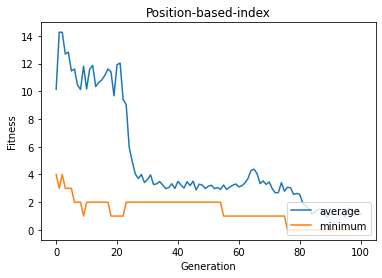

In [22]:
gen, avg, min_ = log.select("gen", "avg", "min")

plt.title("Position-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()



### 5 pts:  Print out the best individual found and its fitness value.  Show the best individual as chessboard

In [23]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is: {}'.format(best_ind))
print('Eval Fitness Value: {}'.format(eval_fitness(best_ind)))
show_grid(best_ind, board_size)


Best individual is: [43, 31, 32, 49, 20, 62, 10, 5]
[]
Eval Fitness Value: (0,)
-|-|-|-|-|X|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
-|-|-|-|X|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|X|-|-|-|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------


## Part II: Row-index-based board representation

In [24]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


/Users/lucassaechao/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/lucassaechao/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Each row of the chess row is indexed from 0->7 . we place different queens on different rows initially.  The sequence [ a b c d .... ] means that in $0^{th}$ row, $a^{th}$ column, the queen is present and so on

In [25]:
toolbox = base.Toolbox()

toolbox.register("attr_int", random.randint, 0, board_size-1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_int, n=board_size)

In [26]:
toolbox.individual()

[0, 4, 6, 3, 0, 5, 0, 0]

In [27]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [28]:
pop = toolbox.population(n=1000)

print(pop[0])

[3, 6, 7, 6, 1, 0, 2, 5]


In [29]:
def show_grid(board, board_size):
    dashes = "--------------------------------"
    dashes = dashes[:(board_size * 2)]
    n = [0] * (board_size * board_size)
    for i in range(len(board)):
        n[board[i] + i * board_size] = 1
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // board_size == i:
                if n[j] == 1:
                    print('X', end="|")
                else:
                    print('-', end="|")
        print()
        print(dashes)

In [30]:
show_grid(pop[0], board_size)

-|-|-|X|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|-|-|-|-|X|-|
----------------
-|X|-|-|-|-|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|X|-|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------


### 10 pts:  Write your code in the cell below to define the "evaFitness" function, which return the fitness of any given board

- evaFitness() returns the total number of distinct pairs of queens that attack each other.  

- The following are some test cases you may use to verify the correctness of the evaFitness() function:

 * evaFitness([0, 2, 6, 7, 7, 4, 1, 6]) should return (4,)

 * evaFitness([7, 5, 2, 4, 3, 1, 3, 5]) should return (6,)

 * evaFitness([3, 1, 6, 0, 5, 7, 2, 1]) should return (5,)

 * evaFitness([7, 3, 1, 4, 5, 1, 3, 5]) should return (6,)



## compute_conflicts()
Computes the number of conflicts in a given board using a frequency list representation of the board in linear time row a row-index representation. Based on following method described in the following page: https://towardsdatascience.com/computing-number-of-conflicting-pairs-in-a-n-queen-board-in-linear-time-and-space-complexity-e9554c0e0645

In [31]:
def compute_conflicts(board):
    n = len(board)
    row = [0] * n
    diag_right = [0] * (2 * n)
    diag_left = [0] * (2 * n)
    
    for i in range(n):
        print(i)
        row[board[i]] += 1
        diag_right[board[i] + i] += 1
        diag_left[n - board[i] + i] += 1
    
    conflicts = 0
    for i in range(2 * n):
        if i < n:
            conflicts += (row[i] * (row[i] - 1)) / 2
        conflicts += (diag_right[i] * (diag_right[i] - 1)) / 2
        conflicts += (diag_left[i] * (diag_left[i] - 1)) / 2
    return int(conflicts) 

In [32]:
#list1 = [0, 2, 6, 7, 7, 4, 1, 6]
#list2 = [7, 5, 2, 4, 3, 1, 3, 5]
#list3 = [3, 1, 6, 0, 5, 7, 2, 1]
#list4 = [7, 3, 1, 4, 5, 1, 3, 5]

In [33]:
#fitness function
def eval_fitness(individual):
    conflict = compute_conflicts(individual)
    return (conflict, )

In [34]:
#print(eval_fitness(list1))
#print(eval_fitness(list2))
#print(eval_fitness(list3))
#print(eval_fitness(list4))

### 5 pts:  Writer your code in the cell below to register "evaluate" function to toolbox

In [35]:

toolbox.register("evaluate", eval_fitness)


In [36]:

toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutUniformInt, low = 0, up = 7, indpb=0.1)

toolbox.register("select", tools.selTournament, tournsize=3)



In [37]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)


stats.register("avg", np.mean)
stats.register("min", np.min)



### 10 pts:  Writer your code in the cell below to create the first generation, the hall of fame, and launch the genetic algorithm: eaSimple().   How many individuals you want to have for each generation and how many generations you want GA to go thourgh for each run?     Vary those two parameters to see the change. 

In [38]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("min", np.min)

pop = toolbox.population(n=1000)

hof = tools.HallOfFame(maxsize=10)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, 
                                   stats=stats, halloffame=hof, verbose=True)


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


10 	631   	3.275	1  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1

1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
18 	572   	1.493	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0

7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
33 	613   	0.516	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
34 	608   	0.484	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1

35 	610   	0.4  	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1

1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


45 	594   	0.351	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1

3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
61 	582   	0.263	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5

3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
71 	581   	0.24 	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6

2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2


4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
94 	547   	0.247	0  
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3


1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4


6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1


2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5


5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0


### 5 pts:  Plot the "avg" and "min" for each generation

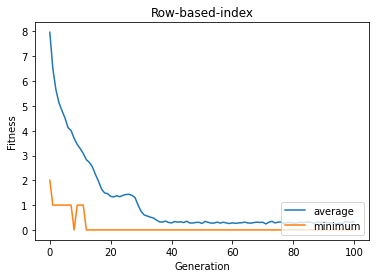

In [39]:
# Plot the "avg" and "min" for each generation

gen, avg, min_ = log.select("gen", "avg", "min")

plt.title("Row-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

### 5 pts:  Print out the best individual found and its fitness value.  Show the best individual as chessboard

In [40]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is:', best_ind)
print('Number of conflicts:',compute_conflicts(best_ind))
show_grid(best_ind, board_size)


Best individual is: [3, 5, 0, 4, 1, 7, 2, 6]
0
1
2
3
4
5
6
7
Number of conflicts: 0
-|-|-|X|-|-|-|-|
----------------
-|-|-|-|-|X|-|-|
----------------
X|-|-|-|-|-|-|-|
----------------
-|-|-|-|X|-|-|-|
----------------
-|X|-|-|-|-|-|-|
----------------
-|-|-|-|-|-|-|X|
----------------
-|-|X|-|-|-|-|-|
----------------
-|-|-|-|-|-|X|-|
----------------


### Reflection:  Which board representaion is better in terms of ease of coding and final solution quality?   Try different parameter values for mutation and crossover and vary the number of generations and the population size.  Write your findings in the report.        

We believe that row-index representation exceeds position-index representation because we are able to put a constraint on one of the fundamental ways queens may attack each other, reducing our search space by a substantial amount. However, programming an evaluation function for this representation required viewing each queen's conflict as a complete graph, which is a much more complex algorithm than the one written for positional-indexing. In other words, row-index representation is more complex to program, but it also yields higher quality results. 
    
Solution quality:
    Row-index representation